# 1. import libraries

In [ ]:
#  !pip install numpy==1.24.3 scikit-learn==1.2.2 imbalanced-learn==0.11.0 category_encoders --force-reinstall
#  !pip install category_encoders

In [ ]:
# --- Manipulación de datos y visualización ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocesamiento ---
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder as CatBoostOneHot
from category_encoders.ordinal import OrdinalEncoder as CatBoostOrdinal

# --- Modelos y algoritmos ---
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

# --- Selección de modelos ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# --- Métricas ---
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# --- Pipeline ---
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

# --- Balanceo de clases ---
from imblearn.over_sampling import SMOTE

# --- Interpretabilidad ---
import shap

# --- Otros ---
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
churn = pd.read_csv("/content/drive/MyDrive/churn.csv")

In [ ]:
churn.head()

Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV    Male   78       No            Yes      No         No   
1  7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY    Male   71       No            Yes      No        Yes   
3  4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4  4846-WHAFZ  Female   80       No            Yes     Yes        Yes   

   Number of Dependents        Country       State  ...  \
0                     0  United States  California  ...   
1                     1  United States  California  ...   
2                     3  United States  California  ...   
3                     1  United States  California  ...   
4                     1  United States  California  ...   

  Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                       20                         0.00          59.65   
1                        0                       390.80        1024.10   
2                        0                       203.94        1910.88   
3                        0                       494.00        2995.07   
4                        0                       234.21        3102.36   

   Satisfaction Score  Customer Status Churn Label Churn Score  CLTV  \
0                   3          Churned         Yes          91  5433   
1                   3          Churned         Yes          69  5302   
2                   2          Churned         Yes          81  3179   
3                   2          Churned         Yes          88  5337   
4                   2          Churned         Yes          67  2793   

    Churn Category                  Churn Reason  
0       Competitor  Competitor offered more data  
1       Competitor  Competitor made better offer  
2       Competitor  Competitor made better offer  
3  Dissatisfaction     Limited range of services  
4            Price            Extra data charges  

[5 rows x 50 columns]

In [ ]:
churn.shape

(7043, 50)

# 3. Exploratory Data Analysis and Data Processing

In [ ]:
for col in churn.columns:
      print(f"\n{col}\n")
      print(churn[col].unique())


Customer ID

['8779-QRDMV' '7495-OOKFY' '1658-BYGOY' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']

Gender

['Male' 'Female']

Age

[78 74 71 80 72 76 66 70 77 65 67 68 69 79 75 73 37 19 31 23 38 21 29 61
 27 20 56 51 48 32 34 41 30 26 62 64 45 53 63 42 24 54 39 43 50 22 40 47
 60 52 55 59 49 58 25 28 33 44 57 46 36 35]

Under 30

['No' 'Yes']

Senior Citizen

['Yes' 'No']

Married

['No' 'Yes']

Dependents

['No' 'Yes']

Number of Dependents

[0 1 3 2 5 4 6 7 8 9]

Country

['United States']

State

['California']

City

['Los Angeles' 'Inglewood' 'Whittier' ... 'Topaz' 'Jacumba' 'Holtville']

Zip Code

[90022 90063 90065 ... 91934 92105 92250]

Latitude

[34.02381  34.044271 34.108833 ... 32.649787 32.741859 32.811001]

Longitude

[-118.156582 -118.185237 -118.229715 ... -116.2237   -117.090353
 -115.152865]

Population

[68701 55668 47534 ...   116 73006  8062]

Quarter

['Q3']

Referred a Friend

['No' 'Yes']

Number of Referrals

[ 0  1  6  2  4  3  7  5  8  9 10 11]

Tenure in Mo

In [ ]:
for col in churn.columns:
    if churn[col].nunique() == 1:
      print(f"\n{col}\n")
      print(churn[col].unique())



Country

['United States']

State

['California']

Quarter

['Q3']


In [ ]:
data = churn.copy()

Se eliminan variables con un solo valor único en la data, debido a que no aportan ningun valor para posteriores análisis.

In [ ]:
for col in data.columns:
    if data[col].nunique() == 1:
      drop_columns = [col]
      data = data.drop(drop_columns, axis=1)


Se eliminan aquellas variables que poseen valores unicos por cada fila, debido a que no aportan ningun valor para posteriores análisis.

In [ ]:
print(f'Numero total de valores {data.shape[0]}')
for col in data.columns:
    if data[col].nunique() == data.shape[0]:
      print(f' Cantidad de datos en {col} : {data[col].nunique()}')

Numero total de valores 7043
 Cantidad de datos en Customer ID : 7043


In [ ]:
columns_to_delete = ['Customer ID']
data = data.drop(columns_to_delete, axis=1)

In [ ]:
data[data['Avg Monthly Long Distance Charges'] == 0]['Phone Service'].value_counts()

Phone Service
No    682
Name: count, dtype: int64

In [ ]:
data[data['Phone Service'] == 'No']['Avg Monthly Long Distance Charges'].value_counts()

Avg Monthly Long Distance Charges
0.0    682
Name: count, dtype: int64

In [ ]:
data[data['Phone Service'] == 'Yes']['Avg Monthly Long Distance Charges'].describe()

count    6361.000000
mean       25.420517
std        14.200374
min         1.010000
25%        13.050000
50%        25.690000
75%        37.680000
max        49.990000
Name: Avg Monthly Long Distance Charges, dtype: float64

In [ ]:
data[data['Internet Service'] == 'No']['Internet Type'].isna().value_counts()

Internet Type
True    1526
Name: count, dtype: int64

Se eliminan aquellas variables que no deben ser tomadas en el análisis de acuerdo a lo mencionado en el archivo 'churn_dictionary', y aquellas variables que no ofrecen comportamientos nuevos en el análisis.

Las variables eliminadas por indicación del documento son:



*   Satisfaction Score
*   Customer Status
*   Churn Category
*   Churn Reason
*   Churn Score
*   Churn Label

Las variables eliminadas por exploración son:

* Phone Service: Cuando este variable es igual a No, la columna Avg Monthly Long Distance Charges tiene valor 0, si es Si la variable mencionada proporciona un valor float mayor a 0, debido a que el minimo de esta columna es estos casos es 0.

* Internet Service: Cuando esta variable es igual a No, la variable Internet Typo es un valor nulo, y cuando es Si, la variable mencionada proporciona el tipo de interenet dando mejor detalle.

* Dependents: Cuando esta variable es igual a No, la variable Number of Dependents es 0, y cuando es Si, la variable mencionada proporciona la cantidad de dependientes.

* Referred a Friend: Cuando esta variable es igual a No, la variable Number of Referrals es 0, y cuando es Si, la variable mencionada proporciona la cantidad de referidos.



In [ ]:
columns_to_delete = ['Satisfaction Score',
                     'Under 30',
                     'Senior Citizen',
                     'Customer Status',
                     'Churn Category',
                     'Churn Reason',
                     'Churn Score',
                     'Dependents',
                     'Internet Service',
                     'Phone Service',
                     'Referred a Friend']
data = data.drop(columns_to_delete, axis=1)

In [ ]:
data.head()

Gender  Age Married  Number of Dependents         City  Zip Code  \
0    Male   78      No                     0  Los Angeles     90022   
1  Female   74     Yes                     1  Los Angeles     90063   
2    Male   71      No                     3  Los Angeles     90065   
3  Female   78     Yes                     1    Inglewood     90303   
4  Female   80     Yes                     1     Whittier     90602   

    Latitude   Longitude  Population  Number of Referrals  ...  \
0  34.023810 -118.156582       68701                    0  ...   
1  34.044271 -118.185237       55668                    1  ...   
2  34.108833 -118.229715       47534                    0  ...   
3  33.936291 -118.332639       27778                    1  ...   
4  33.972119 -118.020188       26265                    1  ...   

   Paperless Billing   Payment Method  Monthly Charge Total Charges  \
0                Yes  Bank Withdrawal           39.65         39.65   
1                Yes      Credit Card           80.65        633.30   
2                Yes  Bank Withdrawal           95.45       1752.55   
3                Yes  Bank Withdrawal           98.50       2514.50   
4                Yes  Bank Withdrawal           76.50       2868.15   

  Total Refunds  Total Extra Data Charges Total Long Distance Charges  \
0          0.00                        20                        0.00   
1          0.00                         0                      390.80   
2         45.61                         0                      203.94   
3         13.43                         0                      494.00   
4          0.00                         0                      234.21   

  Total Revenue Churn Label  CLTV  
0         59.65         Yes  5433  
1       1024.10         Yes  5302  
2       1910.88         Yes  3179  
3       2995.07         Yes  5337  
4       3102.36         Yes  2793  

[5 rows x 35 columns]

Tratando valores nulos

In [ ]:
def analizar_valores_faltantes(data):
    valores_faltantes = data.isnull().sum()
    porcentaje = (valores_faltantes / len(data)) * 100

    datos_faltantes = pd.DataFrame({
        'Valores Faltantes': valores_faltantes,
        'Porcentaje': porcentaje
    })

    return datos_faltantes.sort_values('Porcentaje', ascending=False)

In [ ]:
print("Análisis de Valores Faltantes:")
print(analizar_valores_faltantes(data))

Análisis de Valores Faltantes:
                                   Valores Faltantes  Porcentaje
Offer                                           3877   55.047565
Internet Type                                   1526   21.666903
Gender                                             0    0.000000
Premium Tech Support                               0    0.000000
Streaming Movies                                   0    0.000000
Streaming Music                                    0    0.000000
Unlimited Data                                     0    0.000000
Contract                                           0    0.000000
Paperless Billing                                  0    0.000000
Payment Method                                     0    0.000000
Monthly Charge                                     0    0.000000
Total Charges                                      0    0.000000
Total Refunds                                      0    0.000000
Total Extra Data Charges                           0    0.0

Dado que las variables que presentan valores nulos, son Offer y Internet Type, cuyas clasificaciones si aceptan valores nulos, estos se van reemplazar con una clasificacion que haga referencia al valor nulo, ejemplo, no service, no offer. Para que dentro del posterior OHE (one hot encoder) se le asigne un valor.

In [ ]:
data['Offer'] = data['Offer'].fillna("No Offer")
data['Internet Type'] = data['Internet Type'].fillna("No Internet")

In [ ]:
#Filtramos columnas numericas
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop(['Zip Code', 'Latitude', 'Longitude'])
data[numerical_columns].describe()


Age  Number of Dependents     Population  Number of Referrals  \
count  7043.000000           7043.000000    7043.000000          7043.000000   
mean     46.509726              0.468692   22139.603294             1.951867   
std      16.750352              0.962802   21152.392837             3.001199   
min      19.000000              0.000000      11.000000             0.000000   
25%      32.000000              0.000000    2344.000000             0.000000   
50%      46.000000              0.000000   17554.000000             0.000000   
75%      60.000000              0.000000   36125.000000             3.000000   
max      80.000000              9.000000  105285.000000            11.000000   

       Tenure in Months  Avg Monthly Long Distance Charges  \
count       7043.000000                        7043.000000   
mean          32.386767                          22.958954   
std           24.542061                          15.448113   
min            1.000000                           0.000000   
25%            9.000000                           9.210000   
50%           29.000000                          22.890000   
75%           55.000000                          36.395000   
max           72.000000                          49.990000   

       Avg Monthly GB Download  Monthly Charge  Total Charges  Total Refunds  \
count              7043.000000     7043.000000    7043.000000    7043.000000   
mean                 20.515405       64.761692    2280.381264       1.962182   
std                  20.418940       30.090047    2266.220462       7.902614   
min                   0.000000       18.250000      18.800000       0.000000   
25%                   3.000000       35.500000     400.150000       0.000000   
50%                  17.000000       70.350000    1394.550000       0.000000   
75%                  27.000000       89.850000    3786.600000       0.000000   
max                  85.000000      118.750000    8684.800000      49.790000   

       Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
count               7043.000000                  7043.000000    7043.000000   
mean                   6.860713                   749.099262    3034.379056   
std                   25.104978                   846.660055    2865.204542   
min                    0.000000                     0.000000      21.360000   
25%                    0.000000                    70.545000     605.610000   
50%                    0.000000                   401.440000    2108.640000   
75%                    0.000000                  1191.100000    4801.145000   
max                  150.000000                  3564.720000   11979.340000   

              CLTV  
count  7043.000000  
mean   4400.295755  
std    1183.057152  
min    2003.000000  
25%    3469.000000  
50%    4527.000000  
75%    5380.500000  
max    6500.000000

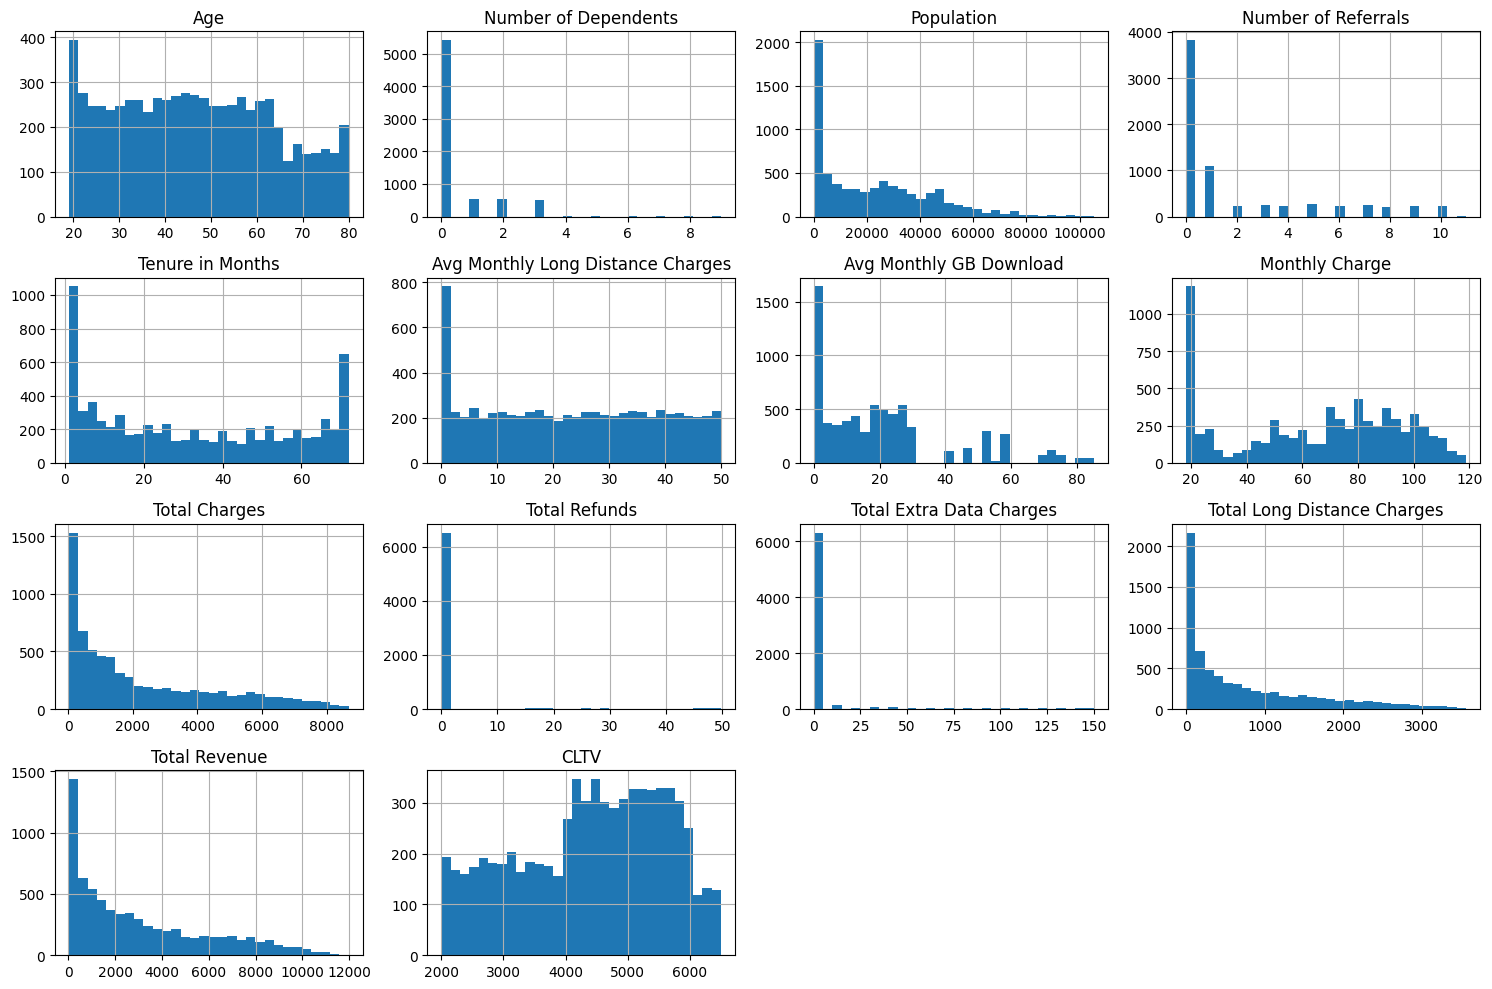

In [ ]:
# Histograma de las variables numéricas
data[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


En las graficas de distribución de valores dentro del dataset, se puede observar que las variables, total charges, total long distance charges, tienen un comportamiento parecido a total revenue, debido a que estas variables son parte de la siguiente formula:

Total revenue = Total Charges + Total Refunds + Total Extra Data Charges + Total Long Distance Charges

Sin embargo, las variables Total Regunds y Total Extra Data Charges podrían generar una retroalimentación importante dado que podrían ser causal de una decision de abandono, por lo cual estas se mantendran en analisis hasta posteriores validaciones.

In [ ]:
#Eliminamos columna Total Charges y Total Long Distance Charges

data = data.drop(['Total Charges', 'Total Long Distance Charges'], axis=1)

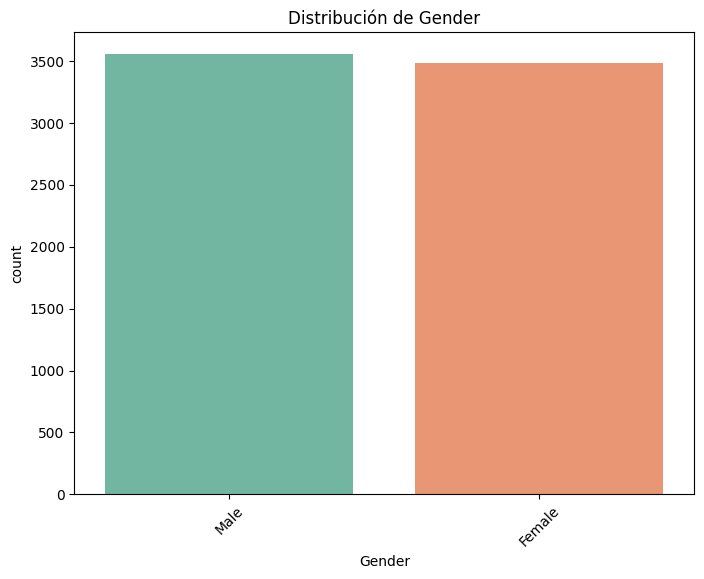

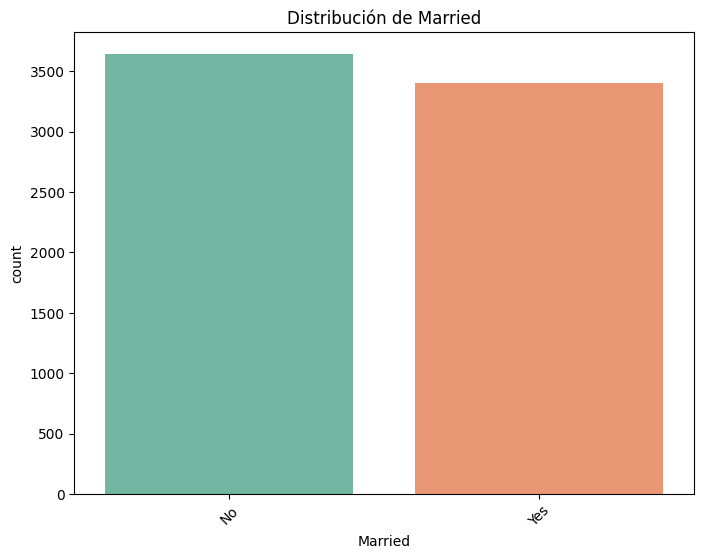

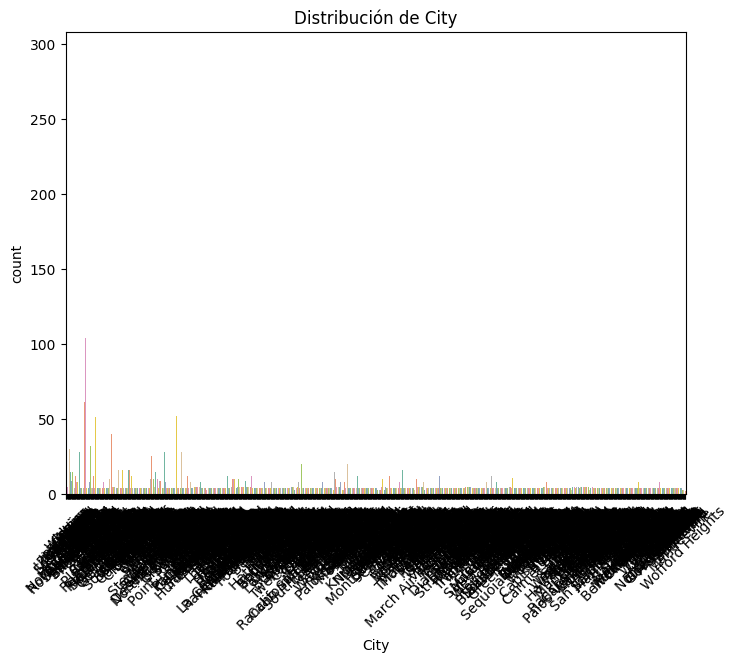

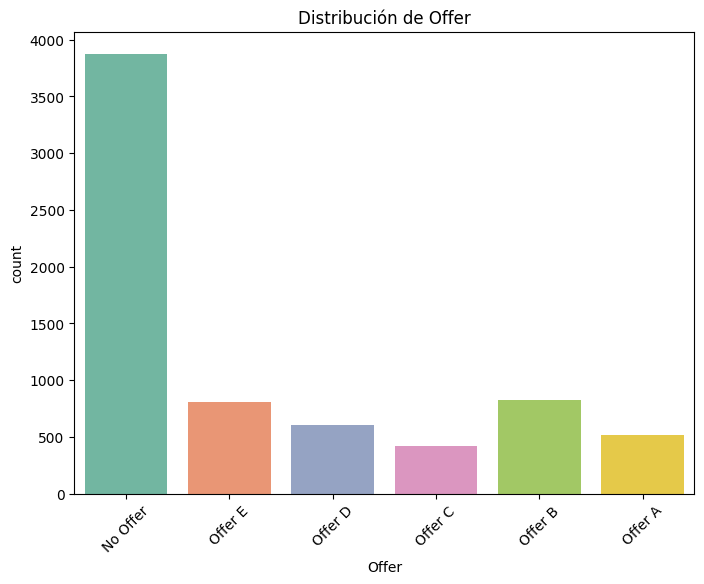

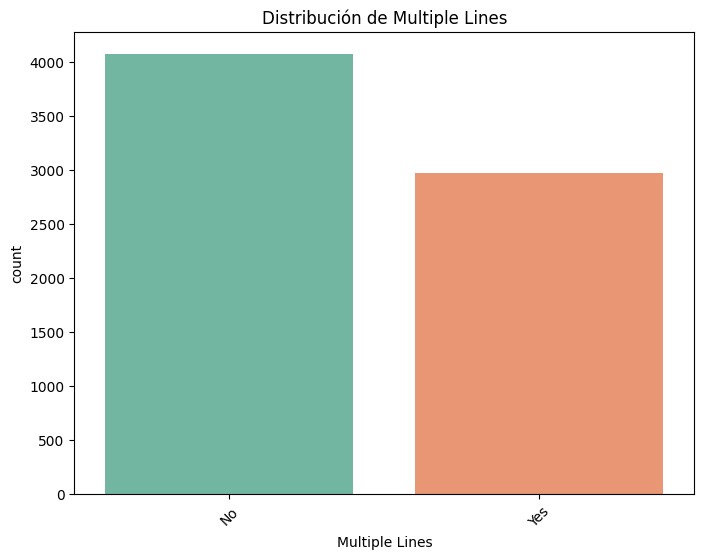

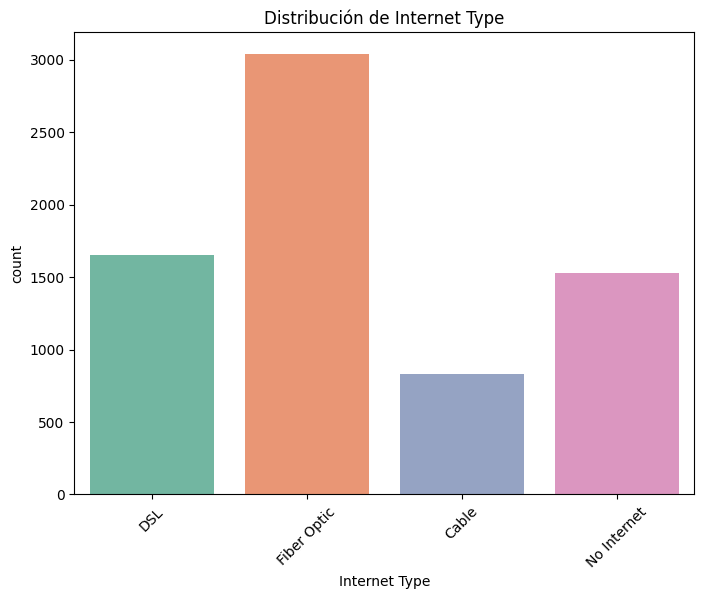

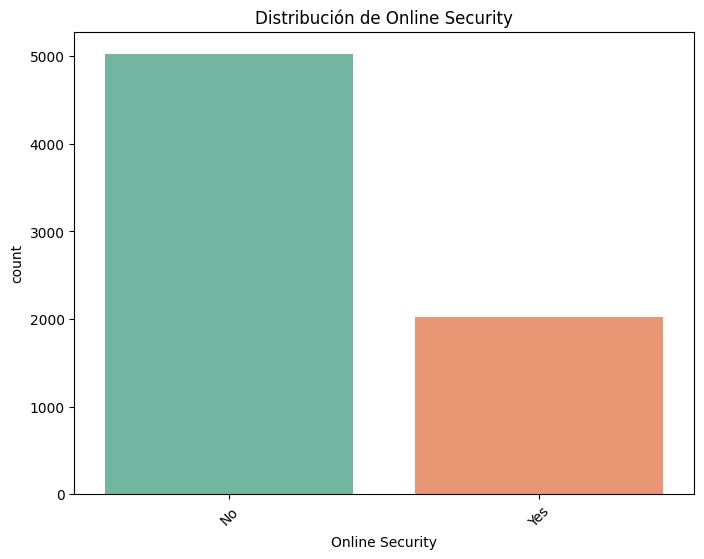

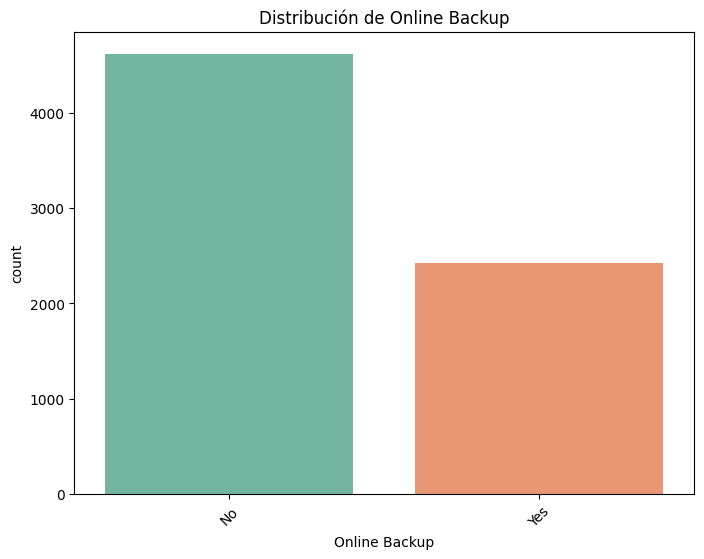

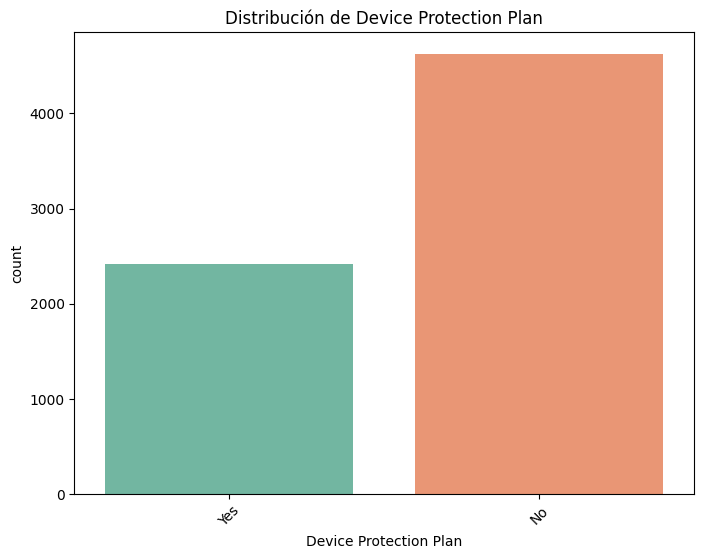

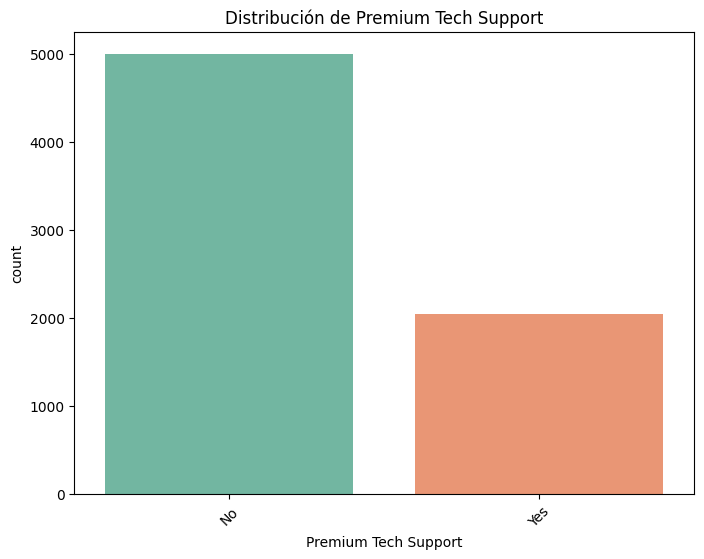

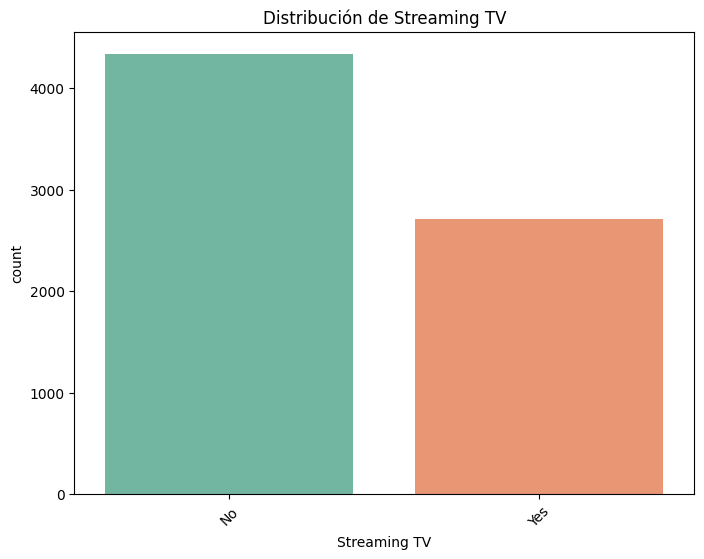

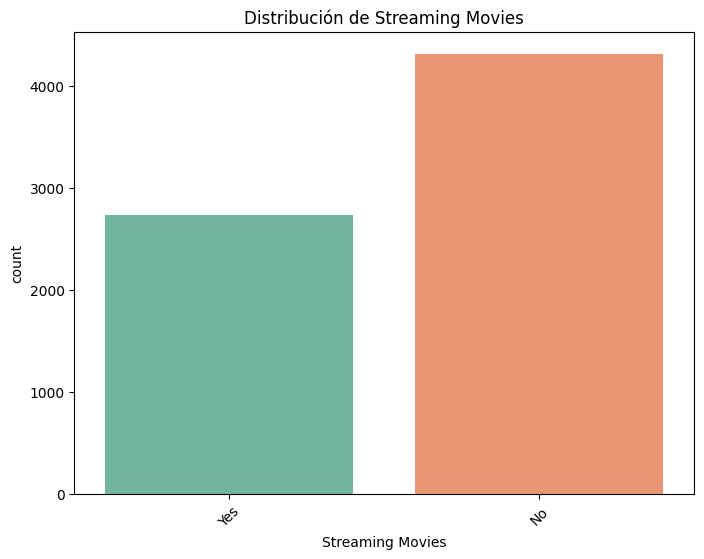

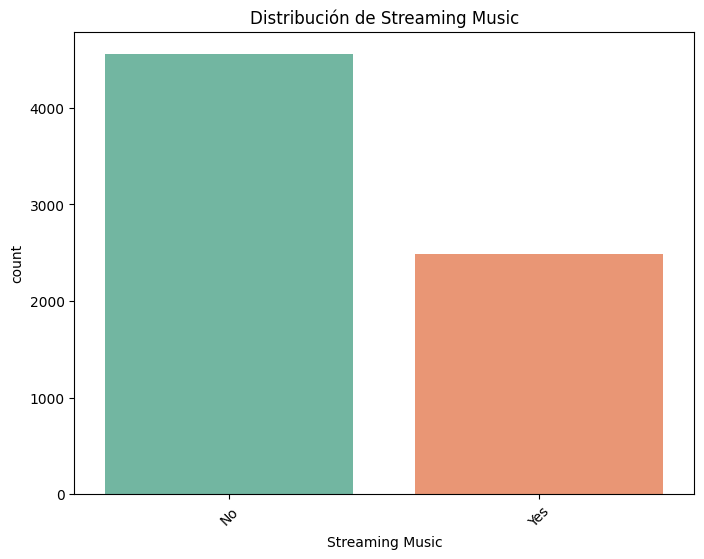

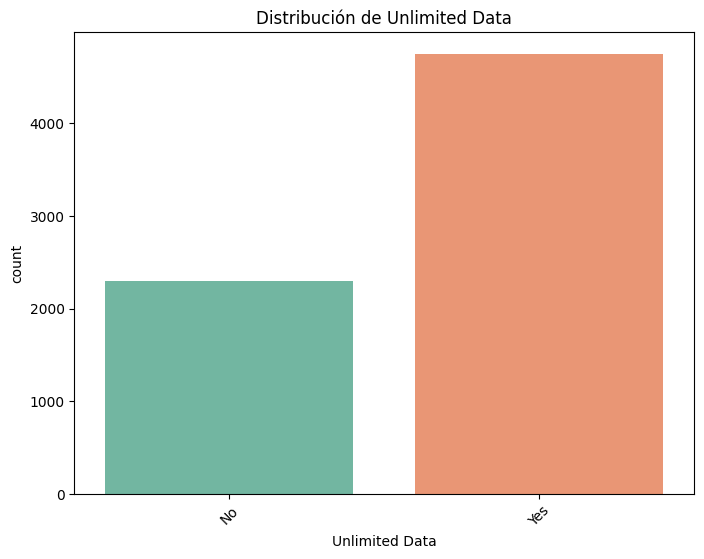

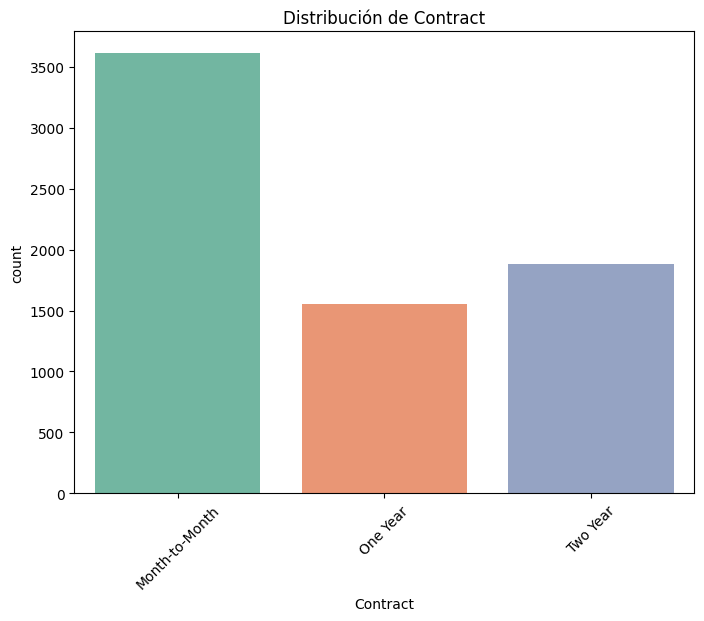

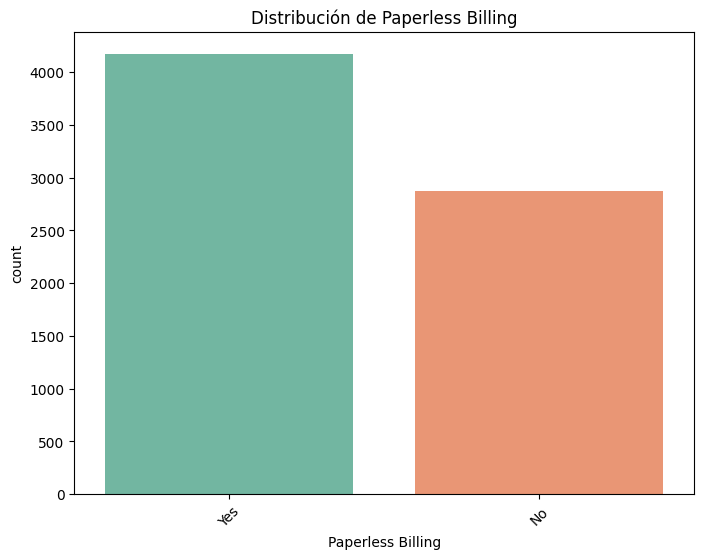

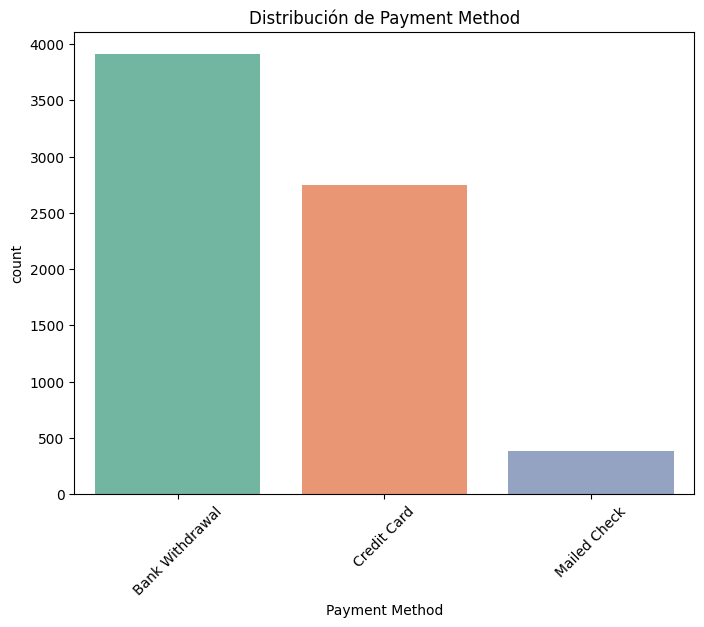

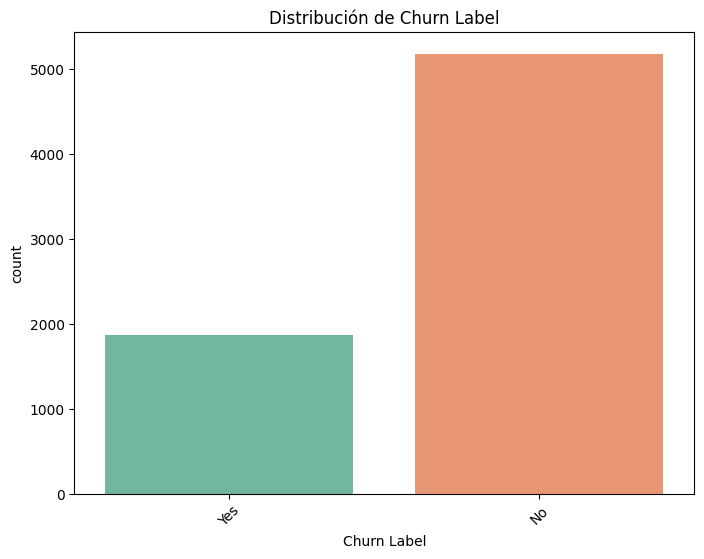

In [ ]:
# Gráfico de barras para variables categóricas
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=data, palette='Set2')
    plt.title(f'Distribución de {column}')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Revisión de los valores únicos con porcentajes
for col in data.columns:
    print("\n")
    print(data[col].value_counts(normalize=True) * 100)  # Multiplicamos por 100 para obtener el porcentaje




Gender
Male      50.47565
Female    49.52435
Name: proportion, dtype: float64


Age
42    2.214965
47    2.172370
40    2.129774
44    2.101377
23    2.072980
        ...   
80    0.937101
66    0.894505
78    0.894505
67    0.866108
72    0.823513
Name: proportion, Length: 62, dtype: float64


Married
No     51.69672
Yes    48.30328
Name: proportion, dtype: float64


Number of Dependents
0    76.899049
1     7.851768
2     7.539401
3     7.340622
5     0.141985
4     0.127786
6     0.042595
7     0.028397
8     0.014198
9     0.014198
Name: proportion, dtype: float64


City
Los Angeles         4.160159
San Diego           4.046571
San Jose            1.590231
Sacramento          1.533437
San Francisco       1.476643
                      ...   
Jacumba             0.028397
South Lake Tahoe    0.028397
Johannesburg        0.028397
Eldridge            0.028397
Holtville           0.028397
Name: proportion, Length: 1106, dtype: float64


Zip Code
92028    0.610535
92027    0.539543
921

Se observa un desbalance de la variable objetivo "Churn Label":


* No     73.463013 %
* Yes    26.536987 %

In [ ]:
numerical_columns = numerical_columns.drop(['Total Charges', 'Total Long Distance Charges'])

<Axes: >

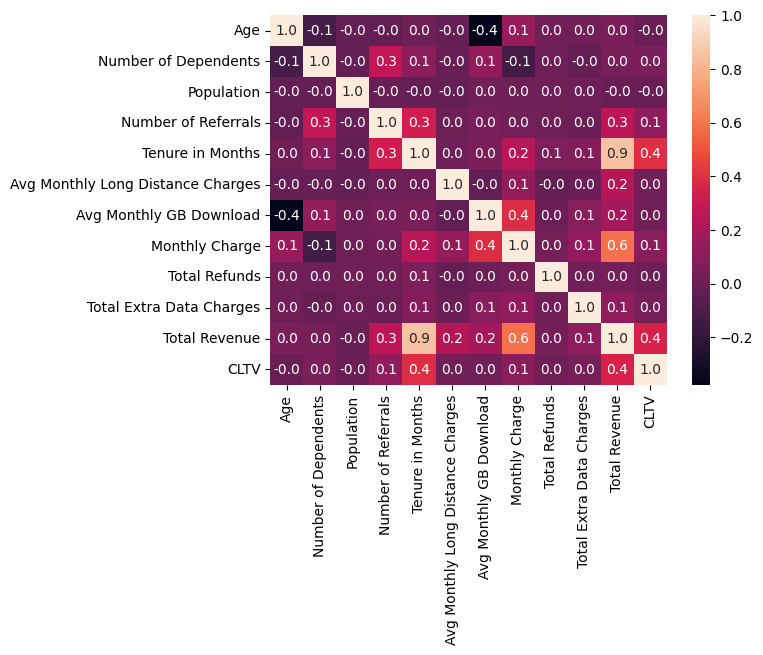

In [ ]:
sns.heatmap(data[numerical_columns].corr(), annot=True, fmt=".1f")

In [ ]:
# Primero obtenemos la matriz de correlación
correlation_matrix = data[numerical_columns].corr(numeric_only=True)

# Extraemos las correlaciones mayores a 0.7 (sin la diagonal)
correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            correlated_pairs.append((var1, var2, corr_value))

# Convertimos a DataFrame para mejor visualización
correlated_df = pd.DataFrame(correlated_pairs, columns=["Variable 1", "Variable 2", "Correlación"])
correlated_df = correlated_df.sort_values(by="Correlación", ascending=False)

# Mostramos los pares correlacionados
correlated_df


Variable 1     Variable 2  Correlación
0  Tenure in Months  Total Revenue     0.853146

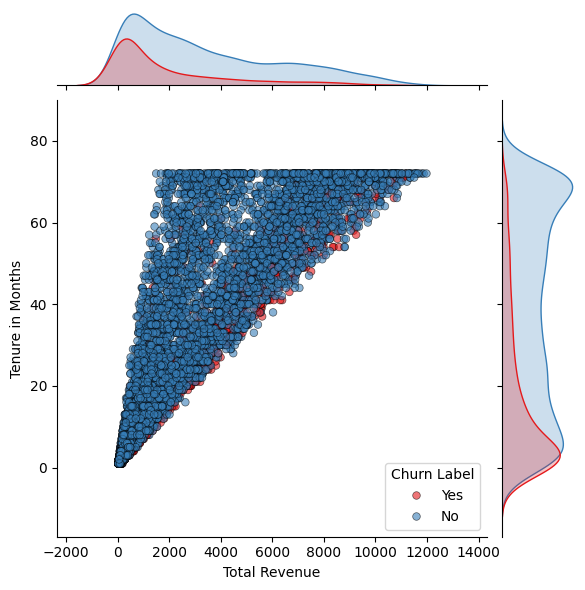

In [ ]:
#Visualizando correlacion elevada
sns.jointplot(data=data, x='Total Revenue', y='Tenure in Months', hue='Churn Label', alpha=0.6, edgecolor='black', linewidth = 0.5, palette='Set1',s=30)
plt.show()

Se observa que ambas variables tienen un comportamiento muy parecido con resepecto al impacto entre si, se puede considerar que existe una causalidad del uno con el otro, debido a que una mayor permanencia implica tambien una mayor cantidad de ingreso total acumulado por cliente.

Sin embargo, su comportamiento con respecto a la variable objetivo si presenta una variación debido a que la variable No en churn label se comporta distinto en cada una de ellas, para revenue disminuye conforme aumenta. En el caso de tenure aumenta la probabilidad de que No abandone.

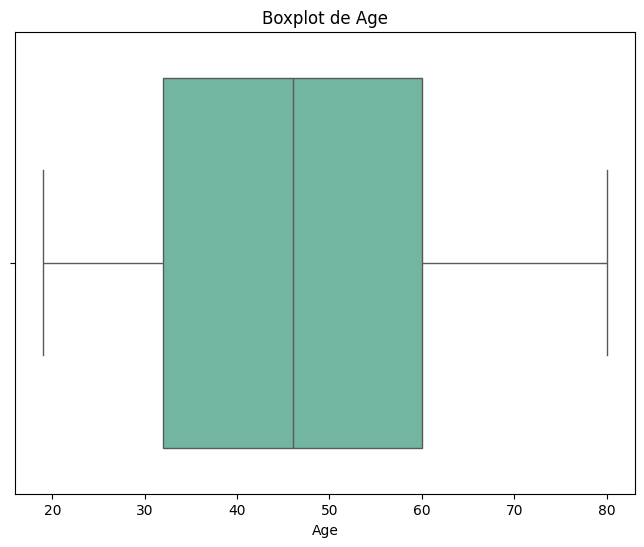

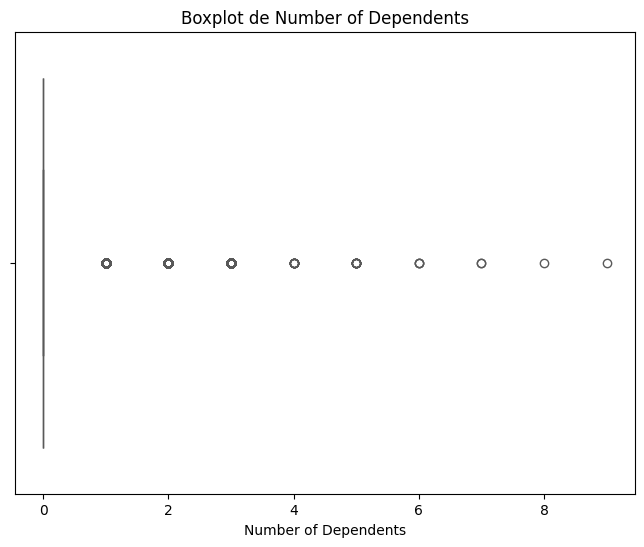

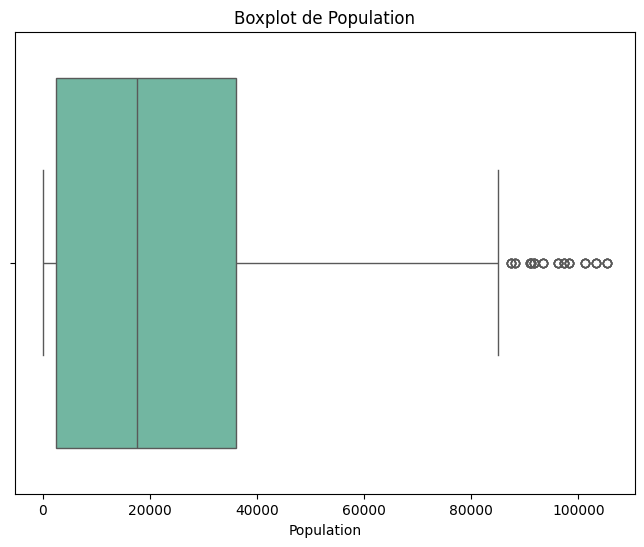

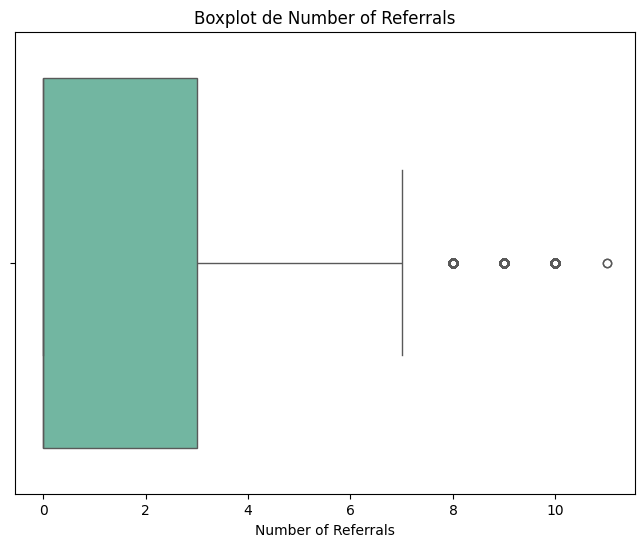

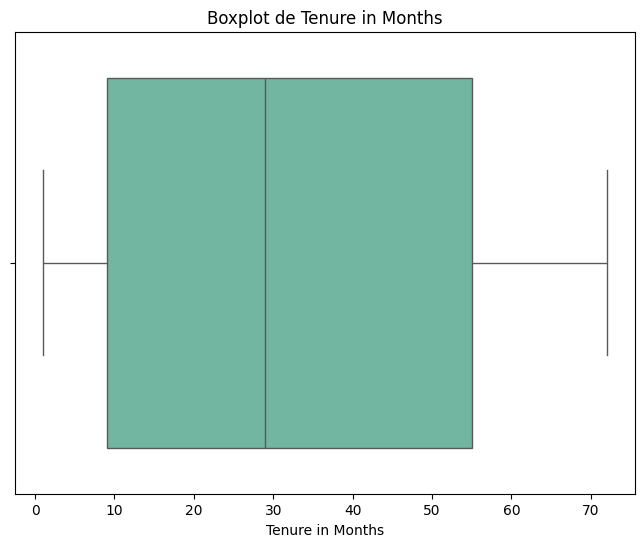

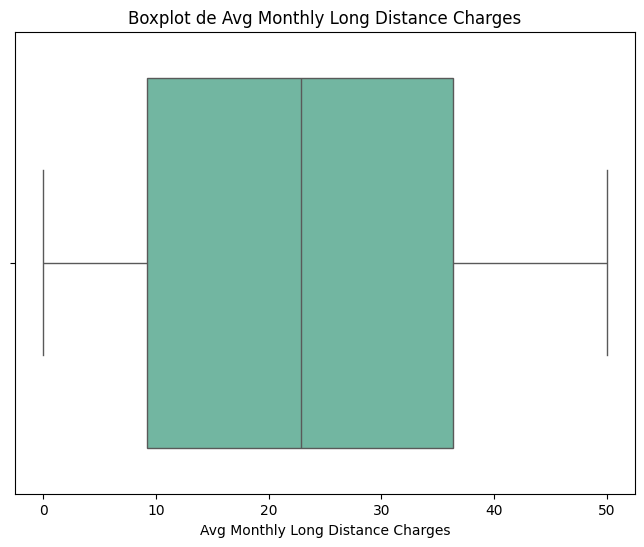

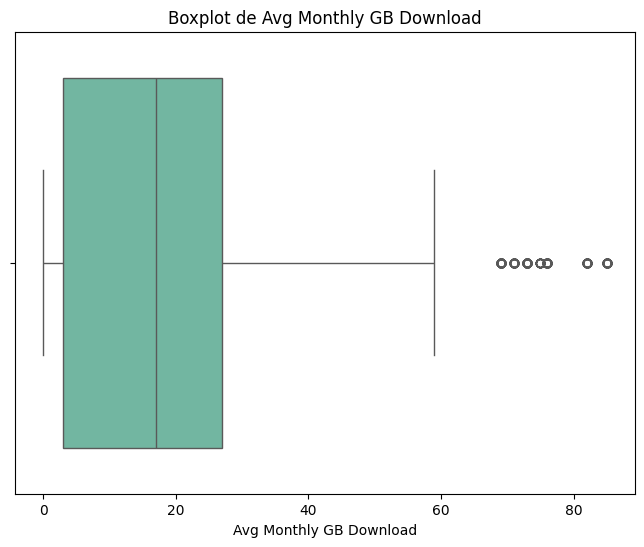

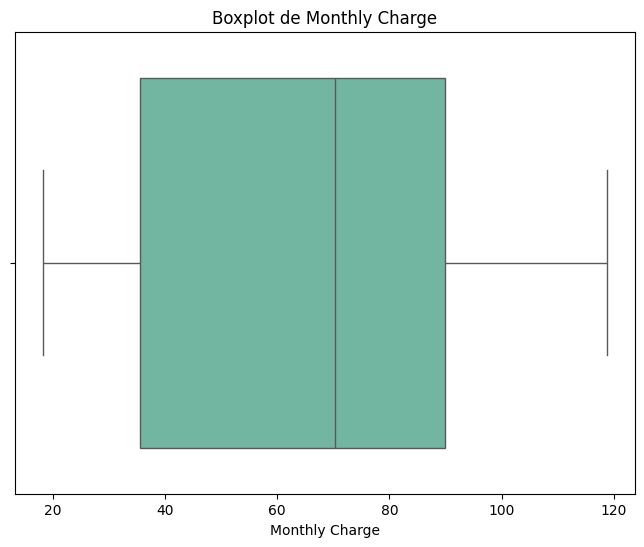

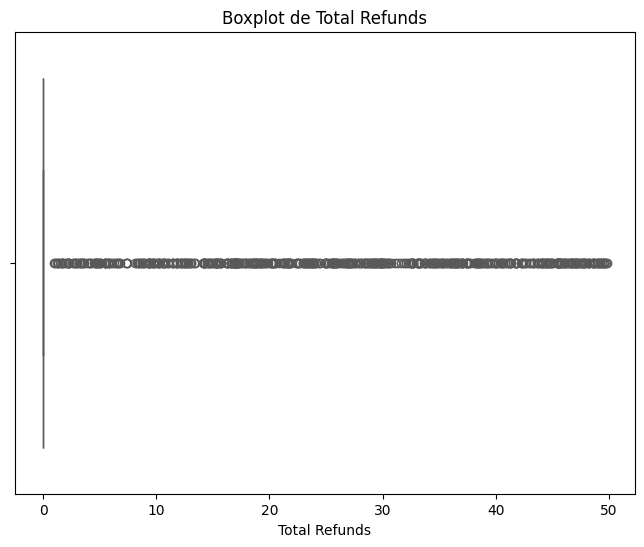

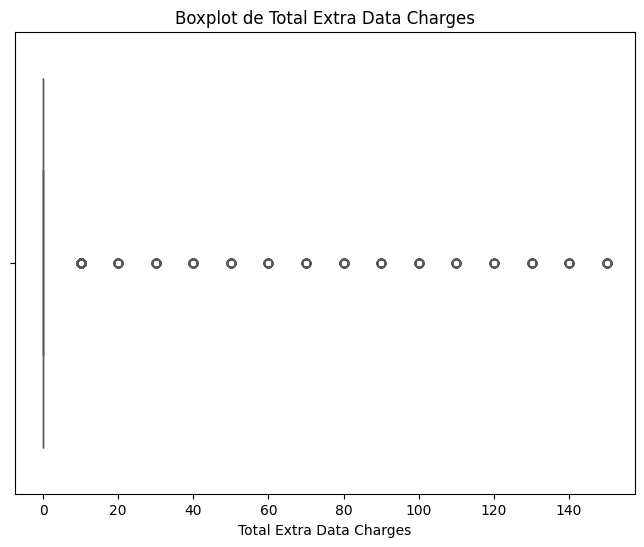

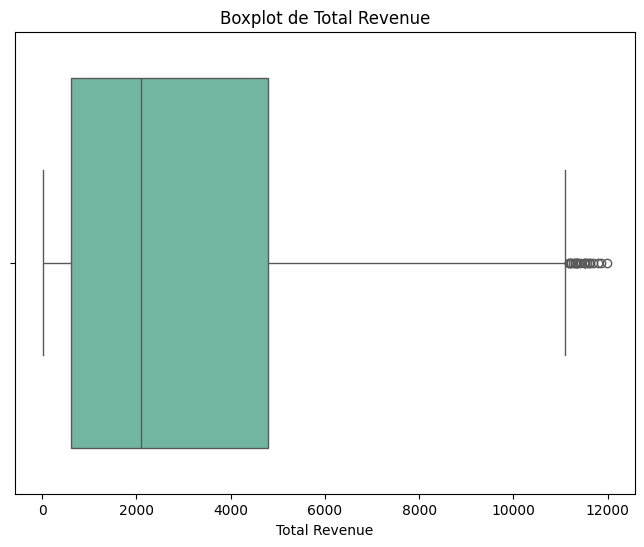

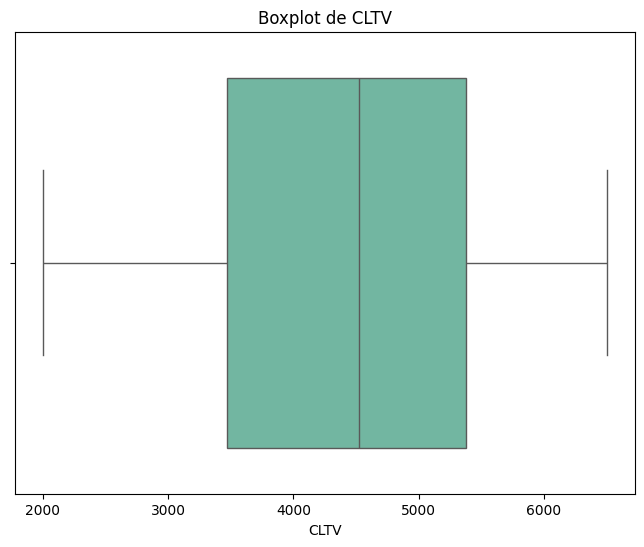

In [ ]:
# Crear un boxplot para cada variable numérica
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[col], palette='Set2')
    plt.title(f'Boxplot de {col}')
    plt.show()


Si bien se observan ciertos valores fuera de rango, no se consideran como outliers a tratar debido a que podrían ser casos reales puntuales.

## Feature Engineering

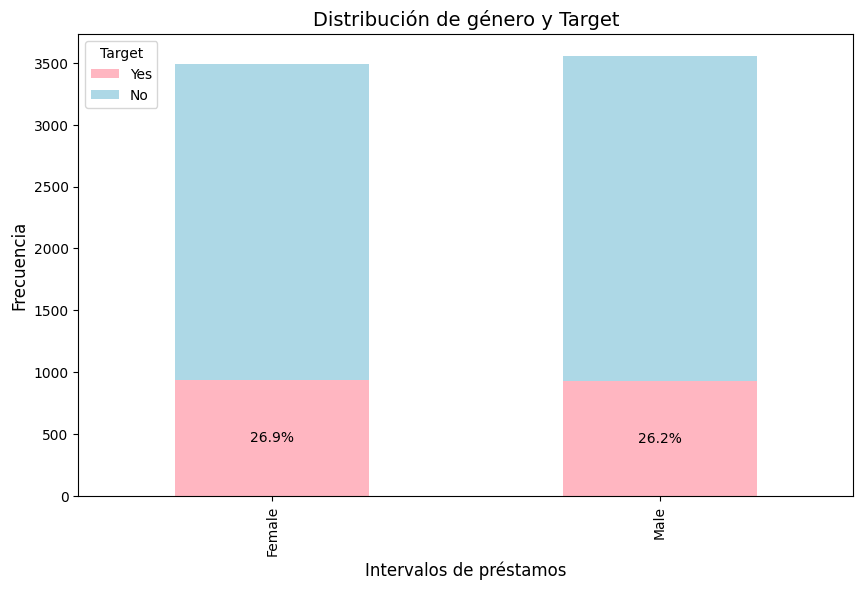

In [ ]:
# Agrupar los datos por categoría e intervalo
grouped_data = data.groupby(['Gender', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de "bad"
grouped_data['Yes_porcentaje'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)


for i, (index, row) in enumerate(grouped_data.iterrows()):
    total = row['Yes'] + row['No']
    porcentaje_yes = row['Yes'] / total * 100
    height_yes = row['Yes']
    ax1.text(i, height_yes / 2, f'{porcentaje_yes:.1f}%', ha='center', va='center', fontsize=10, color='black')

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Intervalos de préstamos', fontsize=12)
ax1.set_title('Distribución de género y Target', fontsize=14)
ax1.legend(['Yes', 'No'], title='Target', loc='upper left')


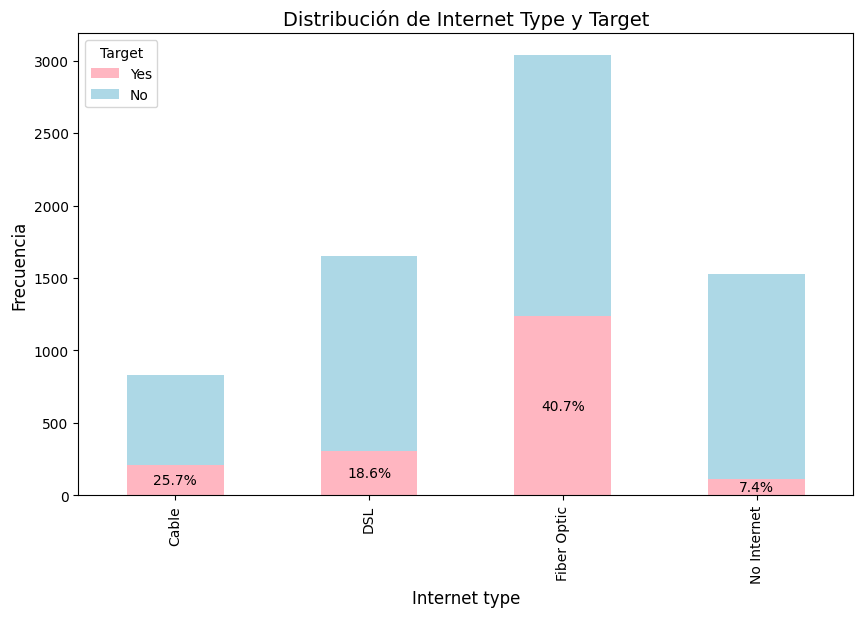

In [ ]:
# Agrupar los datos por categoría e intervalo
grouped_data = data.groupby(["Internet Type", 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de "bad"
grouped_data['Yes_porcentaje'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)


for i, (index, row) in enumerate(grouped_data.iterrows()):
    total = row['Yes'] + row['No']
    porcentaje_yes = row['Yes'] / total * 100
    height_yes = row['Yes']
    ax1.text(i, height_yes / 2, f'{porcentaje_yes:.1f}%', ha='center', va='center', fontsize=10, color='black')

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Internet type', fontsize=12)
ax1.set_title('Distribución de Internet Type y Target', fontsize=14)
ax1.legend(['Yes', 'No'], title='Target', loc='upper left')


In [ ]:
data["Number of Dependents"].value_counts()

Number of Dependents
0    5416
1     553
2     531
3     517
5      10
4       9
6       3
7       2
8       1
9       1
Name: count, dtype: int64

Se observa que la mayor cantidad de datos se acumula de 0 a 3 dependientes por lo que se trabajará con 3 grupos.

* 0 sin dependientes
* 1 a 3 dependientes
* mas de 3 dependientes

In [ ]:
def dependientes(x):
    if x["Number of Dependents"] == 0:
        return "Grupo sin dependientes"
    elif x["Number of Dependents"]>0 and x["Number of Dependents"]<= 3:
        return "De 1 a 3 dependientes"
    elif x["Number of Dependents"] >3:
        return "Más de 3 dependientes"

In [ ]:
data["Dependientes"]=data.apply(lambda x: dependientes(x),axis=1)

In [ ]:
data["Dependientes"].value_counts()

Dependientes
Grupo sin dependientes    5416
De 1 a 3 dependientes     1601
Más de 3 dependientes       26
Name: count, dtype: int64

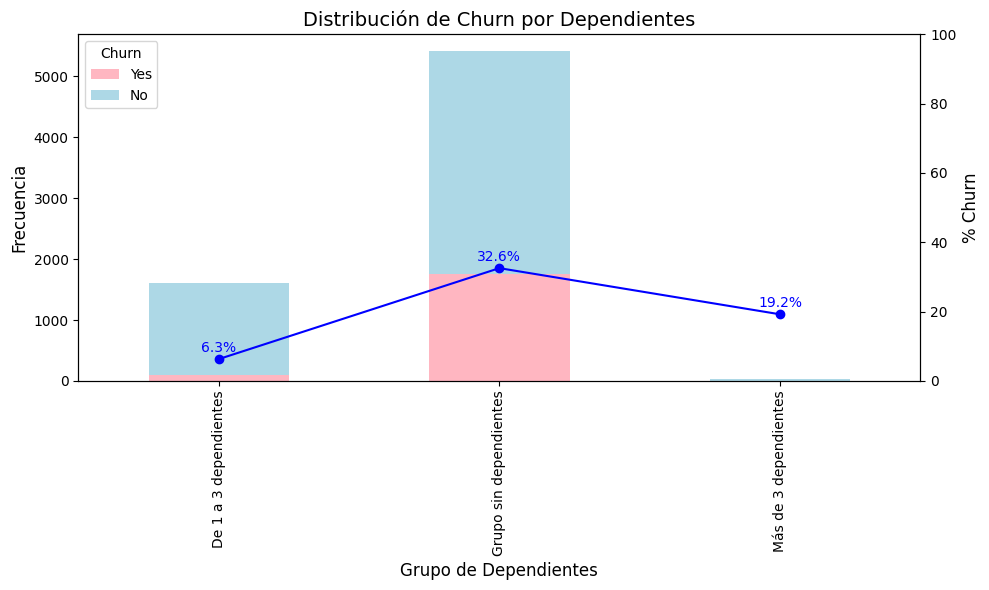

In [ ]:
import matplotlib.pyplot as plt

# Agrupar los datos por Dependientes y Churn Label
grouped_data = data.groupby(['Dependientes', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de churn ("Yes")
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Grupo de Dependientes', fontsize=12)
ax1.set_title('Distribución de Churn por Dependientes', fontsize=14)
ax1.legend(['Yes', 'No'], title='Churn', loc='upper left')

# Crear un segundo eje Y para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['Yes_percentage'], color='blue', marker='o', label='% Yes')
ax2.set_ylabel('% Churn', fontsize=12)
ax2.set_ylim(0, 100)

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
data['City'] = data['City'].str.strip().str.title()
frecuencias = data['City'].value_counts().to_dict()
data['city_freq'] = data['City'].map(frecuencias)
data.head()

Gender  Age Married  Number of Dependents         City  Zip Code  \
0    Male   78      No                     0  Los Angeles     90022   
1  Female   74     Yes                     1  Los Angeles     90063   
2    Male   71      No                     3  Los Angeles     90065   
3  Female   78     Yes                     1    Inglewood     90303   
4  Female   80     Yes                     1     Whittier     90602   

    Latitude   Longitude  Population  Number of Referrals  ...  \
0  34.023810 -118.156582       68701                    0  ...   
1  34.044271 -118.185237       55668                    1  ...   
2  34.108833 -118.229715       47534                    0  ...   
3  33.936291 -118.332639       27778                    1  ...   
4  33.972119 -118.020188       26265                    1  ...   

   Paperless Billing   Payment Method  Monthly Charge Total Refunds  \
0                Yes  Bank Withdrawal           39.65          0.00   
1                Yes      Credit Card           80.65          0.00   
2                Yes  Bank Withdrawal           95.45         45.61   
3                Yes  Bank Withdrawal           98.50         13.43   
4                Yes  Bank Withdrawal           76.50          0.00   

  Total Extra Data Charges  Total Revenue Churn Label  CLTV  \
0                       20          59.65         Yes  5433   
1                        0        1024.10         Yes  5302   
2                        0        1910.88         Yes  3179   
3                        0        2995.07         Yes  5337   
4                        0        3102.36         Yes  2793   

             Dependientes city_freq  
0  Grupo sin dependientes       293  
1   De 1 a 3 dependientes       293  
2   De 1 a 3 dependientes       293  
3   De 1 a 3 dependientes        25  
4   De 1 a 3 dependientes        30  

[5 rows x 35 columns]

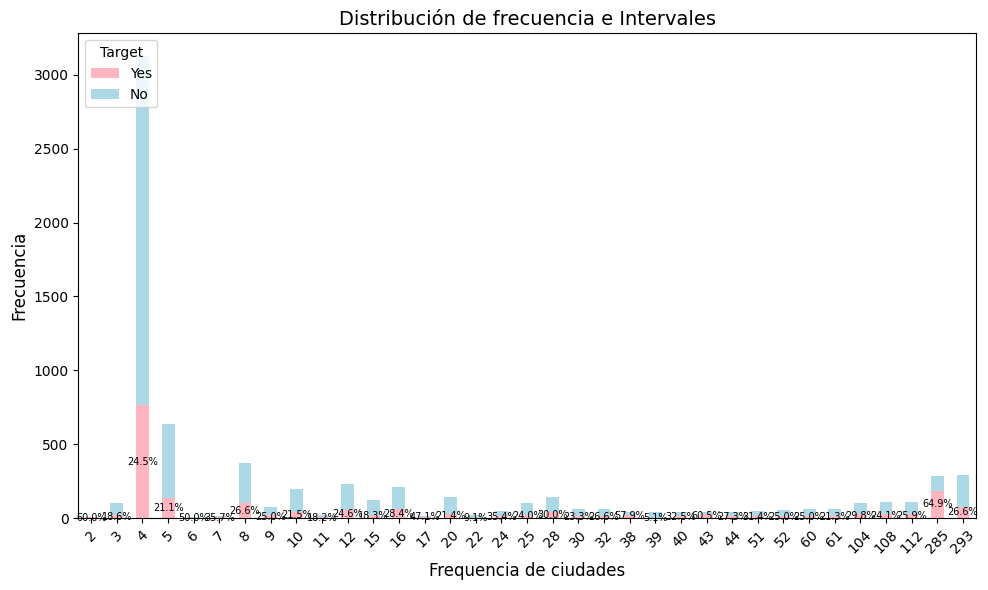

In [ ]:
# Agrupar los datos por categoría e intervalo
grouped_data = data.groupby(['city_freq', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de "bad"
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Frequencia de ciudades', fontsize=12)
ax1.set_title('Distribución de frecuencia e Intervales', fontsize=14)
ax1.legend(['Yes', 'No'], title='Target', loc='upper left')

for i, (index, row) in enumerate(grouped_data.iterrows()):
    total = row['Yes'] + row['No']
    porcentaje_yes = row['Yes'] / total * 100
    height_yes = row['Yes']
    ax1.text(i, height_yes / 2, f'{porcentaje_yes:.1f}%', ha='center', va='center', fontsize=7, color='black')

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
data["Intervalos_edad"] = pd.qcut(data['Age'], q=6)
data["Intervalos_edad"].value_counts()

Intervalos_edad
(18.999, 28.0]    1283
(37.0, 46.0]      1189
(46.0, 55.0]      1163
(55.0, 64.0]      1147
(64.0, 80.0]      1142
(28.0, 37.0]      1119
Name: count, dtype: int64

In [ ]:
data["Intervalos_edad"] = data["Intervalos_edad"].astype(str)


In [ ]:
pd.crosstab(data["Intervalos_edad"], data['Churn Label'], normalize='index')*100

Churn Label             No        Yes
Intervalos_edad                      
(18.999, 28.0]   78.176150  21.823850
(28.0, 37.0]     75.960679  24.039321
(37.0, 46.0]     76.450799  23.549201
(46.0, 55.0]     74.634566  25.365434
(55.0, 64.0]     76.547515  23.452485
(64.0, 80.0]     58.318739  41.681261

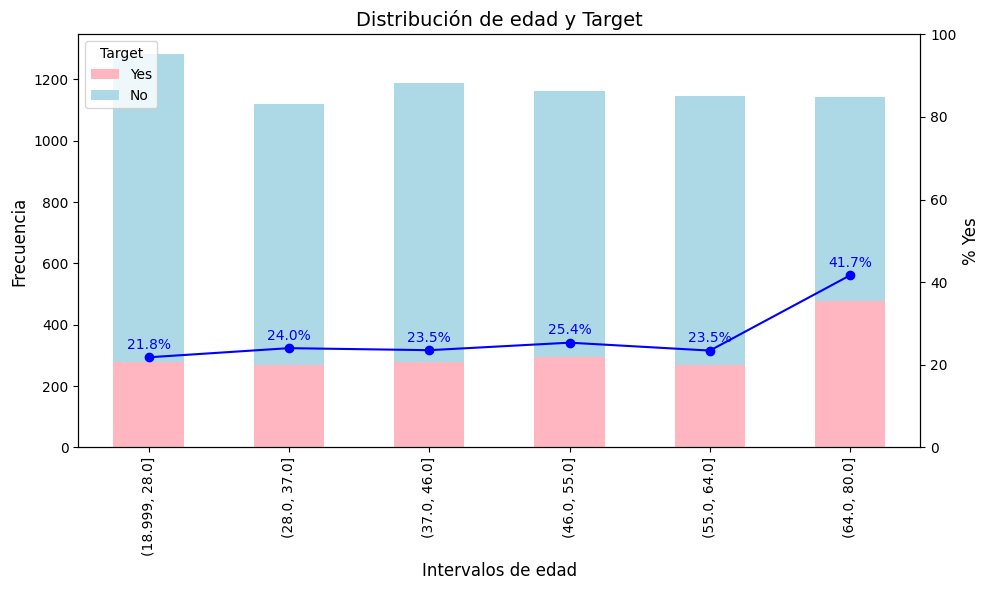

In [ ]:
# Agrupar los datos por categoría e intervalo
grouped_data = data.groupby(['Intervalos_edad', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de "bad"
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Intervalos de edad', fontsize=12)
ax1.set_title('Distribución de edad y Target', fontsize=14)
ax1.legend(['Yes', 'No'], title='Target', loc='upper left')

# Crear un segundo eje Y para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['Yes_percentage'], color='blue', marker='o', label='% Yes')
ax2.set_ylabel('% Yes', fontsize=12)
ax2.set_ylim(0, 100)

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
data['TenureGroup'] = pd.cut(data['Tenure in Months'], bins=[0, 12, 24, 48, 60, 72], labels=['<1 año', '1-2 años', '2-4 años', '4-5 años', '>5 años'])


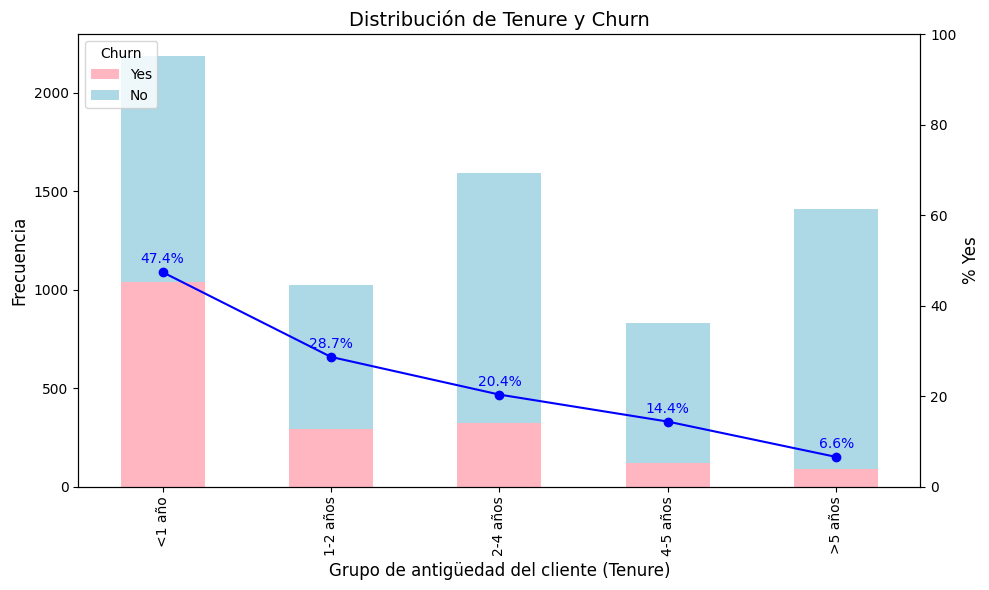

In [ ]:
# Agrupar los datos por TenureGroup y Churn Label
grouped_data = data.groupby(['TenureGroup', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de churn ("Yes")
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Grupo de antigüedad del cliente (Tenure)', fontsize=12)
ax1.set_title('Distribución de Tenure y Churn', fontsize=14)
ax1.legend(['Yes', 'No'], title='Churn', loc='upper left')

# Crear un segundo eje Y para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['Yes_percentage'], color='blue', marker='o', label='% Yes')
ax2.set_ylabel('% Yes', fontsize=12)
ax2.set_ylim(0, 100)

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


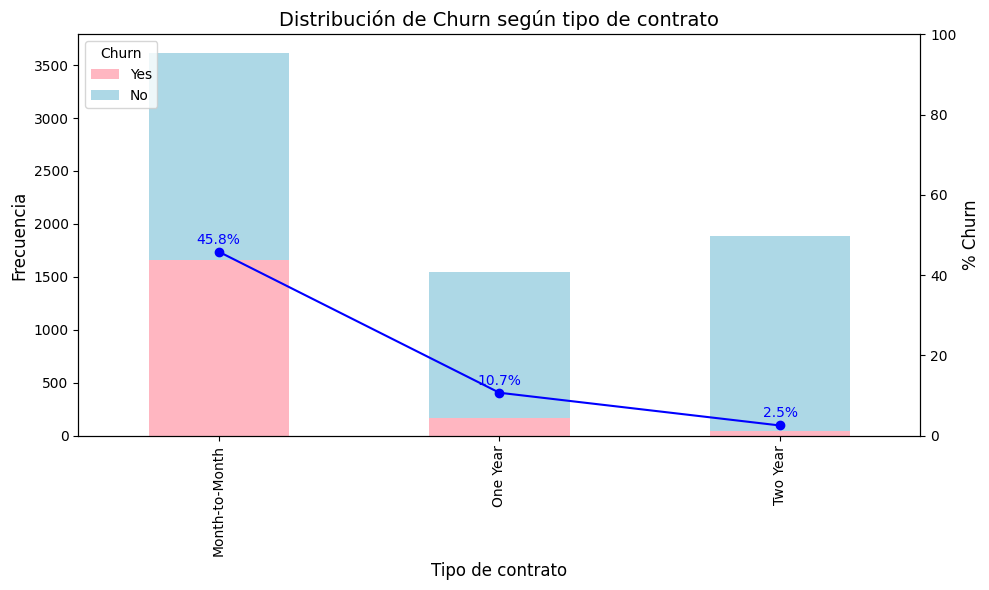

In [ ]:
# Agrupar los datos por tipo de contrato y Churn Label
grouped_data = data.groupby(['Contract', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de churn ("Yes")
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Tipo de contrato', fontsize=12)
ax1.set_title('Distribución de Churn según tipo de contrato', fontsize=14)
ax1.legend(['Yes', 'No'], title='Churn', loc='upper left')

# Crear un segundo eje Y para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['Yes_percentage'], color='blue', marker='o', label='% Yes')
ax2.set_ylabel('% Churn', fontsize=12)
ax2.set_ylim(0, 100)

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Convertir las columnas a 1 (Yes) y 0 (No)
streaming_cols = ['Streaming TV', 'Streaming Movies', 'Streaming Music']

for col in streaming_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# Crear la columna Combo_stream: 1 si todas son 1, caso contrario 0
data['Combo_stream'] = (
    (data['Streaming TV'] == 1) &
    (data['Streaming Movies'] == 1) &
    (data['Streaming Music'] == 1)
).astype(int)


In [ ]:
columns_to_binary = [
    'Married', 'Multiple Lines',
    'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Unlimited Data','Paperless Billing', 'Churn Label']


In [ ]:
for col in columns_to_binary:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

In [ ]:
data['Gender'] = data['Gender'].map({'Female': 1, 'Male': 0})

In [ ]:
data["Intervalos_edad"] = data["Intervalos_edad"].astype(str)
data["TenureGroup"] = data["TenureGroup"].astype(str)
data["Intervalos_edad"] = data["Intervalos_edad"].astype(str)


In [ ]:
data.head()

Gender  Age  Married  Number of Dependents         City  Zip Code  \
0       0   78        0                     0  Los Angeles     90022   
1       1   74        1                     1  Los Angeles     90063   
2       0   71        0                     3  Los Angeles     90065   
3       1   78        1                     1    Inglewood     90303   
4       1   80        1                     1     Whittier     90602   

    Latitude   Longitude  Population  Number of Referrals  ...  Total Refunds  \
0  34.023810 -118.156582       68701                    0  ...           0.00   
1  34.044271 -118.185237       55668                    1  ...           0.00   
2  34.108833 -118.229715       47534                    0  ...          45.61   
3  33.936291 -118.332639       27778                    1  ...          13.43   
4  33.972119 -118.020188       26265                    1  ...           0.00   

  Total Extra Data Charges  Total Revenue  Churn Label  CLTV  \
0                       20          59.65            1  5433   
1                        0        1024.10            1  5302   
2                        0        1910.88            1  3179   
3                        0        2995.07            1  5337   
4                        0        3102.36            1  2793   

             Dependientes  city_freq  Intervalos_edad  TenureGroup  \
0  Grupo sin dependientes        293     (64.0, 80.0]       <1 año   
1   De 1 a 3 dependientes        293     (64.0, 80.0]       <1 año   
2   De 1 a 3 dependientes        293     (64.0, 80.0]     1-2 años   
3   De 1 a 3 dependientes         25     (64.0, 80.0]     2-4 años   
4   De 1 a 3 dependientes         30     (64.0, 80.0]     2-4 años   

   Combo_stream  
0             0  
1             0  
2             1  
3             0  
4             0  

[5 rows x 38 columns]

In [ ]:
data.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'City', 'Zip Code',
       'Latitude', 'Longitude', 'Population', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Avg Monthly Long Distance Charges',
       'Multiple Lines', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Refunds',
       'Total Extra Data Charges', 'Total Revenue', 'Churn Label', 'CLTV',
       'Dependientes', 'city_freq', 'Intervalos_edad', 'TenureGroup',
       'Combo_stream'],
      dtype='object')

In [ ]:
respaldo = data.copy()
#Filtrado de columnas
columns_to_delete = ['City']
data = data.drop(columns_to_delete, axis=1)

##Split

In [ ]:
#Procedemos a dividir la data, en este caso vamos a partir 70% para el train_data, 20% para la val_data y 10% para la test data
train_data, temp_data = train_test_split(data, train_size=0.70, random_state=9, stratify=data[["Churn Label"]])

#Procedemos a obtener el dataset de validació y de test
val_data, test_data = train_test_split(temp_data, train_size=0.7, random_state=9, stratify=temp_data[["Churn Label"]])


In [ ]:
print(f'Longitud del dataset original: {len(data)}')
print(f'Longitud del dataset de entrenamiento: {len(train_data)}')
print(f'Longitud del dataset de validación: {len(val_data)}')
print(f'Longitud del dataset de prueba: {len(test_data)}')

Longitud del dataset original: 7043
Longitud del dataset de entrenamiento: 4930
Longitud del dataset de validación: 1479
Longitud del dataset de prueba: 634


In [ ]:
# train_data = ordinal_encoder.fit_transform(train_data)
# val_data = ordinal_encoder.transform(val_data)
# test_data = ordinal_encoder.transform(test_data)

# # 3. TargetEncoder
# target_encoder = TargetEncoder(cols=targetEncoderColumns)
# train_data[targetEncoderColumns] = target_encoder.fit_transform(train_data[targetEncoderColumns], y_train)
# val_data[targetEncoderColumns] = target_encoder.transform(val_data[targetEncoderColumns])
# test_data[targetEncoderColumns] = target_encoder.transform(test_data[targetEncoderColumns])

# # 4. OneHotEncoder
# # Entrenamos el one hot encoder solo con train_data
# onehot_encoder = OneHotEncoder(cols=oneHotEncoderColumns, use_cat_names=True)

# train_data = onehot_encoder.fit_transform(train_data)
# val_data = onehot_encoder.transform(val_data)
# test_data = onehot_encoder.transform(test_data)

In [ ]:
# Definimos variables para entrenamiento
X_train = train_data.drop(columns=["Churn Label"])
y_train = train_data["Churn Label"]

# Definimos variables para validacion
X_val = val_data.drop(columns=["Churn Label"])
y_val = val_data["Churn Label"]

# Definimos variables para test
X_test = test_data.drop(columns=["Churn Label"])
y_test = test_data["Churn Label"]


# Modelos de machine learning

In [ ]:
# Columnas
ordinal_cols = ["Intervalos_edad", "Dependientes", "TenureGroup"]
targetEncoderColumns = ['Offer', 'Contract','Internet Type']
oneHotEncoderColumns = ['Payment Method']
numerical_cols = X_train.select_dtypes(exclude='object').columns.tolist()
numerical_cols = list(set(numerical_cols) - set(targetEncoderColumns) - set(oneHotEncoderColumns) - set(ordinal_cols))

# === 1. Preprocesamiento manual: ===

ordinal_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='mean')
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()
one_hot_encoder = CatBoostOneHot(cols=oneHotEncoderColumns, use_cat_names=True)
target_encoder = TargetEncoder(cols=targetEncoderColumns)

# === 2. Transformación de los datos: ===

# Target encoding
X_train_target = target_encoder.fit_transform(X_train[targetEncoderColumns], y_train)
X_test_target = target_encoder.transform(X_test[targetEncoderColumns])
X_val_target = target_encoder.transform(X_val[targetEncoderColumns])

# Ordinal
X_train_ordinal = X_train[ordinal_cols].copy()
X_test_ordinal = X_test[ordinal_cols].copy()
X_val_ordinal_temp = X_val[ordinal_cols].copy()

X_train_ordinal = ordinal_imputer.fit_transform(X_train_ordinal)
X_test_ordinal = ordinal_imputer.transform(X_test_ordinal)
X_val_ordinal_temp = ordinal_imputer.transform(X_val_ordinal_temp)

X_train_ordinal = ordinal_encoder.fit_transform(X_train_ordinal)
X_test_ordinal = ordinal_encoder.transform(X_test_ordinal)
X_val_ordinal_temp = ordinal_encoder.transform(X_val_ordinal_temp)

# Numéricas
X_train_numerical = X_train[numerical_cols].copy()
X_test_numerical = X_test[numerical_cols].copy()
X_val_numerical = X_val[numerical_cols].copy()

X_train_numerical = numerical_imputer.fit_transform(X_train_numerical)
X_test_numerical = numerical_imputer.transform(X_test_numerical)
X_val_numerical = numerical_imputer.transform(X_val_numerical)

X_train_numerical = scaler.fit_transform(X_train_numerical)
X_test_numerical = scaler.transform(X_test_numerical)
X_val_numerical = scaler.transform(X_val_numerical)

# One-hot
X_train_one_hot = one_hot_encoder.fit_transform(X_train[oneHotEncoderColumns])
X_test_one_hot = one_hot_encoder.transform(X_test[oneHotEncoderColumns])
X_val_one_hot = one_hot_encoder.transform(X_val[oneHotEncoderColumns])

# === 3. Nombres de columnas: ===

target_encoded_names = [f"{col}_target" for col in targetEncoderColumns]
ordinal_column_names = [f"{col}_ordinal" for col in ordinal_cols]
numerical_column_names = [f"{col}_scaled" for col in numerical_cols]
one_hot_column_names = one_hot_encoder.get_feature_names_out(oneHotEncoderColumns)

all_column_names = target_encoded_names + ordinal_column_names + numerical_column_names + list(one_hot_column_names)

# === 4. Combinamos y convertimos en DataFrames: ===

X_train_processed = pd.DataFrame(np.hstack([
    X_train_target,
    X_train_ordinal,
    X_train_numerical,
    X_train_one_hot.values
]), columns=all_column_names)

X_test_processed = pd.DataFrame(np.hstack([
    X_test_target,
    X_test_ordinal,
    X_test_numerical,
    X_test_one_hot.values
]), columns=all_column_names)

X_val_processed = pd.DataFrame(np.hstack([
    X_val_target,
    X_val_ordinal_temp,
    X_val_numerical,
    X_val_one_hot.values
]), columns=all_column_names)


In [ ]:
# Elimina el sufijo '_scaled' de todas las columnas del DataFrame
X_train_processed.columns = X_train_processed.columns.str.replace('_scaled', '', regex=False)
X_test_processed.columns = X_test_processed.columns.str.replace('_scaled', '', regex=False)
X_val_processed.columns = X_val_processed.columns.str.replace('_scaled', '', regex=False)

In [ ]:
# Elimina el sufijo '_target' de todas las columnas del DataFrame
X_train_processed.columns = X_train_processed.columns.str.replace('_target', '', regex=False)
X_test_processed.columns = X_test_processed.columns.str.replace('_target', '', regex=False)
X_val_processed.columns = X_val_processed.columns.str.replace('_target', '', regex=False)

In [ ]:
#Columnas utilizadas en el modelado
X_train.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'Zip Code',
       'Latitude', 'Longitude', 'Population', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Avg Monthly Long Distance Charges',
       'Multiple Lines', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Refunds',
       'Total Extra Data Charges', 'Total Revenue', 'CLTV', 'Dependientes',
       'city_freq', 'Intervalos_edad', 'TenureGroup', 'Combo_stream'],
      dtype='object')

## *Regresión Logistica*

### Sin pipeline

In [ ]:
# === COLUMNAS SEGÚN EL ENCODER ===
ordinal_cols = ["Intervalos_edad", "Dependientes", "TenureGroup"]
targetEncoderColumns = ['Offer', 'Contract','Internet Type']
oneHotEncoderColumns = ['Payment Method']
numerical_cols = X_train.select_dtypes(exclude='object').columns.tolist()

# Evitar columnas duplicadas
numerical_cols = list(set(numerical_cols) - set(targetEncoderColumns) - set(oneHotEncoderColumns) - set(ordinal_cols))

# Ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_cols),
    ('numeric', numerical_transformer, numerical_cols)
], remainder='passthrough')

# Modelo de regresión logística
log_reg = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)

# Pipeline de regresión
logreg_pipeline = ImbPipeline(steps=[
    ('target_encoder', TargetEncoder(cols=targetEncoderColumns)),
    ('onehot_encoder', CatBoostOneHot(cols=oneHotEncoderColumns, use_cat_names=True)),
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('classifier', log_reg)
])

# Hiperparámetros para GridSearch
logreg_param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100, 200, 500],
}

# GridSearch
logreg_grid_search = GridSearchCV(
    logreg_pipeline,
    param_grid=logreg_param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Entrenamiento
logreg_grid_search.fit(X_train_processed, y_train)

# Mejor modelo
best_logreg_model = logreg_grid_search.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits


#### Resultados

In [ ]:
print("Mejores parámetros:", logreg_grid_search.best_params_)

Mejores parámetros: {'classifier__C': 0.01, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


##### Train

In [ ]:
# === Predicción sobre conjunto de validación ===
y_pred = logreg_grid_search.predict(X_train_processed)

# === Evaluación ===
print("=== ENTRENAMIENTO ===")
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

=== ENTRENAMIENTO ===
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      3622
           1       0.53      0.85      0.65      1308

    accuracy                           0.76      4930
   macro avg       0.73      0.79      0.74      4930
weighted avg       0.82      0.76      0.78      4930

[[2653  969]
 [ 201 1107]]


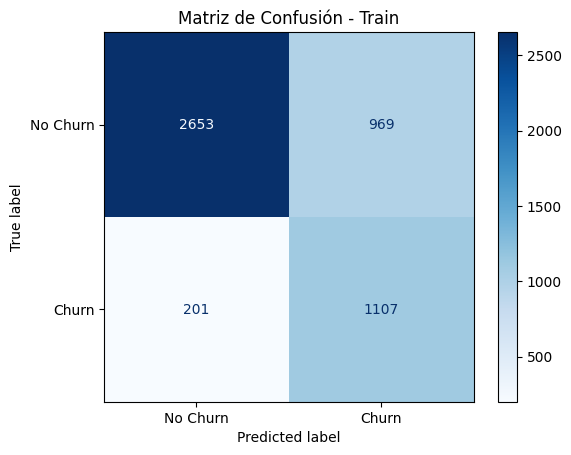

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Matriz de confusión para train ===
ConfusionMatrixDisplay.from_predictions(
    y_true=y_train,
    y_pred=y_pred,
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Train")
plt.show()

##### Validacion

In [ ]:
# === Predicción sobre conjunto de validación ===
y_pred = logreg_grid_search.predict(X_val_processed)

# === Evaluación ===
print("=== VALIDACIÓN ===")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

=== VALIDACIÓN ===
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1086
           1       0.55      0.84      0.66       393

    accuracy                           0.77      1479
   macro avg       0.74      0.80      0.75      1479
weighted avg       0.83      0.77      0.79      1479

[[815 271]
 [ 63 330]]


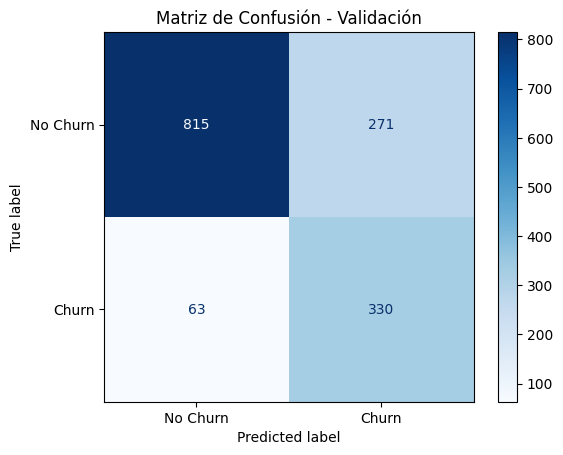

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Matriz de confusión para validacion ===
ConfusionMatrixDisplay.from_predictions(
    y_true=y_val,
    y_pred=y_pred,
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Validación")
plt.show()

##### Prueba

In [ ]:
# === Predicción sobre conjunto de validación ===
y_pred = logreg_grid_search.predict(X_test_processed)

# === Evaluación ===
print("=== TEST ===")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

=== TEST ===
              precision    recall  f1-score   support

           0       0.93      0.77      0.85       466
           1       0.57      0.85      0.68       168

    accuracy                           0.79       634
   macro avg       0.75      0.81      0.76       634
weighted avg       0.84      0.79      0.80       634

[[360 106]
 [ 26 142]]


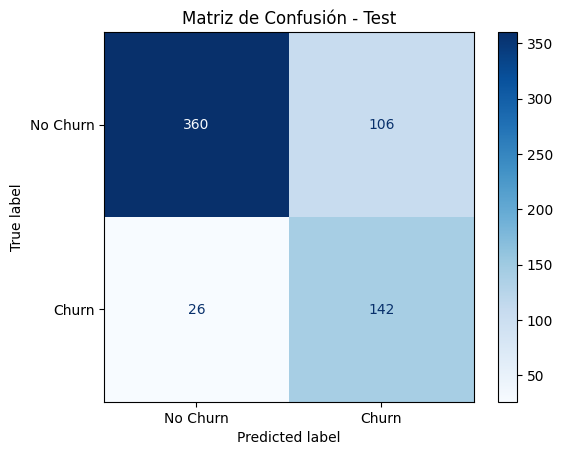

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Matriz de confusión para test ===
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred,
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Test")
plt.show()

##### Explicabilidad

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

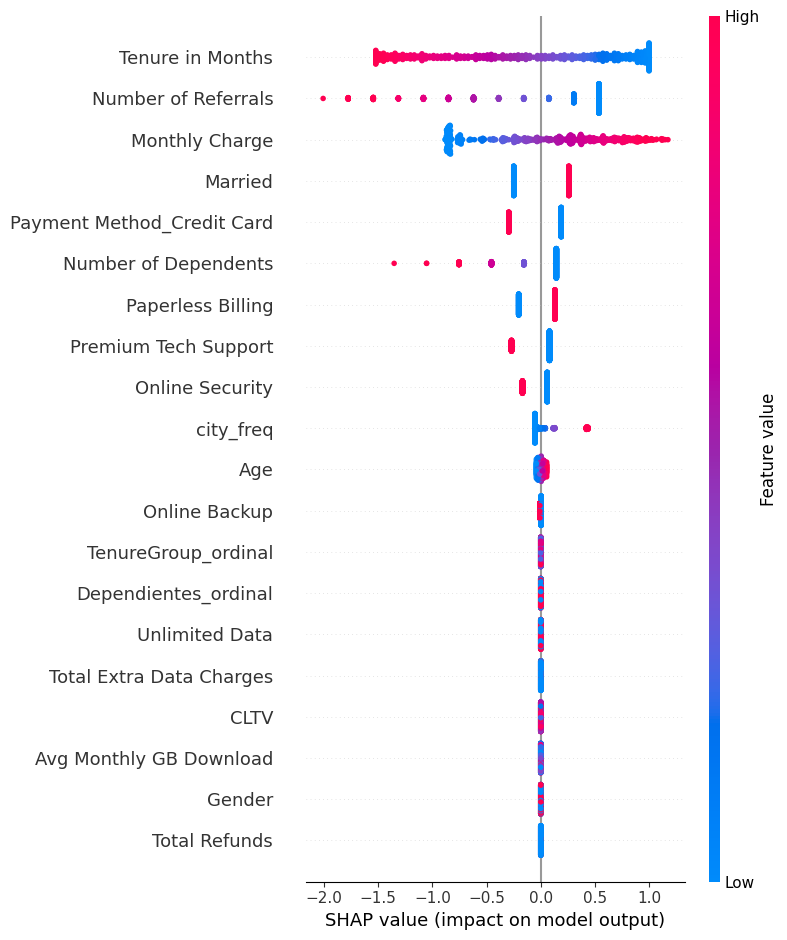

In [ ]:
# Paso 2: Crear el explainer para SHAP con solo el clasificador (sin SMOTE)
explainer = shap.Explainer(best_logreg_model.named_steps['classifier'], X_train_processed)

# Paso 3: Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(X_test_processed)

# Paso 4: Visualización - Resumen de la importancia de las características
shap.summary_plot(shap_values, X_test_processed)

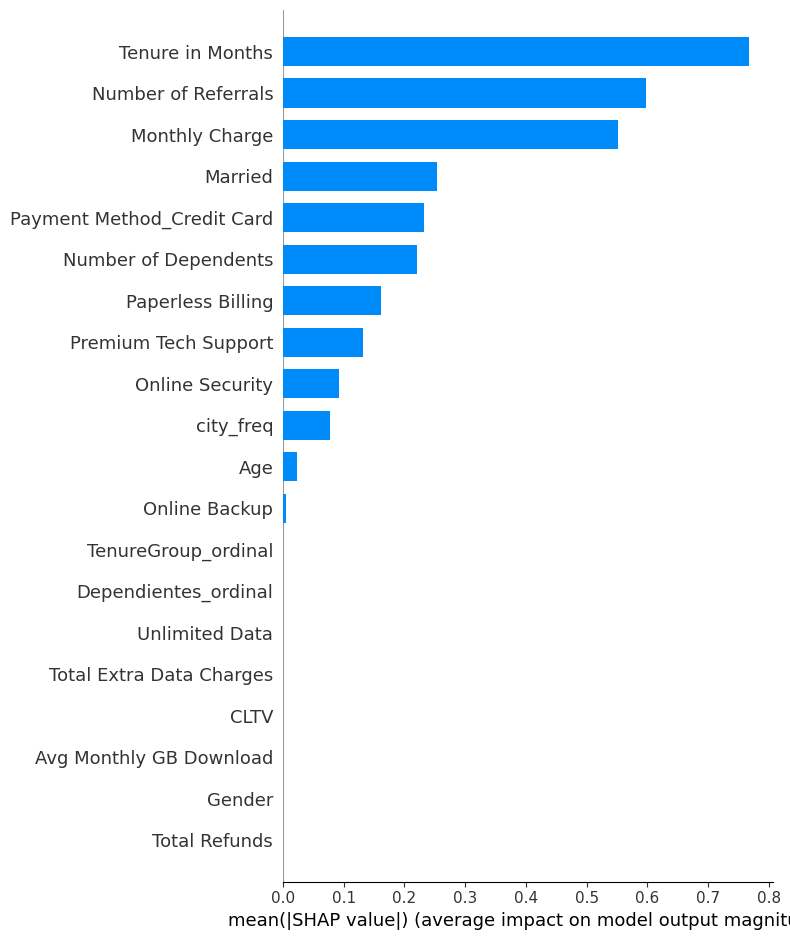

In [ ]:
plt.figure(figsize=(20, 8))
shap.summary_plot(shap_values.values, features=X_test_processed.columns, plot_type="bar")

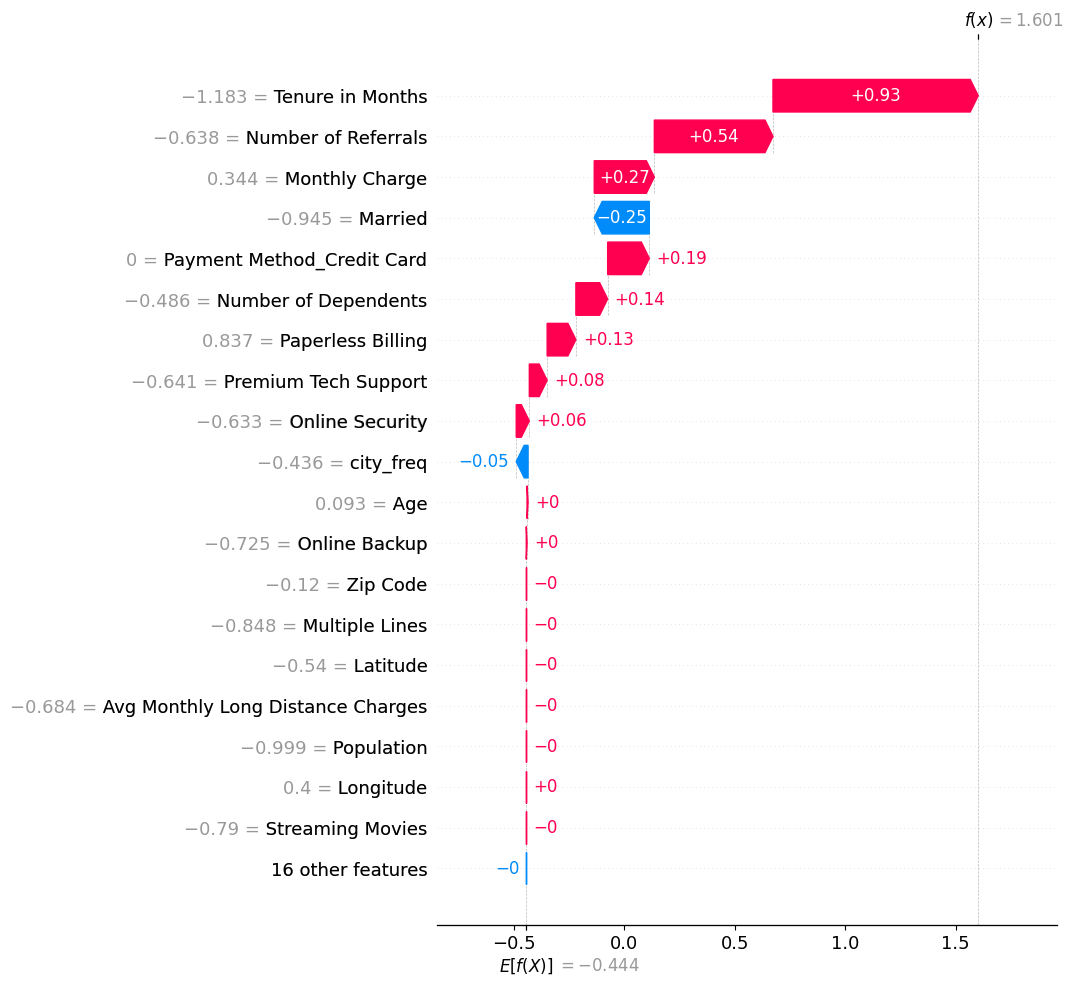

In [ ]:
shap.plots.waterfall(shap_values[1], max_display=20)

### Con pipeline

In [ ]:
# === COLUMNAS SEGÚN EL ENCODER ===
ordinal_cols = ["Intervalos_edad", "Dependientes", "TenureGroup"]
targetEncoderColumns = ['Offer', 'Contract','Internet Type']
oneHotEncoderColumns = ['Payment Method']
numerical_cols = X_train.select_dtypes(exclude='object').columns.tolist()

# Evitar columnas duplicadas
numerical_cols = list(set(numerical_cols) - set(targetEncoderColumns) - set(oneHotEncoderColumns) - set(ordinal_cols))

# Ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_cols),
    ('numeric', numerical_transformer, numerical_cols)
], remainder='passthrough')

# Modelo de regresión logística
log_reg = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)

# Pipeline de regresión
logreg_pipeline = ImbPipeline(steps=[
    ('target_encoder', TargetEncoder(cols=targetEncoderColumns)),
    ('onehot_encoder', CatBoostOneHot(cols=oneHotEncoderColumns, use_cat_names=True)),
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('classifier', log_reg)
])

# Hiperparámetros para GridSearch
logreg_param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100, 200, 500],
}

# GridSearch
logreg_grid_search = GridSearchCV(
    logreg_pipeline,
    param_grid=logreg_param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Entrenamiento
logreg_grid_search.fit(X_train_processed, y_train)

# Mejor modelo
best_logreg_model = logreg_grid_search.best_estimator_

## *XGBOOST*

In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder as CatBoostOneHot
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# # === COLUMNAS SEGÚN EL ENCODER ===
# ordinal_cols = ["Intervalos_edad", "Dependientes", "TenureGroup"]
# targetEncoderColumns = ['Offer', 'Contract','Internet Type']
# oneHotEncoderColumns = ['Payment Method']
# numerical_cols = X_train.select_dtypes(exclude='object').columns.tolist()

# # Evitar columnas duplicadas
# numerical_cols = list(set(numerical_cols) - set(targetEncoderColumns) - set(oneHotEncoderColumns) - set(ordinal_cols))

# # Ordinal
# ordinal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
# ])

# # Numéricas
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# # ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[
#     ('ordinal', ordinal_transformer, ordinal_cols),
#     ('numeric', numerical_transformer, numerical_cols)
# ], remainder='passthrough')

# XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# pipeline
pipeline = ImbPipeline(steps=[
    # ('target_encoder', TargetEncoder(cols=targetEncoderColumns)),
    # ('onehot_encoder', CatBoostOneHot(cols=oneHotEncoderColumns, use_cat_names=True)),
    # ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('classifier', xgb_clf)
])

# parametros
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.6, 0.9],
    'classifier__colsample_bytree': [0.6, 0.9]
}

# usamos gridsearchv para tuning de hyperparemtros
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='recall',  # Priorizamos recall para este problema
    cv=3,
    n_jobs=-1,
    verbose=2
)

# entrenamiento
grid_search.fit(X_train_processed, y_train)

# mejor modelo
best_model = grid_search.best_estimator_



Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:53:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.9}


In [ ]:
y_pred = best_model.predict(X_val_processed)

# EVALUACIÓN
print("=== VALIDACIÓN ===")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


=== VALIDACIÓN ===
              precision    recall  f1-score   support

           0       0.98      0.49      0.66      1086
           1       0.41      0.98      0.58       393

    accuracy                           0.62      1479
   macro avg       0.70      0.74      0.62      1479
weighted avg       0.83      0.62      0.64      1479

[[537 549]
 [  9 384]]


In [ ]:
y_pred = best_model.predict(X_test_processed)

# === EVALUACIÓN ===
print("=== Test ===")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


=== Test ===
              precision    recall  f1-score   support

           0       0.99      0.48      0.65       466
           1       0.41      0.98      0.58       168

    accuracy                           0.62       634
   macro avg       0.70      0.73      0.61       634
weighted avg       0.83      0.62      0.63       634

[[226 240]
 [  3 165]]


## LightGBM

### Sin pipeline en preprocesado

In [ ]:
# pipeline
model = lgb.LGBMClassifier(
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('classifier', model)
])

# parametras
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10, -1],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.7, 1.0],
    'classifier__colsample_bytree': [0.7, 1.0]
}

# GridSearchCV con validación cruzada
grid_searchLGBM = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# === Entrenamiento con grid search ===
grid_searchLGBM.fit(X_train_processed, y_train)

# Mejor modelo
best_LGBM_model = grid_searchLGBM.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1811, number of negative: 3622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4219
[LightGBM] [Info] Number of data points in the train set: 5433, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


#### Resultados

In [ ]:
# === Resultados ===
print("Mejores parámetros:", grid_searchLGBM.best_params_)

Mejores parámetros: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__subsample': 0.7}


##### Resultados con datos de entrenamiento

In [ ]:
# === Predicción sobre conjunto de validación ===
y_pred = grid_searchLGBM.predict(X_train_processed)

# === Evaluación ===
print("=== ENTRENAMIENTO ===")
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

=== ENTRENAMIENTO ===
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3622
           1       0.81      0.99      0.89      1308

    accuracy                           0.94      4930
   macro avg       0.91      0.96      0.93      4930
weighted avg       0.95      0.94      0.94      4930

[[3327  295]
 [  10 1298]]


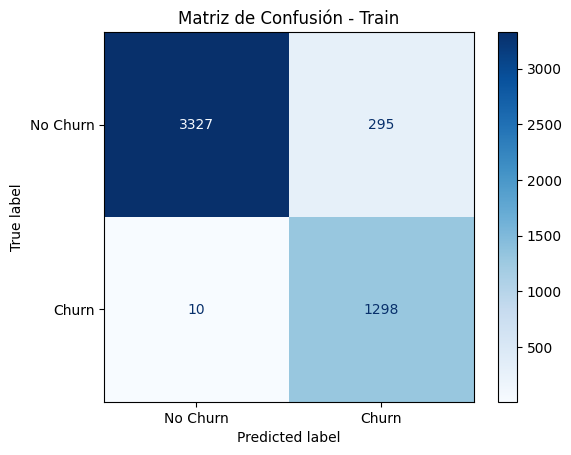

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Matriz de confusión para train ===
ConfusionMatrixDisplay.from_predictions(
    y_true=y_train,
    y_pred=y_pred,
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Train")
plt.show()

##### Resultados con datos de validación

In [ ]:
# === Predicción sobre conjunto de validación ===
y_pred = grid_searchLGBM.predict(X_val_processed)

# === Evaluación ===
print("=== VALIDACIÓN ===")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

=== VALIDACIÓN ===
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1086
           1       0.67      0.83      0.74       393

    accuracy                           0.85      1479
   macro avg       0.80      0.84      0.82      1479
weighted avg       0.86      0.85      0.85      1479

[[926 160]
 [ 66 327]]


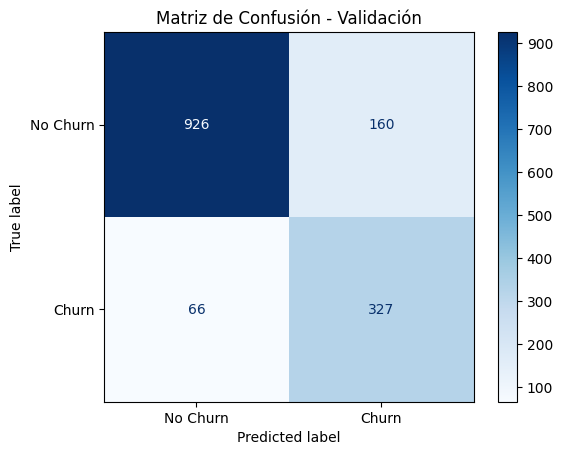

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Matriz de confusión para validacion ===
ConfusionMatrixDisplay.from_predictions(
    y_true=y_val,
    y_pred=y_pred,
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Validación")
plt.show()

##### Resultados con datos de prueba

In [ ]:
# === Predicción sobre conjunto de validación ===
y_pred = grid_searchLGBM.predict(X_test_processed)

# === Evaluación ===
print("=== TEST ===")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

=== TEST ===
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       466
           1       0.70      0.80      0.75       168

    accuracy                           0.85       634
   macro avg       0.81      0.84      0.82       634
weighted avg       0.86      0.85      0.86       634

[[407  59]
 [ 33 135]]


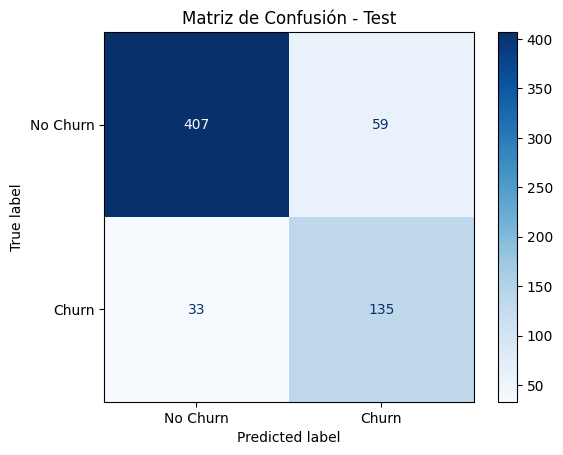

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Matriz de confusión para test ===
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred,
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Test")
plt.show()

##### Explicabilidad

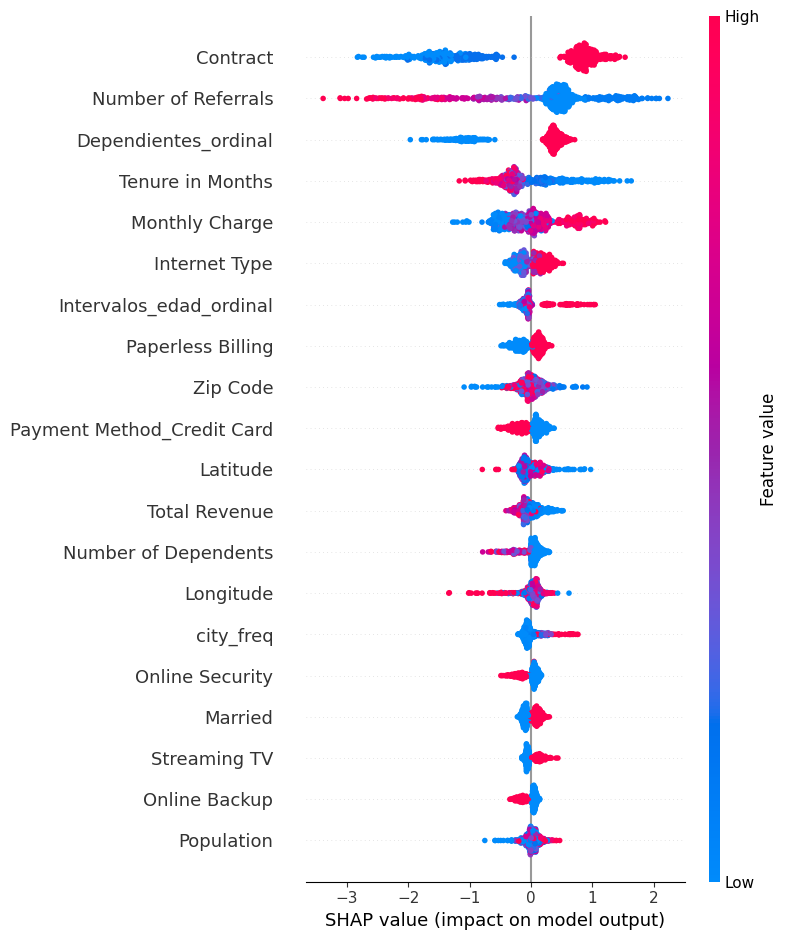

In [ ]:
# Crear el explainer para SHAP con solo el clasificador
explainer = shap.Explainer(best_LGBM_model.named_steps['classifier'], X_train_processed)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(X_test_processed,check_additivity=False)

# Visualización - Resumen de la importancia de las características
shap.summary_plot(shap_values, X_test_processed)

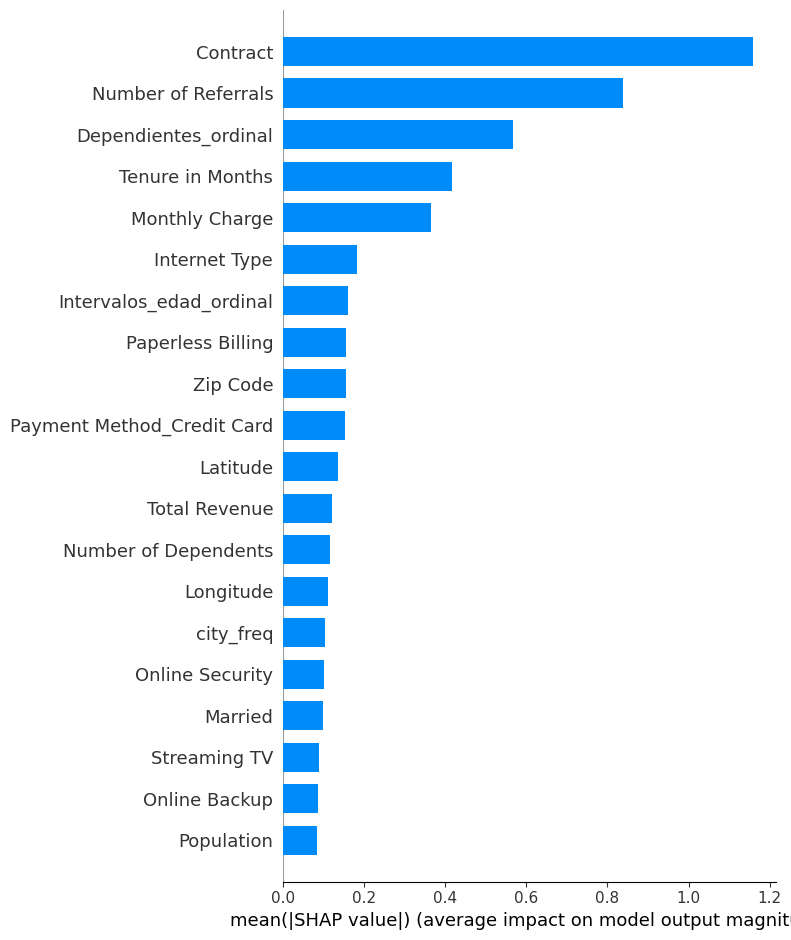

In [ ]:
plt.figure(figsize=(20, 8))
shap.summary_plot(shap_values.values, features=X_test_processed.columns, plot_type="bar")

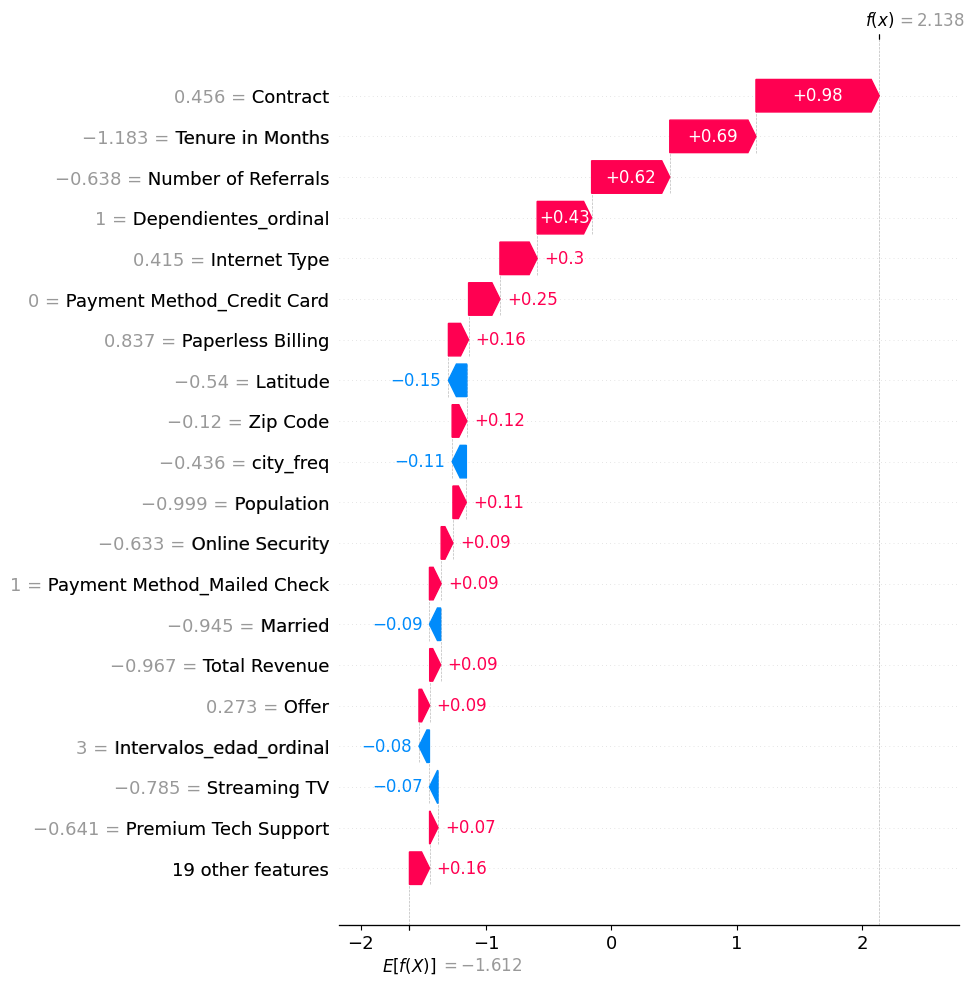

In [ ]:
shap.plots.waterfall(shap_values[1], max_display=20)

### Con pipeline

In [ ]:
# 1. Ordinal Encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# 2. Target Encoder
target_encoder = TargetEncoder(cols=targetEncoderColumns)

# 3. OneHotEncoder
onehot_encoder = CatBoostOneHot(cols=oneHotEncoderColumns, use_cat_names=True)

# 4. Numerical
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 5. ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_transformer, ordinal_cols),
    ('numeric', numerical_transformer, numerical_cols)
], remainder='passthrough')

# pipeline
model = lgb.LGBMClassifier(
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

pipeline = ImbPipeline(steps=[
    ('target_encoder', target_encoder),
    ('onehot_encoder', onehot_encoder),
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('classifier', model)
])
# parametras
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [5, 10, -1],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.7, 1.0],
    'classifier__colsample_bytree': [0.7, 1.0]
}

# GridSearchCV con validación cruzada
grid_searchLGBM = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# === Entrenamiento con grid search ===
grid_searchLGBM.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Info] Number of positive: 1811, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4219
[LightGBM] [Info] Number of data points in the train set: 5433, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('target_encoder',
                                        TargetEncoder(cols=['Offer', 'Contract',
                                                            'Internet Type'])),
                                       ('onehot_encoder',
                                        OneHotEncoder(cols=['Payment Method'],
                                                      use_cat_names=True)),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('or...
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.5)),
                                       ('classifier',
                                        LGBMClassifier(random_state=42,
                                                       scale_pos_weight=2.7691131498470947))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.7, 1.0],
                         'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [5, 10, -1],
                         'classifier__n_estimators': [50, 100],
                         'classifier__subsample': [0.7, 1.0]},
             scoring='f1', verbose=2)

In [ ]:
# === Predicción sobre conjunto de validación ===
y_pred = grid_searchLGBM.predict(X_test)

# === Evaluación ===
print("=== TEST ===")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

=== TEST ===
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       466
           1       0.71      0.80      0.75       168

    accuracy                           0.86       634
   macro avg       0.82      0.84      0.83       634
weighted avg       0.87      0.86      0.86       634

[[412  54]
 [ 34 134]]


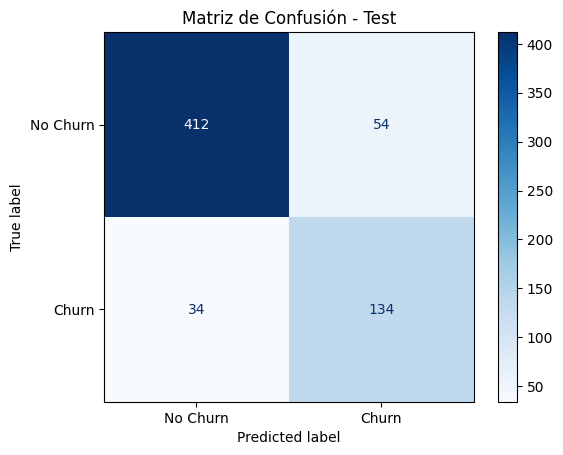

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Matriz de confusión para test ===
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred,
    display_labels=["No Churn", "Churn"],
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Test")
plt.show()

#  2do. Modelo XGBOOST con diferentes features

# 1. import libraries

In [ ]:
# data manipulation and plotting tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data processing
# from category_encoders.one_hot import OneHotEncoder
# from category_encoders.ordinal import OrdinalEncoder
# from category_encoders.target_encoder import TargetEncoder
# from sklearn.preprocessing import MinMaxScaler, RobustScaler

# algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# model selection tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# explainability
import shap

# 2. Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/churn.csv")

In [ ]:
data

Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0     8779-QRDMV    Male   78       No            Yes      No         No   
1     7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2     1658-BYGOY    Male   71       No            Yes      No        Yes   
3     4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4     4846-WHAFZ  Female   80       No            Yes     Yes        Yes   
...          ...     ...  ...      ...            ...     ...        ...   
7038  2569-WGERO  Female   30       No             No      No         No   
7039  6840-RESVB    Male   38       No             No     Yes        Yes   
7040  2234-XADUH  Female   30       No             No     Yes        Yes   
7041  4801-JZAZL  Female   32       No             No     Yes        Yes   
7042  3186-AJIEK    Male   44       No             No      No         No   

      Number of Dependents        Country       State  ...  \
0                        0  United States  California  ...   
1                        1  United States  California  ...   
2                        3  United States  California  ...   
3                        1  United States  California  ...   
4                        1  United States  California  ...   
...                    ...            ...         ...  ...   
7038                     0  United States  California  ...   
7039                     2  United States  California  ...   
7040                     2  United States  California  ...   
7041                     2  United States  California  ...   
7042                     0  United States  California  ...   

     Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                          20                         0.00          59.65   
1                           0                       390.80        1024.10   
2                           0                       203.94        1910.88   
3                           0                       494.00        2995.07   
4                           0                       234.21        3102.36   
...                       ...                          ...            ...   
7038                        0                      1639.44        3039.53   
7039                        0                       865.20        2807.47   
7040                        0                      2135.52        9453.04   
7041                        0                         0.00         319.21   
7042                        0                      2043.36        8887.86   

      Satisfaction Score  Customer Status Churn Label Churn Score  CLTV  \
0                      3          Churned         Yes          91  5433   
1                      3          Churned         Yes          69  5302   
2                      2          Churned         Yes          81  3179   
3                      2          Churned         Yes          88  5337   
4                      2          Churned         Yes          67  2793   
...                  ...              ...         ...         ...   ...   
7038                   5           Stayed          No          45  5306   
7039                   3           Stayed          No          59  2140   
7040                   4           Stayed          No          71  5560   
7041                   4           Stayed          No          59  2793   
7042                   4           Stayed          No          38  5097   

       Churn Category                  Churn Reason  
0          Competitor  Competitor offered more data  
1          Competitor  Competitor made better offer  
2          Competitor  Competitor made better offer  
3     Dissatisfaction     Limited range of services  
4               Price            Extra data charges  
...               ...                           ...  
7038              NaN                           NaN  
7039              NaN                           NaN  
7040              NaN              

# 3. Exploratory Data Analysis

In [ ]:
# Your code here. Exploratory data analysis can be done before splitting, but do not transform the dataset before splitting.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

In [ ]:
def analizar_valores_faltantes(data):
    valores_faltantes = data.isnull().sum()
    porcentaje = (valores_faltantes / len(data)) * 100

    datos_faltantes = pd.DataFrame({
        'Valores Faltantes': valores_faltantes,
        'Porcentaje': porcentaje
    })

    return datos_faltantes.sort_values('Porcentaje', ascending=False)

In [ ]:
print("Análisis de Valores Faltantes:")
print(analizar_valores_faltantes(data))

Análisis de Valores Faltantes:
                                   Valores Faltantes  Porcentaje
Churn Reason                                    5174   73.463013
Churn Category                                  5174   73.463013
Offer                                           3877   55.047565
Internet Type                                   1526   21.666903
Senior Citizen                                     0    0.000000
Married                                            0    0.000000
Age                                                0    0.000000
Under 30                                           0    0.000000
Country                                            0    0.000000
State                                              0    0.000000
City                                               0    0.000000
Zip Code                                           0    0.000000
Latitude                                           0    0.000000
Longitude                                          0    0.0

In [ ]:
data.describe()


Age  Number of Dependents      Zip Code     Latitude  \
count  7043.000000           7043.000000   7043.000000  7043.000000   
mean     46.509726              0.468692  93486.070567    36.197455   
std      16.750352              0.962802   1856.767505     2.468929   
min      19.000000              0.000000  90001.000000    32.555828   
25%      32.000000              0.000000  92101.000000    33.990646   
50%      46.000000              0.000000  93518.000000    36.205465   
75%      60.000000              0.000000  95329.000000    38.161321   
max      80.000000              9.000000  96150.000000    41.962127   

         Longitude     Population  Number of Referrals  Tenure in Months  \
count  7043.000000    7043.000000          7043.000000       7043.000000   
mean   -119.756684   22139.603294             1.951867         32.386767   
std       2.154425   21152.392837             3.001199         24.542061   
min    -124.301372      11.000000             0.000000          1.000000   
25%    -121.788090    2344.000000             0.000000          9.000000   
50%    -119.595293   17554.000000             0.000000         29.000000   
75%    -117.969795   36125.000000             3.000000         55.000000   
max    -114.192901  105285.000000            11.000000         72.000000   

       Avg Monthly Long Distance Charges  Avg Monthly GB Download  \
count                        7043.000000              7043.000000   
mean                           22.958954                20.515405   
std                            15.448113                20.418940   
min                             0.000000                 0.000000   
25%                             9.210000                 3.000000   
50%                            22.890000                17.000000   
75%                            36.395000                27.000000   
max                            49.990000                85.000000   

       Monthly Charge  Total Charges  Total Refunds  Total Extra Data Charges  \
count     7043.000000    7043.000000    7043.000000               7043.000000   
mean        64.761692    2280.381264       1.962182                  6.860713   
std         30.090047    2266.220462       7.902614                 25.104978   
min         18.250000      18.800000       0.000000                  0.000000   
25%         35.500000     400.150000       0.000000                  0.000000   
50%         70.350000    1394.550000       0.000000                  0.000000   
75%         89.850000    3786.600000       0.000000                  0.000000   
max        118.750000    8684.800000      49.790000                150.000000   

       Total Long Distance Charges  Total Revenue  Satisfaction Score  \
count                  7043.000000    7043.000000         7043.000000   
mean                    749.099262    3034.379056            3.244924   
std                     846.660055    2865.204542            1.201657   
min                       0.000000      21.360000            1.000000   
25%                      70.545000     605.610000            3.000000   
50%                     401.440000    2108.640000            3.000000   
75%                    1191.100000    4801.145000            4.000000   
max                    3564.720000   11979.340000            5.000000   

       Churn Score         CLTV  
count  7043.000000  7043.000000  
mean     58.505040  4400.295755  
std      21.170031  1183.057152  
min       5.000000  2003.000000  
25%      40.000000  3469.000000  
50%      61.000000  4527.000000  
75%      75.500000  5380.500000  
max      96.000000  6500.000000

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


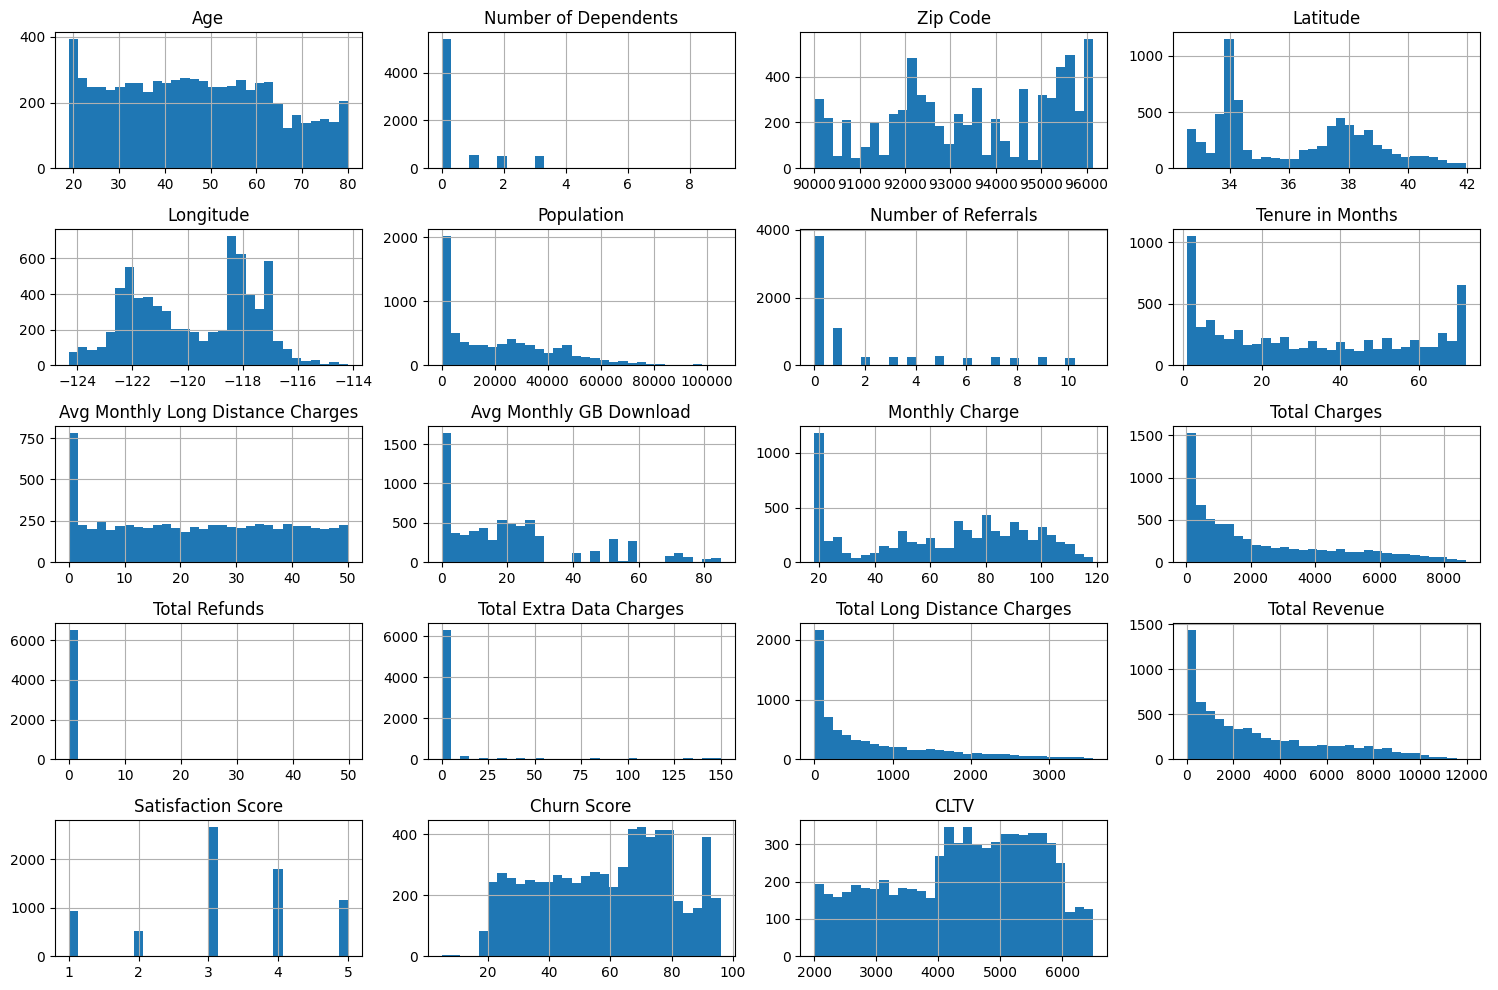

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


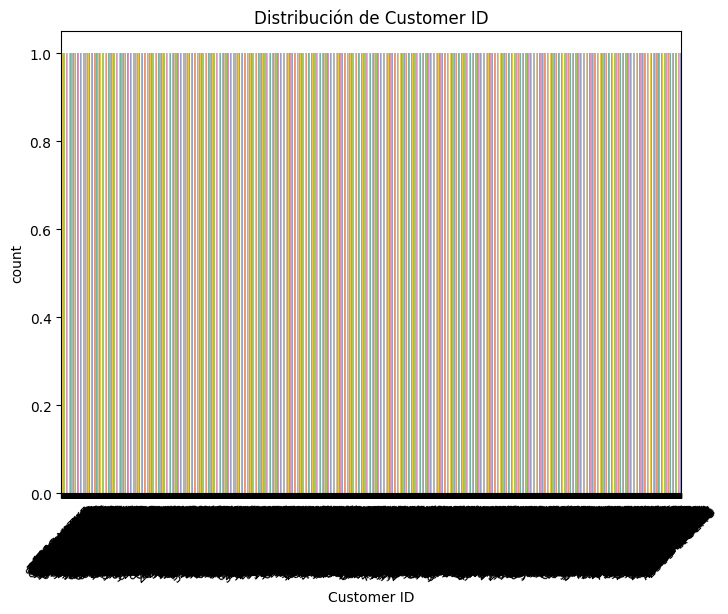

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


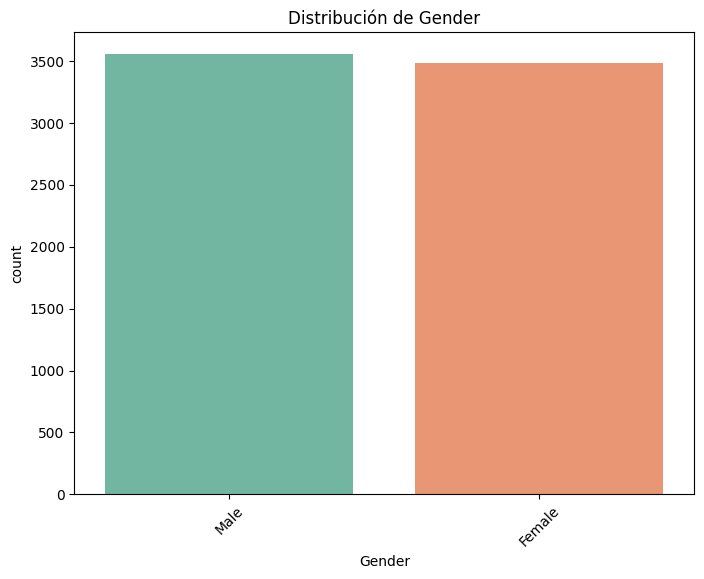

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


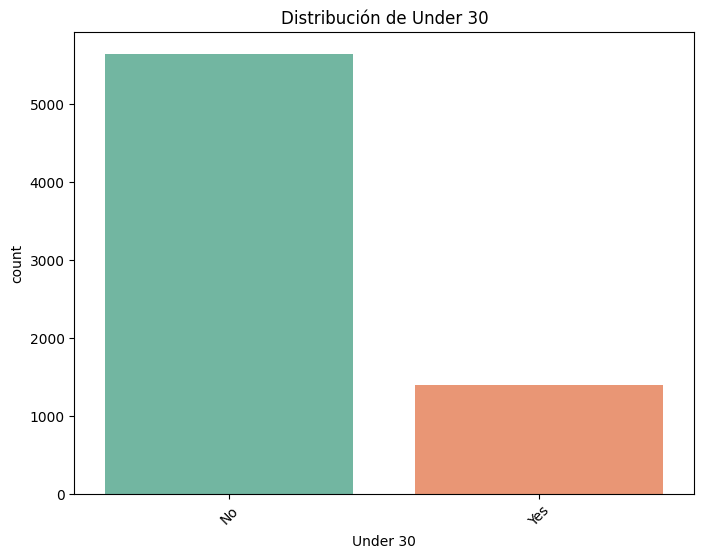

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


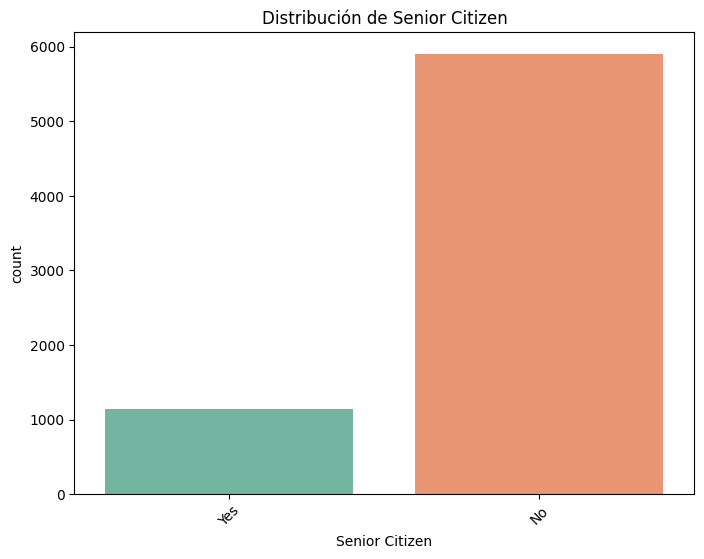

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


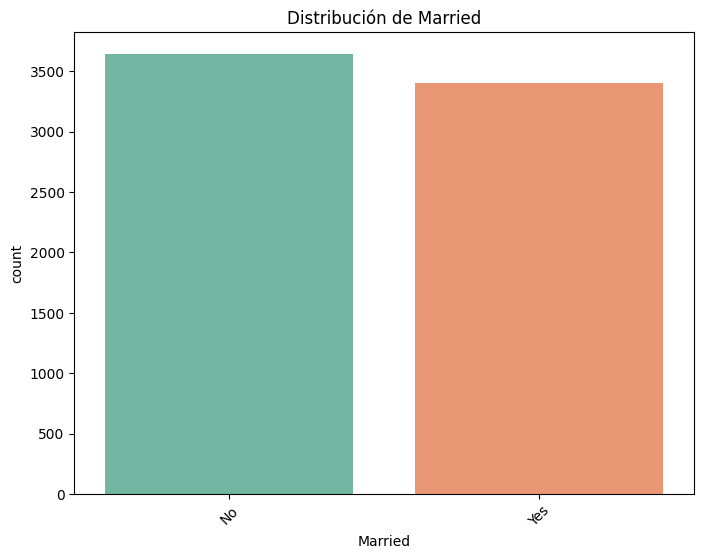

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


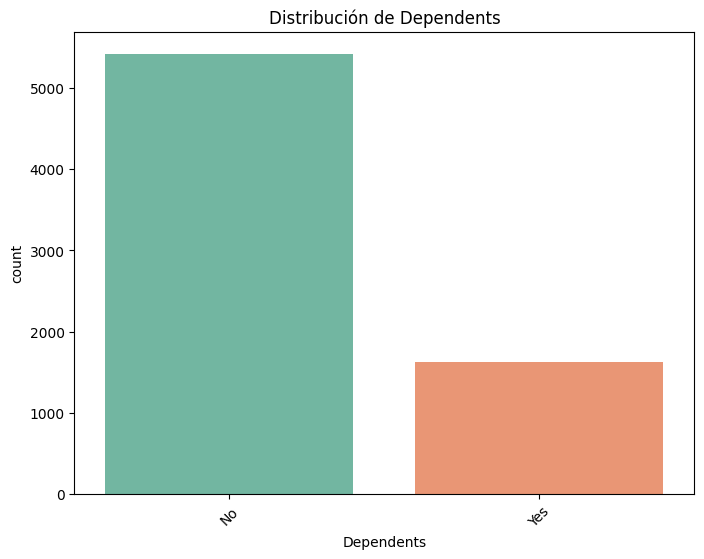

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


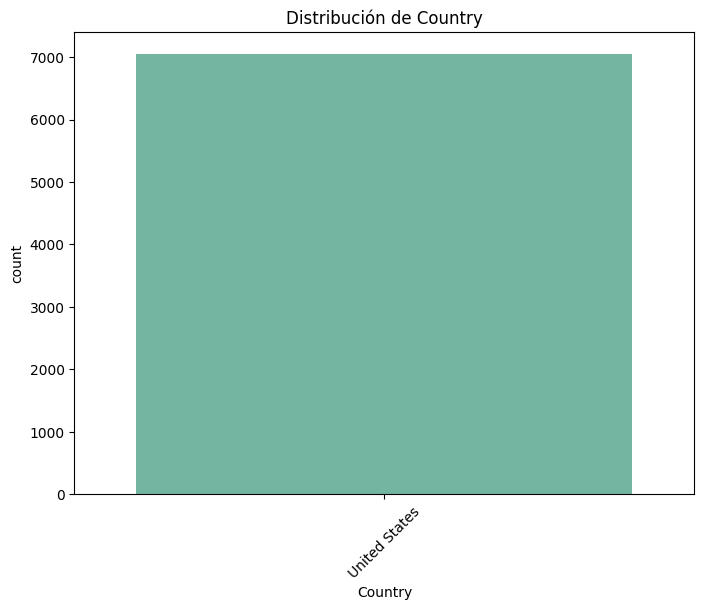

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


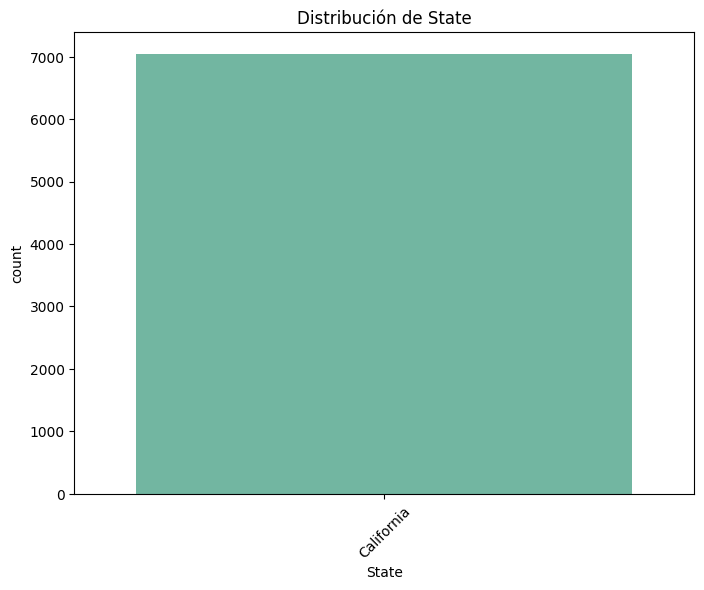

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


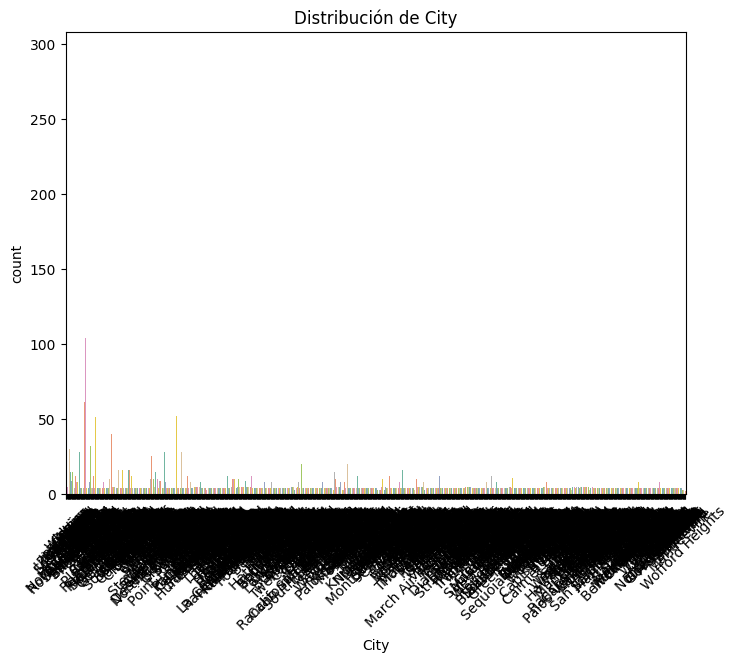

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


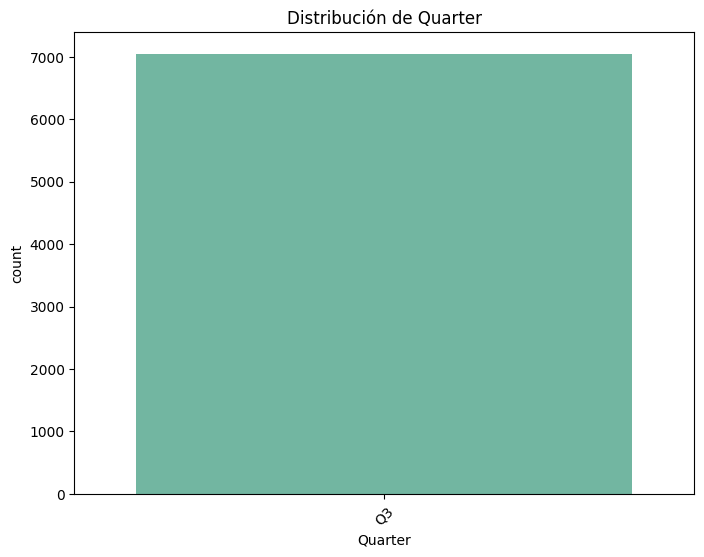

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


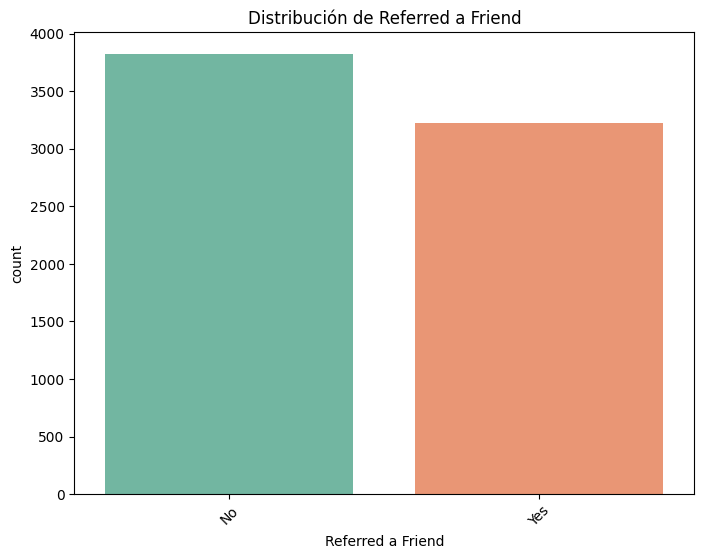

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


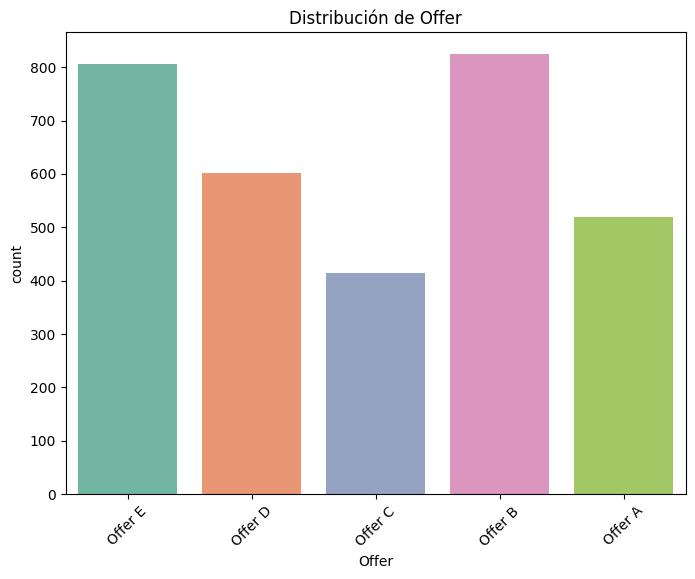

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


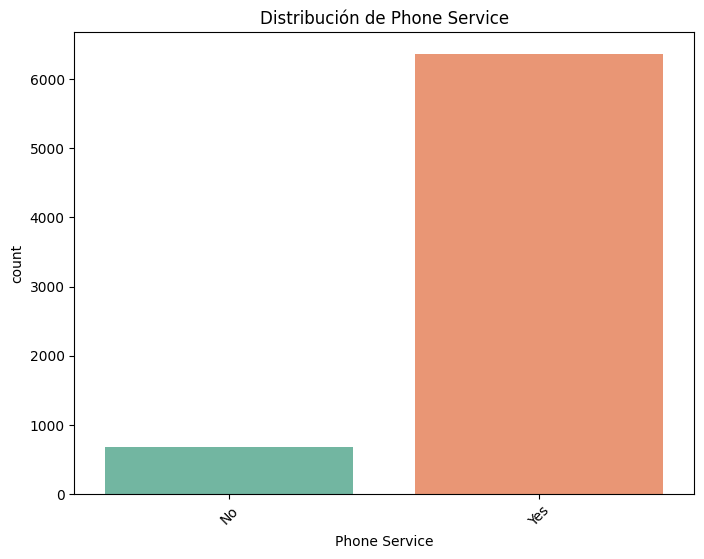

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


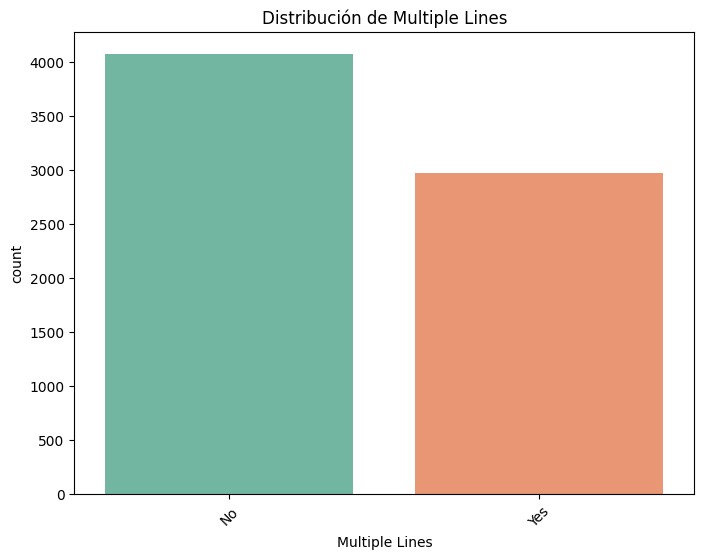

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


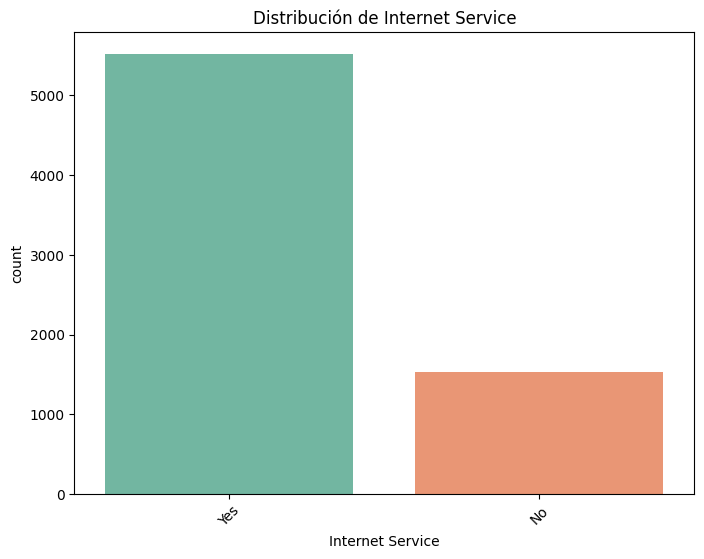

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


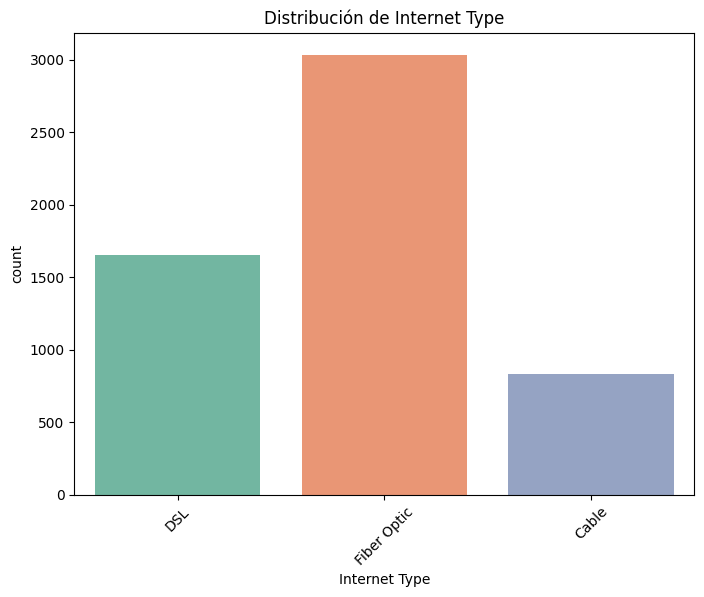

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


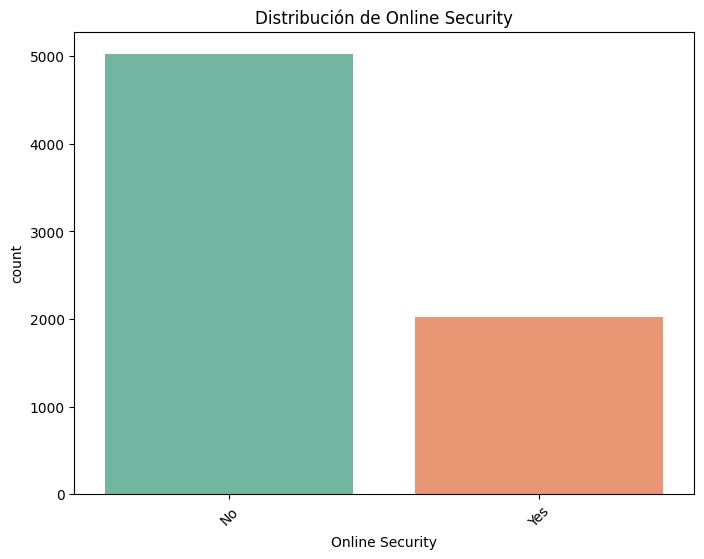

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


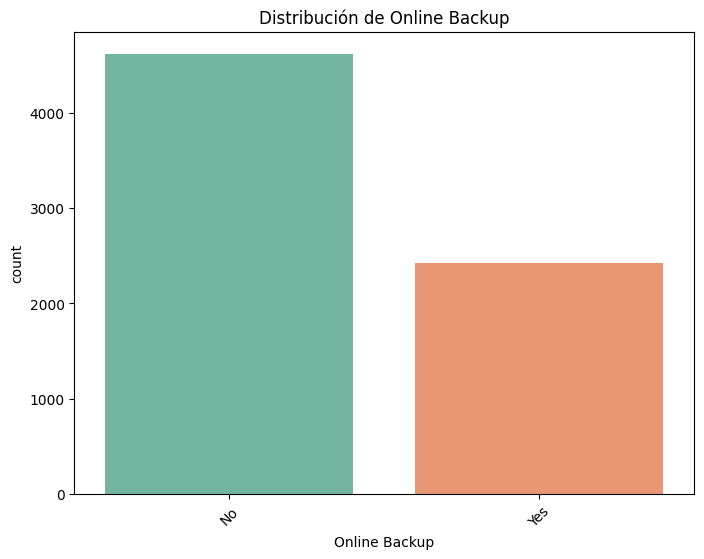

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


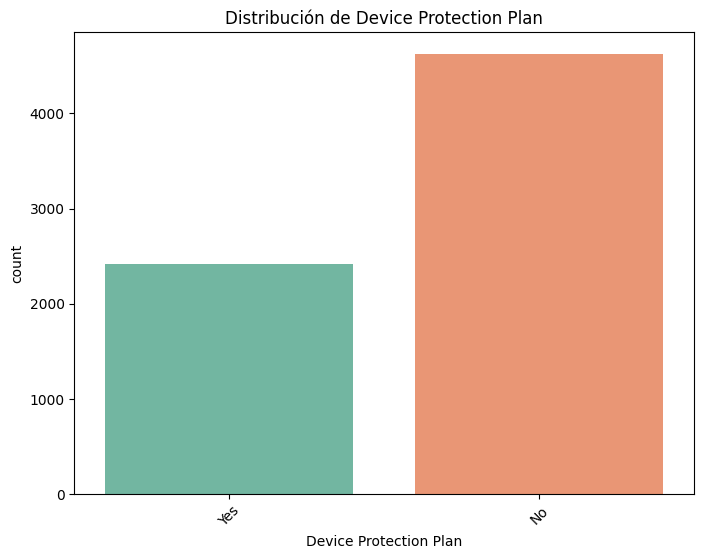

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


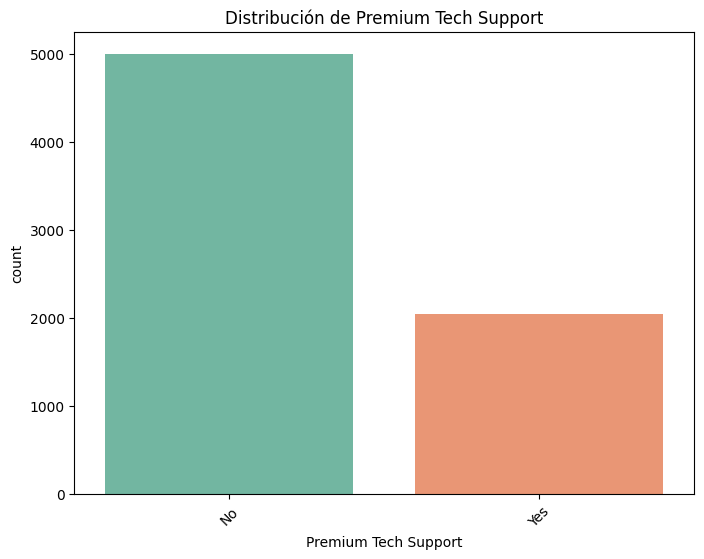

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


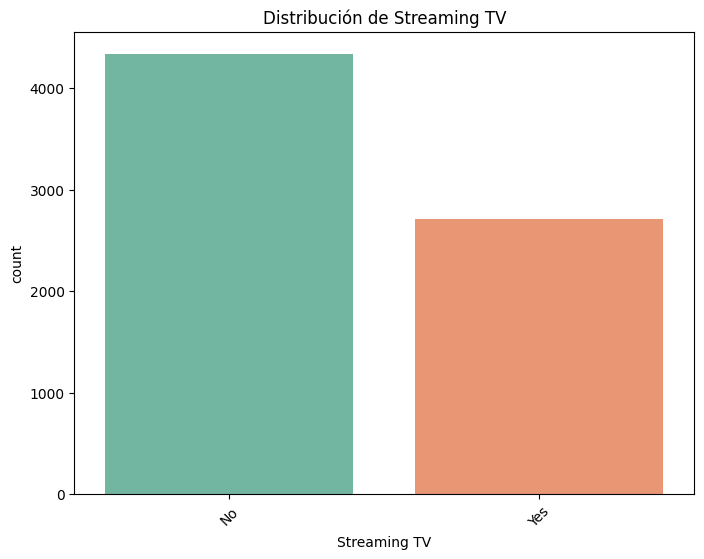

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


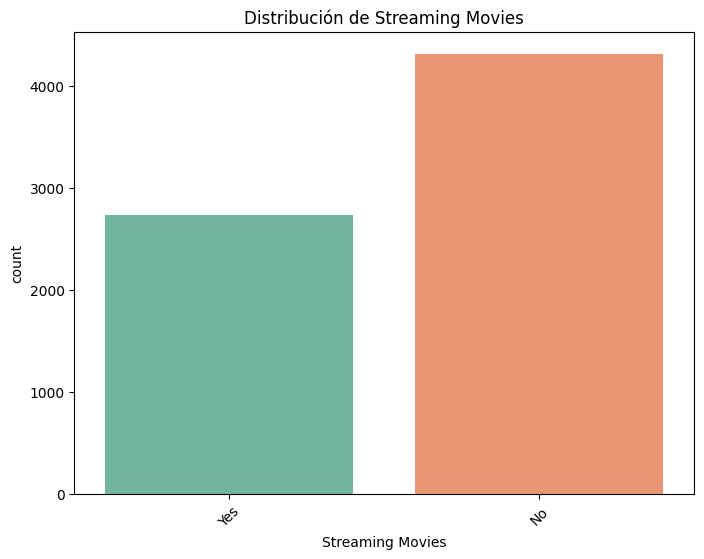

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


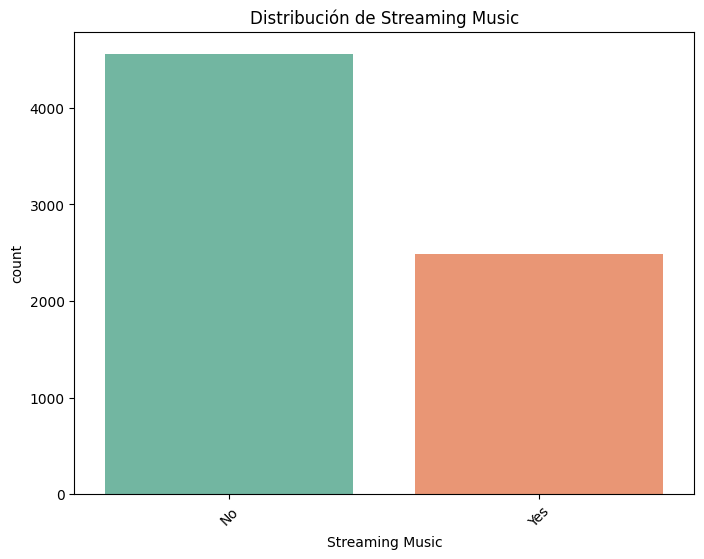

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


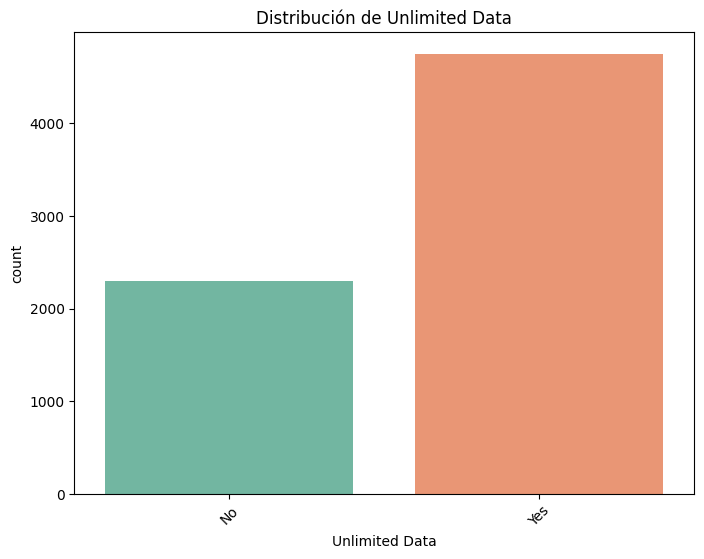

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


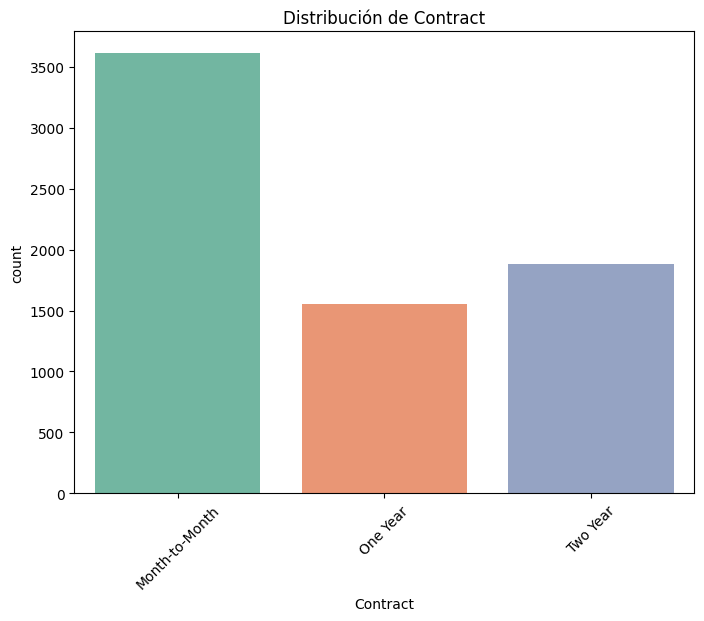

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


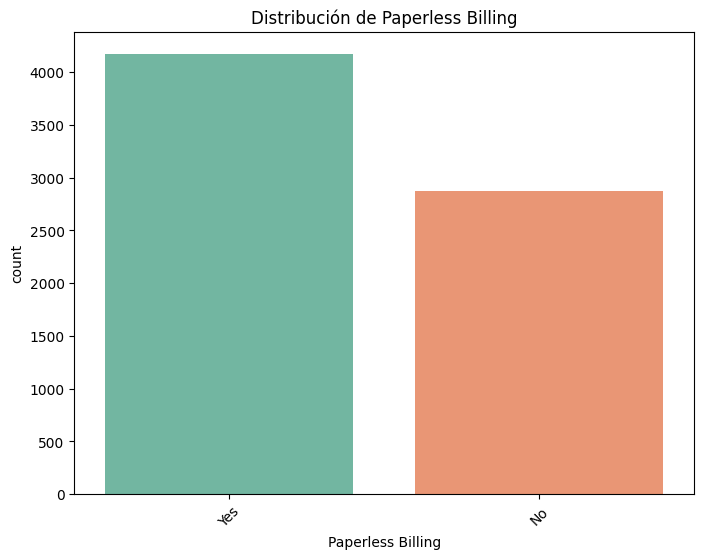

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


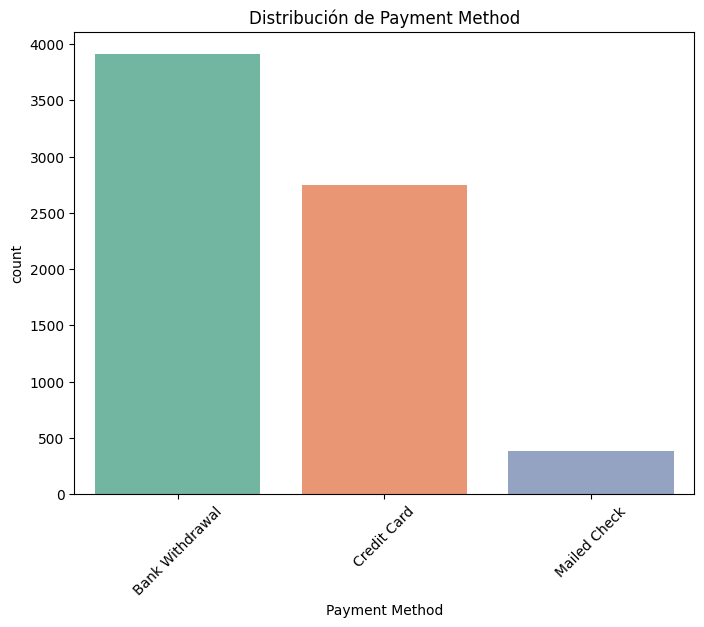

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


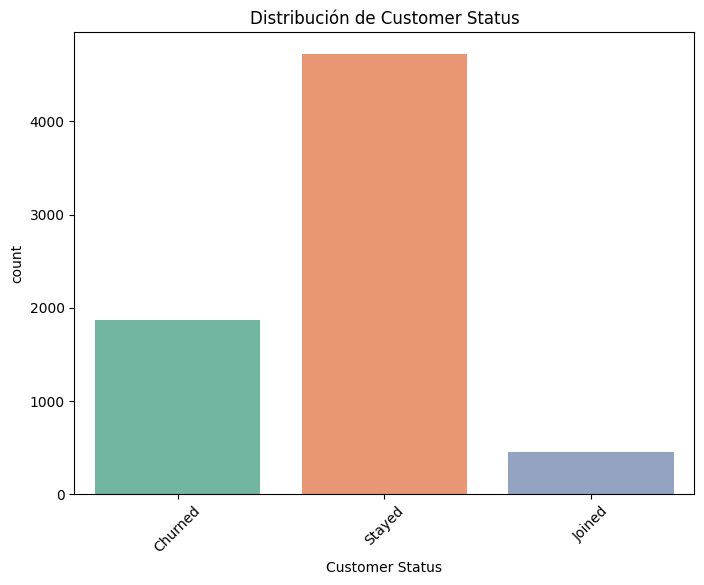

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


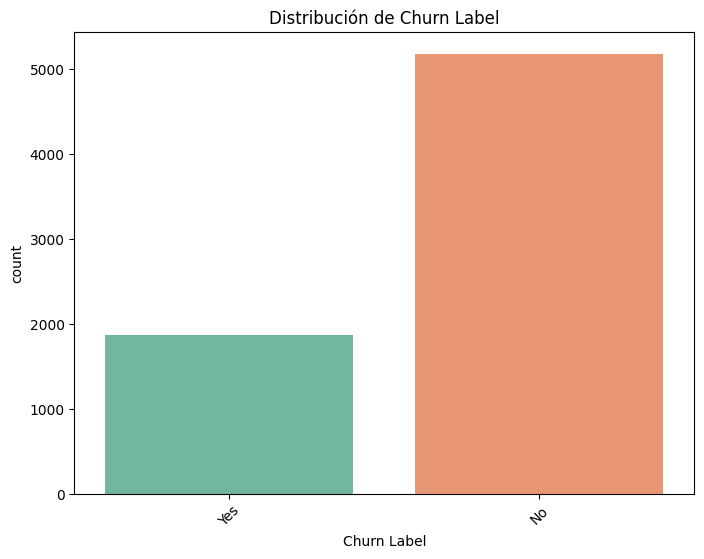

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


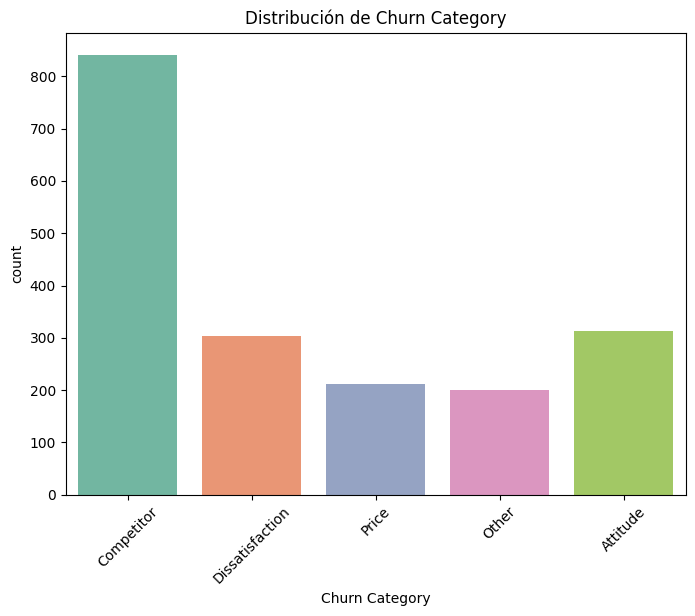

<ipython-input-12-cc839e2cfadc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


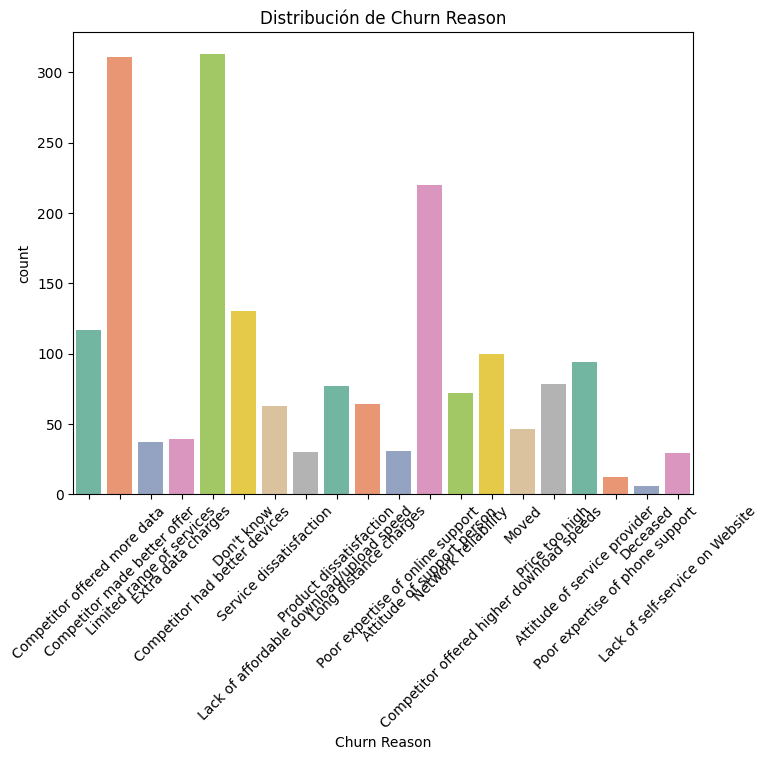

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma de las variables numéricas
data.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Gráfico de barras para variables categóricas
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column, data=data, palette='Set2')
    plt.title(f'Distribución de {column}')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
#Revisamos la cantidad de valores únicos en el dataframe
for col in data.columns:
    print(f"\n{col}\n")
    print(data[col].value_counts())


Customer ID

Customer ID
3186-AJIEK    1
8779-QRDMV    1
7495-OOKFY    1
4807-IZYOZ    1
1471-GIQKQ    1
             ..
3445-HXXGF    1
0390-DCFDQ    1
4412-YLTKF    1
4846-WHAFZ    1
4598-XLKNJ    1
Name: count, Length: 7043, dtype: int64

Gender

Gender
Male      3555
Female    3488
Name: count, dtype: int64

Age

Age
42    156
47    153
40    150
44    148
23    146
     ... 
80     66
66     63
78     63
67     61
72     58
Name: count, Length: 62, dtype: int64

Under 30

Under 30
No     5642
Yes    1401
Name: count, dtype: int64

Senior Citizen

Senior Citizen
No     5901
Yes    1142
Name: count, dtype: int64

Married

Married
No     3641
Yes    3402
Name: count, dtype: int64

Dependents

Dependents
No     5416
Yes    1627
Name: count, dtype: int64

Number of Dependents

Number of Dependents
0    5416
1     553
2     531
3     517
5      10
4       9
6       3
7       2
8       1
9       1
Name: count, dtype: int64

Country

Country
United States    7043
Name: count, dtype: int6

In [ ]:
# Revisión de los valores únicos con porcentajes
for col in data.columns:
    print(f"\n{col}\n")
    print(data[col].value_counts(normalize=True) * 100)  # Multiplicamos por 100 para obtener el porcentaje



Customer ID

Customer ID
3186-AJIEK    0.014198
8779-QRDMV    0.014198
7495-OOKFY    0.014198
4807-IZYOZ    0.014198
1471-GIQKQ    0.014198
                ...   
3445-HXXGF    0.014198
0390-DCFDQ    0.014198
4412-YLTKF    0.014198
4846-WHAFZ    0.014198
4598-XLKNJ    0.014198
Name: proportion, Length: 7043, dtype: float64

Gender

Gender
Male      50.47565
Female    49.52435
Name: proportion, dtype: float64

Age

Age
42    2.214965
47    2.172370
40    2.129774
44    2.101377
23    2.072980
        ...   
80    0.937101
66    0.894505
78    0.894505
67    0.866108
72    0.823513
Name: proportion, Length: 62, dtype: float64

Under 30

Under 30
No     80.107909
Yes    19.892091
Name: proportion, dtype: float64

Senior Citizen

Senior Citizen
No     83.785319
Yes    16.214681
Name: proportion, dtype: float64

Married

Married
No     51.69672
Yes    48.30328
Name: proportion, dtype: float64

Dependents

Dependents
No     76.899049
Yes    23.100951
Name: proportion, dtype: float64

Number

In [ ]:
numerical_columns = ['Age', 'Number of Dependents',
       'Population', 'Number of Referrals', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score',
       ]

<Axes: >

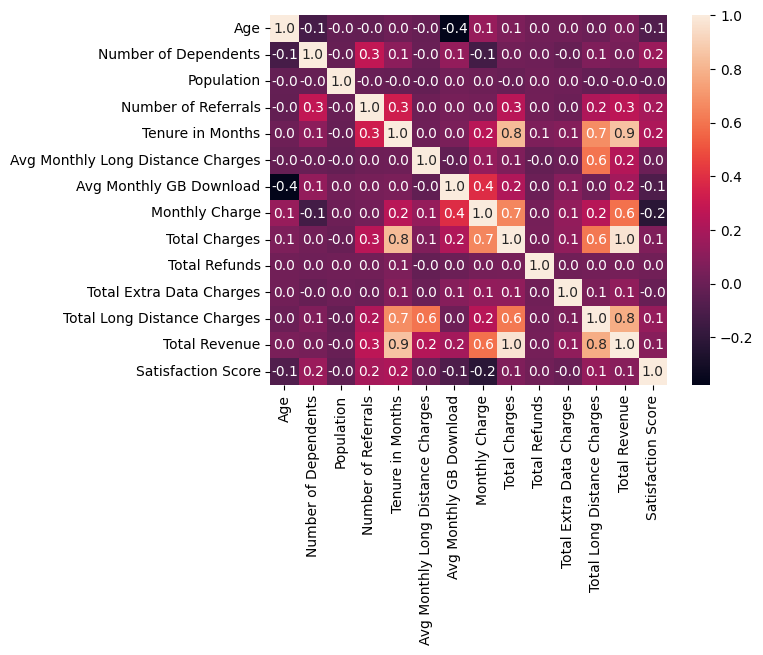

In [ ]:
sns.heatmap(data[numerical_columns].corr(), annot=True, fmt=".1f")

In [ ]:
import pandas as pd

# Primero obtenemos la matriz de correlación
correlation_matrix = data.corr(numeric_only=True)

# Extraemos las correlaciones mayores a 0.7 (sin la diagonal)
correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            correlated_pairs.append((var1, var2, corr_value))

# Convertimos a DataFrame para mejor visualización
correlated_df = pd.DataFrame(correlated_pairs, columns=["Variable 1", "Variable 2", "Correlación"])
correlated_df = correlated_df.sort_values(by="Correlación", ascending=False)

# Mostramos los pares correlacionados
print(correlated_df)


                    Variable 1     Variable 2  Correlación
5                Total Charges  Total Revenue     0.972212
0                     Zip Code       Latitude     0.894769
4             Tenure in Months  Total Revenue     0.853146
3             Tenure in Months  Total Charges     0.826074
6  Total Long Distance Charges  Total Revenue     0.778559
1                     Zip Code      Longitude    -0.790564
2                     Latitude      Longitude    -0.885979


In [ ]:
data

Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0     8779-QRDMV    Male   78       No            Yes      No         No   
1     7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2     1658-BYGOY    Male   71       No            Yes      No        Yes   
3     4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4     4846-WHAFZ  Female   80       No            Yes     Yes        Yes   
...          ...     ...  ...      ...            ...     ...        ...   
7038  2569-WGERO  Female   30       No             No      No         No   
7039  6840-RESVB    Male   38       No             No     Yes        Yes   
7040  2234-XADUH  Female   30       No             No     Yes        Yes   
7041  4801-JZAZL  Female   32       No             No     Yes        Yes   
7042  3186-AJIEK    Male   44       No             No      No         No   

      Number of Dependents        Country       State  ...  \
0                        0  United States  California  ...   
1                        1  United States  California  ...   
2                        3  United States  California  ...   
3                        1  United States  California  ...   
4                        1  United States  California  ...   
...                    ...            ...         ...  ...   
7038                     0  United States  California  ...   
7039                     2  United States  California  ...   
7040                     2  United States  California  ...   
7041                     2  United States  California  ...   
7042                     0  United States  California  ...   

     Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                          20                         0.00          59.65   
1                           0                       390.80        1024.10   
2                           0                       203.94        1910.88   
3                           0                       494.00        2995.07   
4                           0                       234.21        3102.36   
...                       ...                          ...            ...   
7038                        0                      1639.44        3039.53   
7039                        0                       865.20        2807.47   
7040                        0                      2135.52        9453.04   
7041                        0                         0.00         319.21   
7042                        0                      2043.36        8887.86   

      Satisfaction Score  Customer Status Churn Label Churn Score  CLTV  \
0                      3          Churned         Yes          91  5433   
1                      3          Churned         Yes          69  5302   
2                      2          Churned         Yes          81  3179   
3                      2          Churned         Yes          88  5337   
4                      2          Churned         Yes          67  2793   
...                  ...              ...         ...         ...   ...   
7038                   5           Stayed          No          45  5306   
7039                   3           Stayed          No          59  2140   
7040                   4           Stayed          No          71  5560   
7041                   4           Stayed          No          59  2793   
7042                   4           Stayed          No          38  5097   

       Churn Category                  Churn Reason  
0          Competitor  Competitor offered more data  
1          Competitor  Competitor made better offer  
2          Competitor  Competitor made better offer  
3     Dissatisfaction     Limited range of services  
4               Price            Extra data charges  
...               ...                           ...  
7038              NaN                           NaN  
7039              NaN                           NaN  
7040              NaN              

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


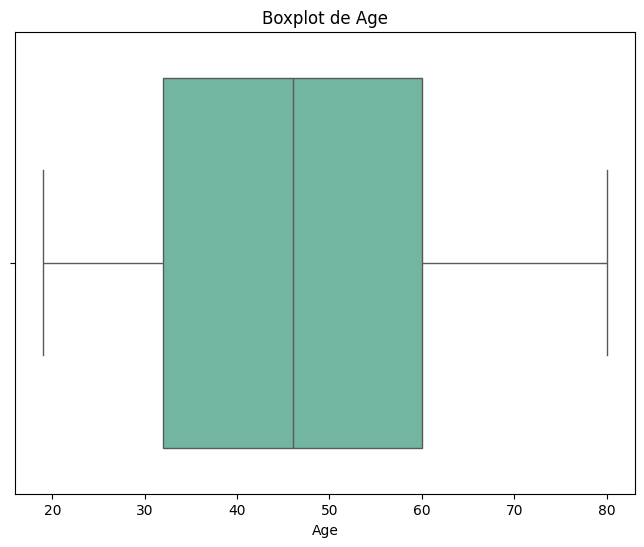

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


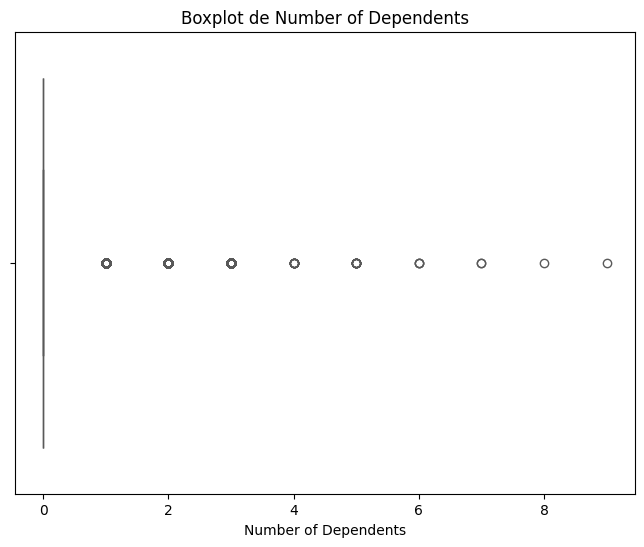

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


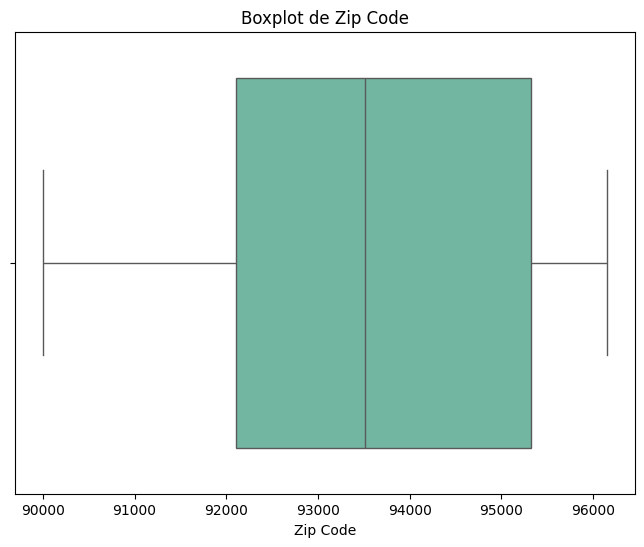

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


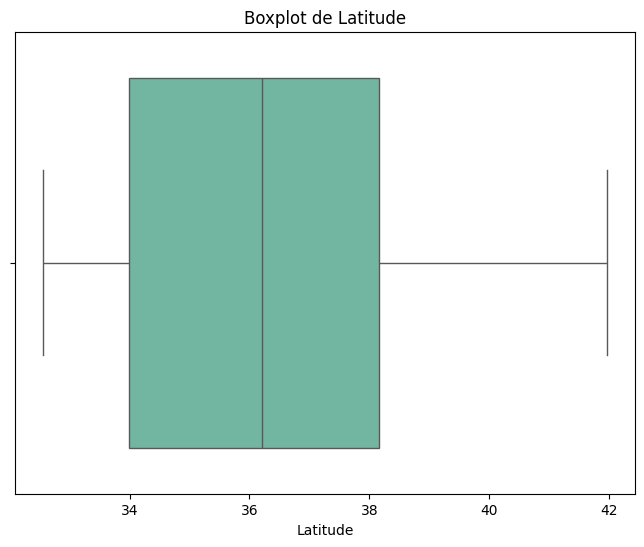

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


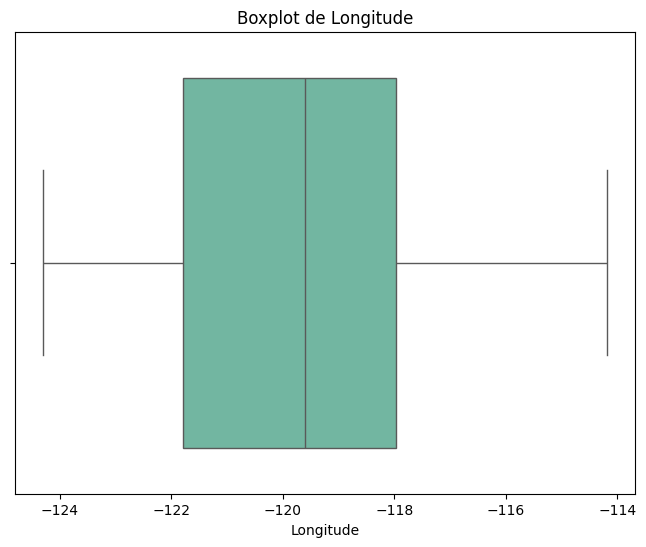

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


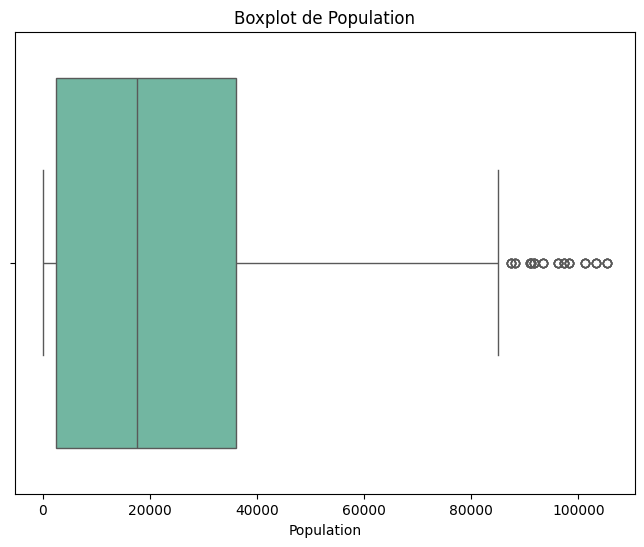

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


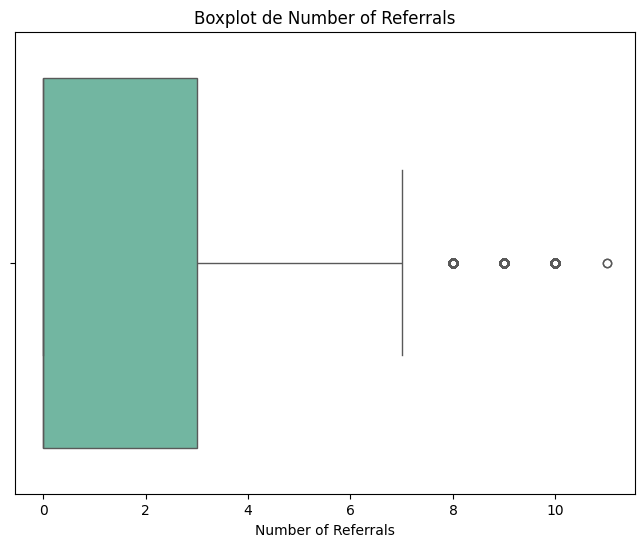

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


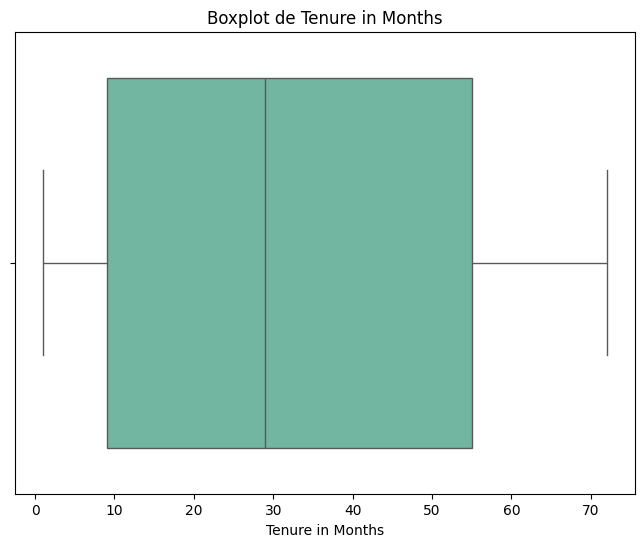

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


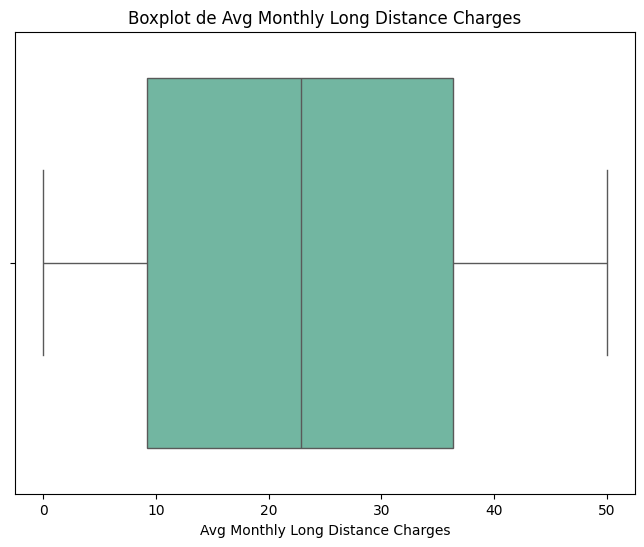

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


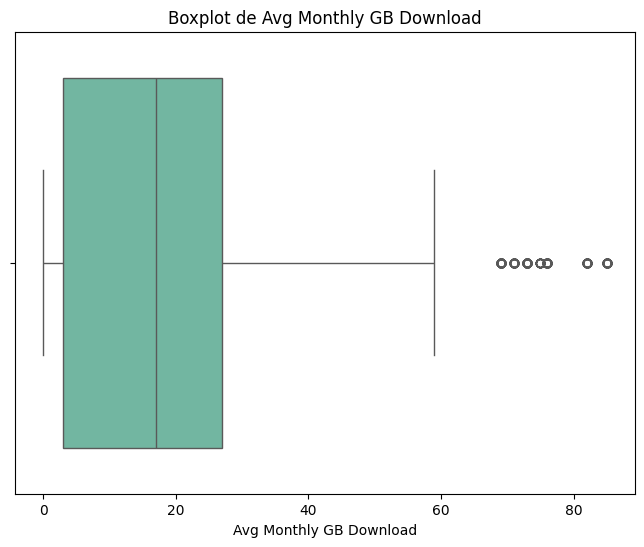

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


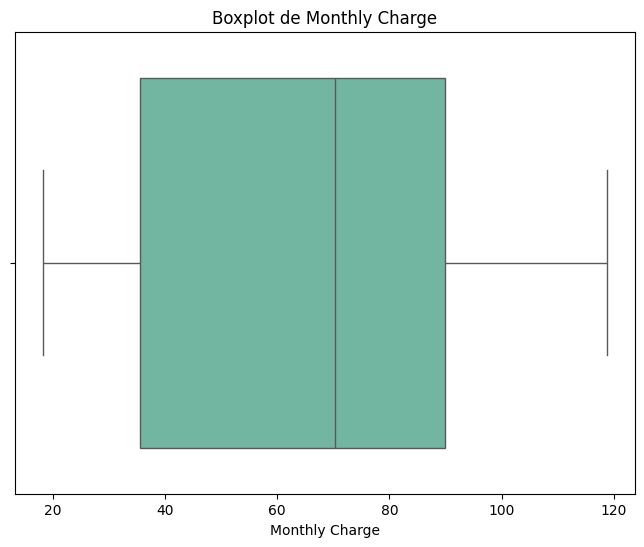

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


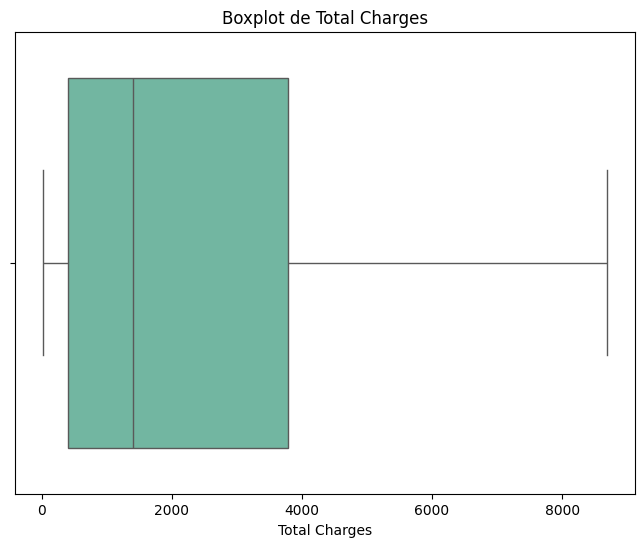

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


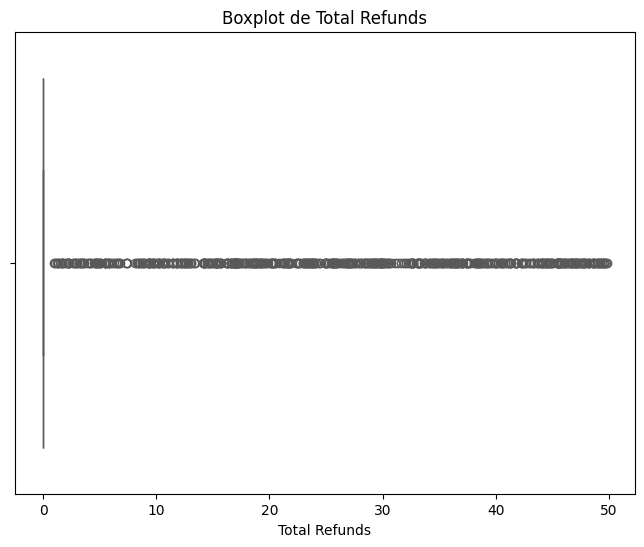

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


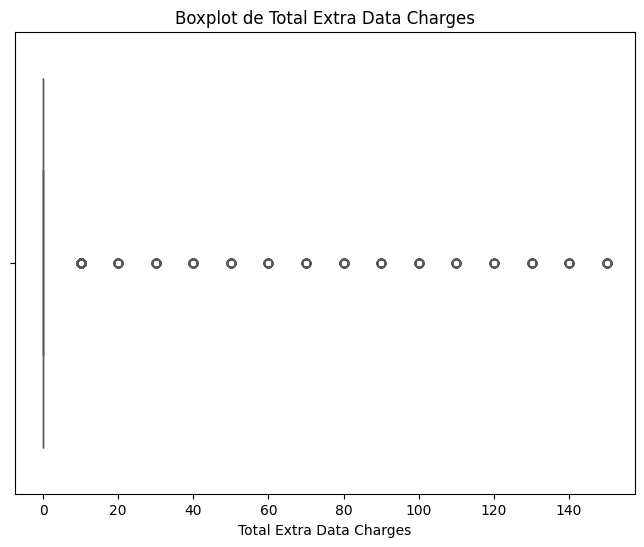

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


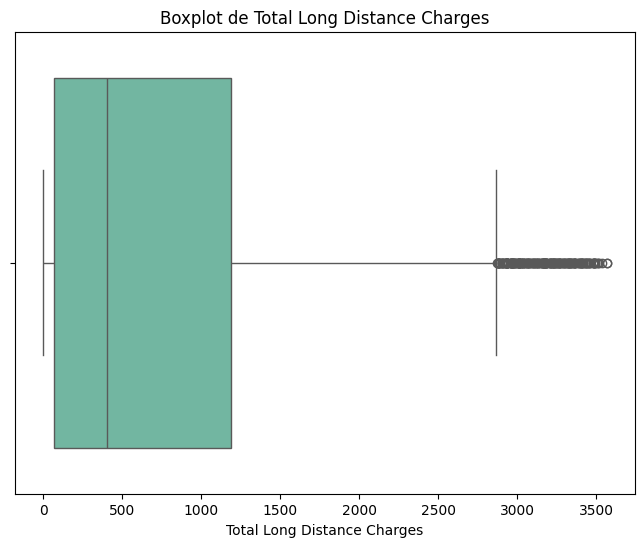

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


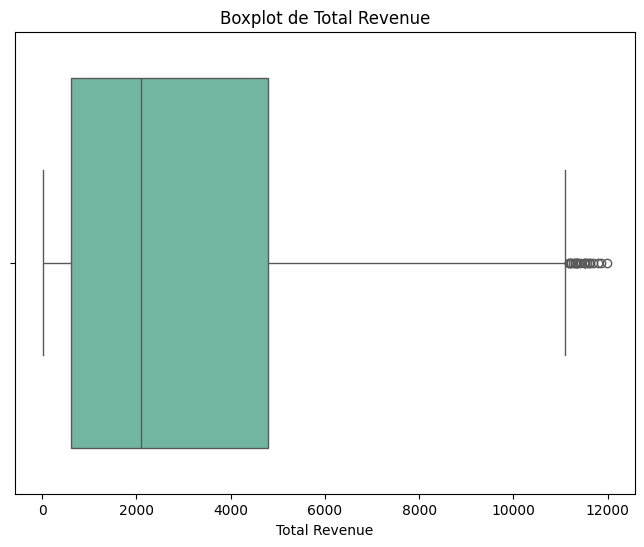

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


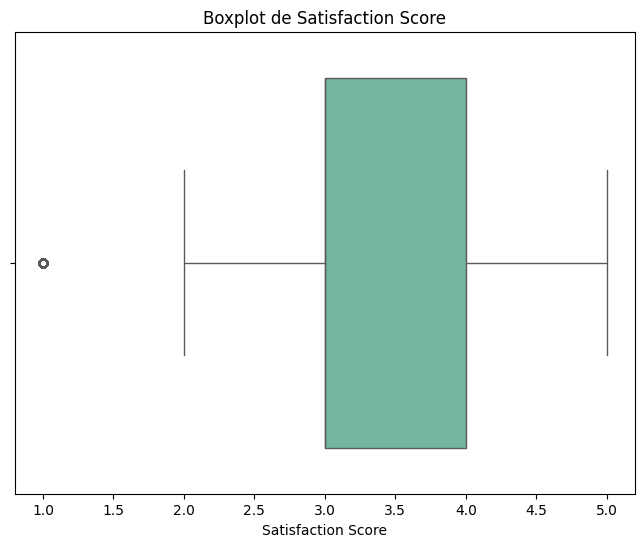

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


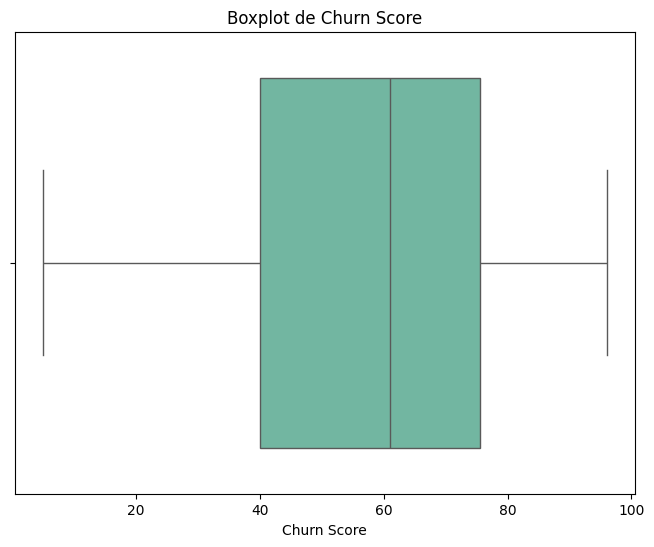

<ipython-input-20-54b06ae48034>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[col], palette='Set2')


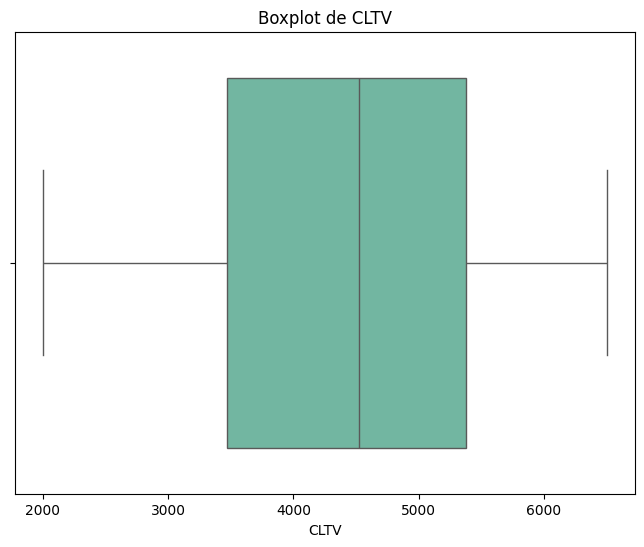

In [ ]:

# Seleccionamos solo las columnas numéricas
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Crear un boxplot para cada variable numérica
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[col], palette='Set2')
    plt.title(f'Boxplot de {col}')
    plt.show()


# 4. Data Processing

Eliminamos las variables indicadas por el profesor y variables que no utilizare como longitud, latitud, aquellas que tienen un solo dato (state,city), entre otras que no tienen suficientes datos

In [ ]:
data = data.drop(["Customer ID", "Under 30", "Senior Citizen", "Country", "State", "City", "Latitude", "Longitude", "Quarter", "Churn Category", "Churn Score", "CLTV", "Churn Reason", "Customer Status","Satisfaction Score", "Zip Code"], axis=1)


Observamos que total revenue es igual a total charges+total refunds+ total extra data charges + total long distance charges, por lo que hay una fuerte correlacion entre estas variables, para el primer experimento utilizaremos las variables que conforman total revenue y que no esten fuertemente correlaciones con tenure months y la variable ternure months


In [ ]:
numerical_columns = ['Age', 'Number of Dependents',
       'Population', 'Number of Referrals', 'Tenure in Months',
       'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue'
       ]

<Axes: >

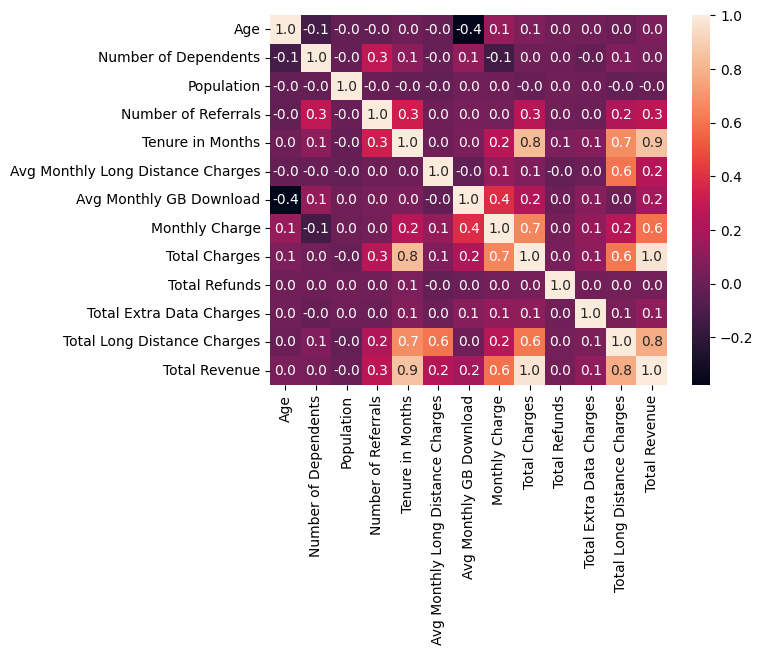

In [ ]:
sns.heatmap(data[numerical_columns].corr(), annot=True, fmt=".1f")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def detectar_outliers(df, mostrar_graficos=True):
    variables_numericas = df.select_dtypes(include=[np.number])
    resultados = []

    for columna in variables_numericas.columns:
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
        cantidad = outliers.shape[0]
        porcentaje = round((cantidad / df.shape[0]) * 100, 2)

        if cantidad > 0:
            resultados.append({
                'Variable': columna,
                'Cantidad Outliers': cantidad,
                'Porcentaje Outliers (%)': porcentaje
            })

            if mostrar_graficos:
                plt.figure(figsize=(8, 2))
                sns.boxplot(x=df[columna])
                plt.title(f'Boxplot de {columna}')
                plt.show()

    return pd.DataFrame(resultados)

# Ejemplo de uso:
# outliers_df = detectar_outliers(data, mostrar_graficos=True)
# display(outliers_df)


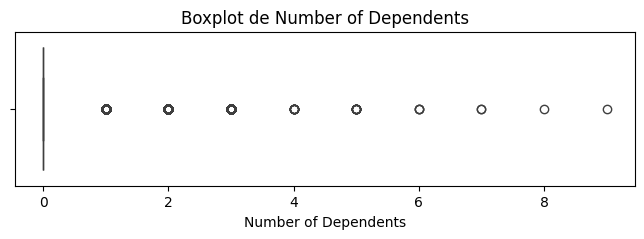

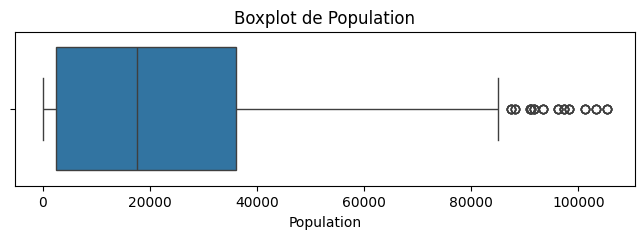

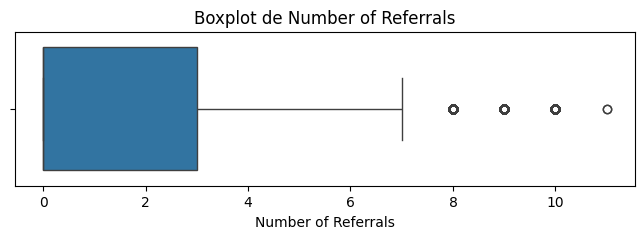

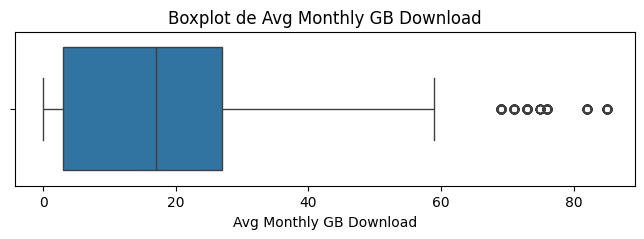

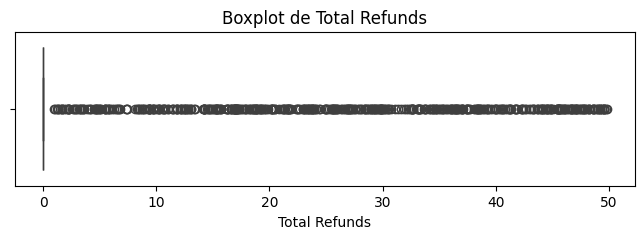

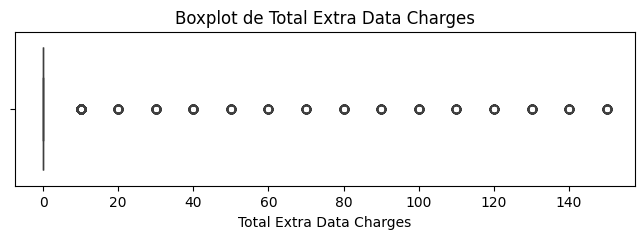

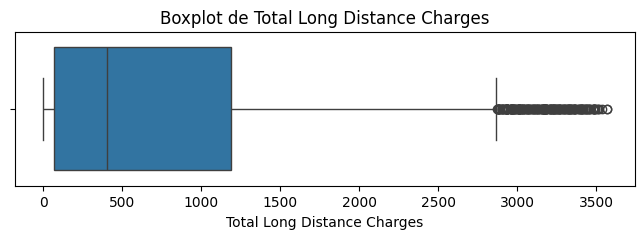

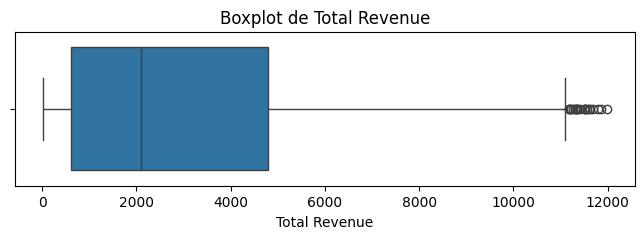

Variable  Cantidad Outliers  Porcentaje Outliers (%)
0         Number of Dependents               1627                    23.10
1                   Population                 57                     0.81
2          Number of Referrals                676                     9.60
3      Avg Monthly GB Download                362                     5.14
4                Total Refunds                525                     7.45
5     Total Extra Data Charges                728                    10.34
6  Total Long Distance Charges                196                     2.78
7                Total Revenue                 21                     0.30

In [ ]:
outliers_df = detectar_outliers(data, mostrar_graficos=True)
display(outliers_df)


In [ ]:
def eliminar_outliers(df, columnas):
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        df = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]
    return df


Discretizare las variables de numero de dependientes, por lo que solo eliminare outlier de la variable de number referrals

In [ ]:
columnas_numericas = [
    'Total Extra Data Charges']


In [ ]:
data = eliminar_outliers(data, columnas_numericas)


In [ ]:
print("Después:", data.shape)


Después: (6315, 34)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6315 entries, 1 to 7042
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6315 non-null   object 
 1   Age                                6315 non-null   int64  
 2   Married                            6315 non-null   object 
 3   Dependents                         6315 non-null   object 
 4   Number of Dependents               6315 non-null   int64  
 5   Population                         6315 non-null   int64  
 6   Referred a Friend                  6315 non-null   object 
 7   Number of Referrals                6315 non-null   int64  
 8   Tenure in Months                   6315 non-null   int64  
 9   Offer                              2846 non-null   object 
 10  Phone Service                      6315 non-null   object 
 11  Avg Monthly Long Distance Charges  6315 non-null   float64
 1

## Imputacion

***Offer***:*Identifies the last marketing offer that the customer accepted, if applicable: None, Offer A, Offer B, Offer C, Offer D, and Offer E.*

In [ ]:
data['Offer'] = data['Offer'].fillna("No Offer") #imputado

***Internet Service***:*Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.*

In [ ]:
data[(data["Internet Type"].isnull())&((data["Internet Service"]==0))]

Empty DataFrame
Columns: [Gender, Age, Married, Dependents, Number of Dependents, Population, Referred a Friend, Number of Referrals, Tenure in Months, Offer, Phone Service, Avg Monthly Long Distance Charges, Multiple Lines, Internet Service, Internet Type, Avg Monthly GB Download, Online Security, Online Backup, Device Protection Plan, Premium Tech Support, Streaming TV, Streaming Movies, Streaming Music, Unlimited Data, Contract, Paperless Billing, Payment Method, Monthly Charge, Total Charges, Total Refunds, Total Extra Data Charges, Total Long Distance Charges, Total Revenue, Churn Label]
Index: []

[0 rows x 34 columns]

In [ ]:
data['Internet Type'] = data['Internet Type'].fillna("No Internet")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6315 entries, 1 to 7042
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6315 non-null   object 
 1   Age                                6315 non-null   int64  
 2   Married                            6315 non-null   object 
 3   Dependents                         6315 non-null   object 
 4   Number of Dependents               6315 non-null   int64  
 5   Population                         6315 non-null   int64  
 6   Referred a Friend                  6315 non-null   object 
 7   Number of Referrals                6315 non-null   int64  
 8   Tenure in Months                   6315 non-null   int64  
 9   Offer                              6315 non-null   object 
 10  Phone Service                      6315 non-null   object 
 11  Avg Monthly Long Distance Charges  6315 non-null   float64
 1

In [ ]:
data["Churn Label"].value_counts()

Churn Label
No     4685
Yes    1630
Name: count, dtype: int64

In [ ]:
list(data.columns)


['Gender',
 'Age',
 'Married',
 'Dependents',
 'Number of Dependents',
 'Population',
 'Referred a Friend',
 'Number of Referrals',
 'Tenure in Months',
 'Offer',
 'Phone Service',
 'Avg Monthly Long Distance Charges',
 'Multiple Lines',
 'Internet Service',
 'Internet Type',
 'Avg Monthly GB Download',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Monthly Charge',
 'Total Charges',
 'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
 'Total Revenue',
 'Churn Label']

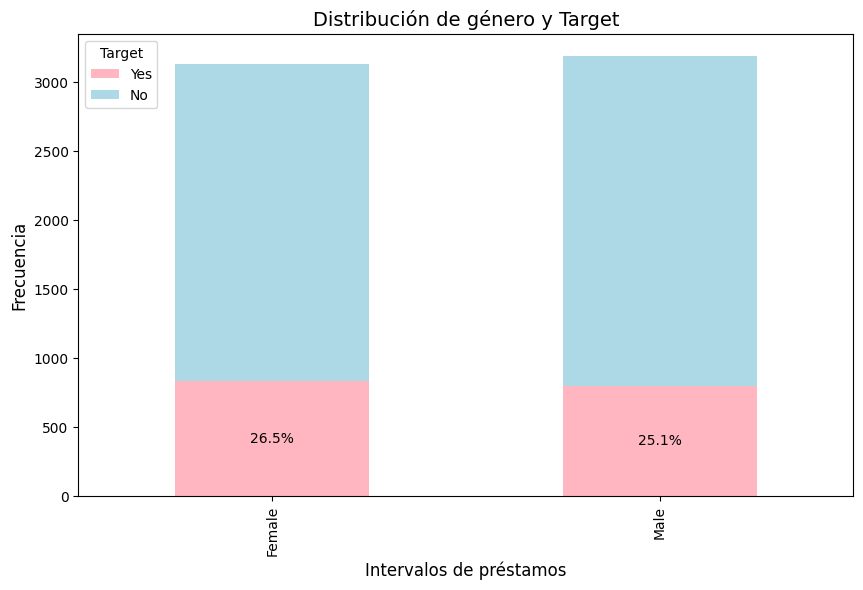

In [ ]:
# Agrupar los datos por categoría e intervalo
grouped_data = data.groupby(['Gender', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de "bad"
grouped_data['Yes_porcentaje'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)


for i, (index, row) in enumerate(grouped_data.iterrows()):
    total = row['Yes'] + row['No']
    porcentaje_yes = row['Yes'] / total * 100
    height_yes = row['Yes']
    ax1.text(i, height_yes / 2, f'{porcentaje_yes:.1f}%', ha='center', va='center', fontsize=10, color='black')

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Intervalos de préstamos', fontsize=12)
ax1.set_title('Distribución de género y Target', fontsize=14)
ax1.legend(['Yes', 'No'], title='Target', loc='upper left')


## Feature Engineering

In [ ]:
data["Number of Dependents"].value_counts()

Number of Dependents
0    4826
1     504
2     493
3     469
5       9
4       7
6       3
7       2
8       1
9       1
Name: count, dtype: int64

In [ ]:
def dependientes(x):
    if x["Number of Dependents"]==0:
        return "Grupo sin dependientes"
    elif x["Number of Dependents"]==1 or x["Number of Dependents"]== 2:
        return "Grupo 1 0 2 dependientes"
    elif x["Number of Dependents"]==3 or x["Number of Dependents"]== 4:
        return "Grupo 3 o 4 dependientes"
    elif x["Number of Dependents"] >4:
        return "Más de 4 dependientes"

In [ ]:
data["Dependientes"]=data.apply(lambda x: dependientes(x),axis=1)

In [ ]:
data["Dependientes"].value_counts()

Dependientes
Grupo sin dependientes      4826
Grupo 1 0 2 dependientes     997
Grupo 3 o 4 dependientes     476
Más de 4 dependientes         16
Name: count, dtype: int64

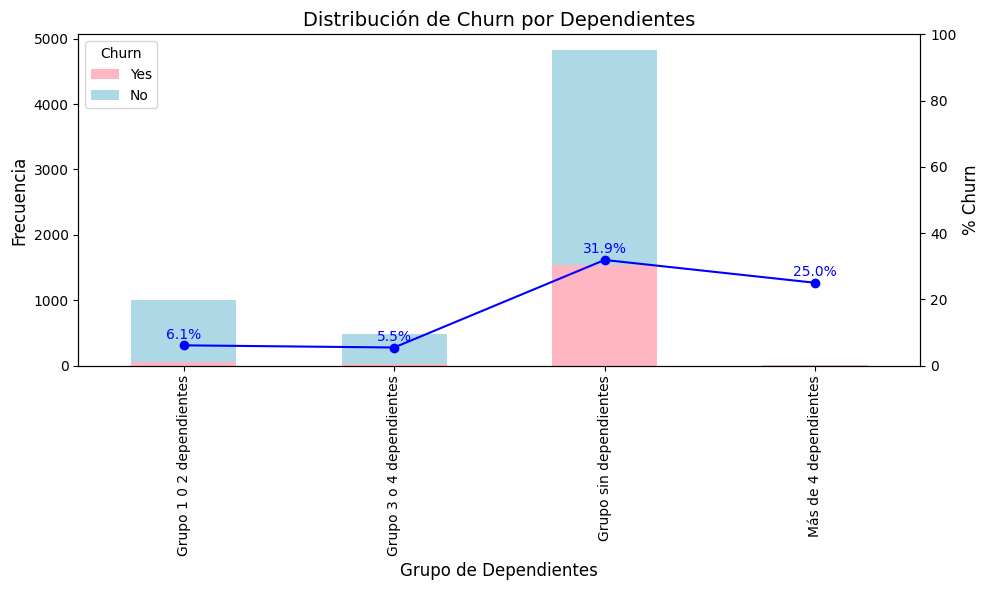

In [ ]:
import matplotlib.pyplot as plt

# Agrupar los datos por Dependientes y Churn Label
grouped_data = data.groupby(['Dependientes', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de churn ("Yes")
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Grupo de Dependientes', fontsize=12)
ax1.set_title('Distribución de Churn por Dependientes', fontsize=14)
ax1.legend(['Yes', 'No'], title='Churn', loc='upper left')

# Crear un segundo eje Y para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['Yes_percentage'], color='blue', marker='o', label='% Yes')
ax2.set_ylabel('% Churn', fontsize=12)
ax2.set_ylim(0, 100)

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
data["Intervalos_edad"] = pd.qcut(data['Age'], q=4)
data["Intervalos_edad"].value_counts()

Intervalos_edad
(32.0, 46.0]      1669
(18.999, 32.0]    1593
(59.0, 80.0]      1567
(46.0, 59.0]      1486
Name: count, dtype: int64

In [ ]:
data["Intervalos_edad"] = data["Intervalos_edad"].astype(str)


In [ ]:
pd.crosstab(data["Intervalos_edad"], data['Churn Label'], normalize='index')*100

Churn Label             No        Yes
Intervalos_edad                      
(18.999, 32.0]   78.217200  21.782800
(32.0, 46.0]     77.052127  22.947873
(46.0, 59.0]     76.110363  23.889637
(59.0, 80.0]     65.220166  34.779834

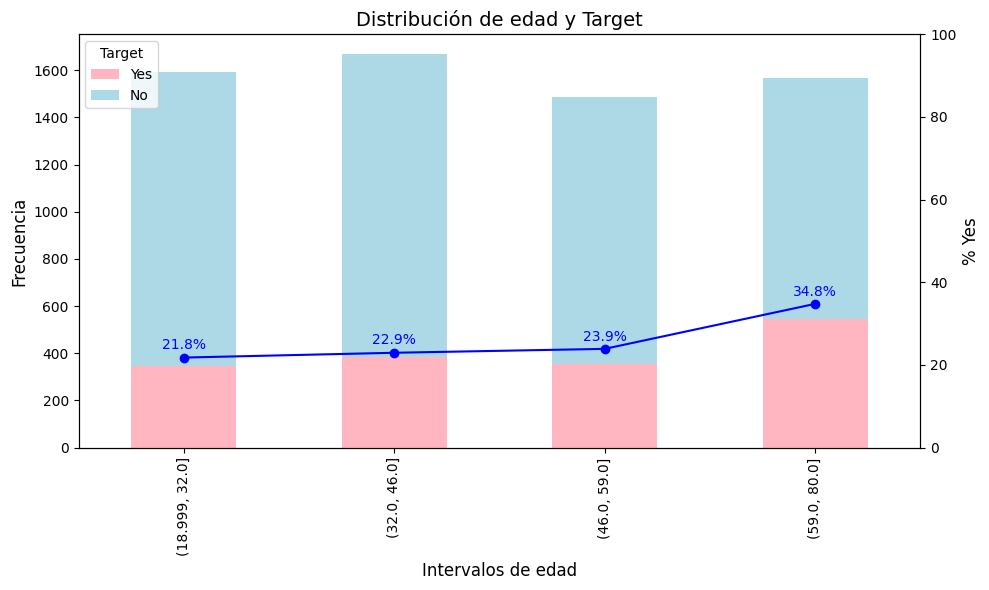

In [ ]:
# Agrupar los datos por categoría e intervalo
grouped_data = data.groupby(['Intervalos_edad', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de "bad"
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Intervalos de edad', fontsize=12)
ax1.set_title('Distribución de edad y Target', fontsize=14)
ax1.legend(['Yes', 'No'], title='Target', loc='upper left')

# Crear un segundo eje Y para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['Yes_percentage'], color='blue', marker='o', label='% Yes')
ax2.set_ylabel('% Yes', fontsize=12)
ax2.set_ylim(0, 100)

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
data['TenureGroup'] = pd.cut(data['Tenure in Months'], bins=[0, 12, 24, 48, 60, 72], labels=['<1 año', '1-2 años', '2-4 años', '4-5 años', '>5 años'])


<ipython-input-48-dd6a7daf2e50>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(['TenureGroup', 'Churn Label']).size().unstack(fill_value=0)


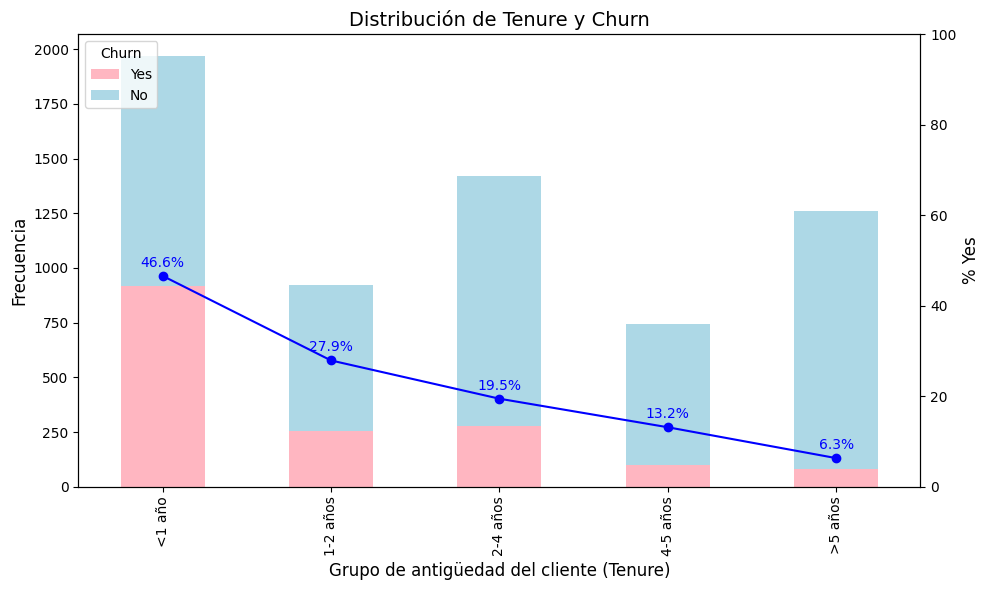

In [ ]:
import matplotlib.pyplot as plt

# Agrupar los datos por TenureGroup y Churn Label
grouped_data = data.groupby(['TenureGroup', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de churn ("Yes")
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Grupo de antigüedad del cliente (Tenure)', fontsize=12)
ax1.set_title('Distribución de Tenure y Churn', fontsize=14)
ax1.legend(['Yes', 'No'], title='Churn', loc='upper left')

# Crear un segundo eje Y para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['Yes_percentage'], color='blue', marker='o', label='% Yes')
ax2.set_ylabel('% Yes', fontsize=12)
ax2.set_ylim(0, 100)

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


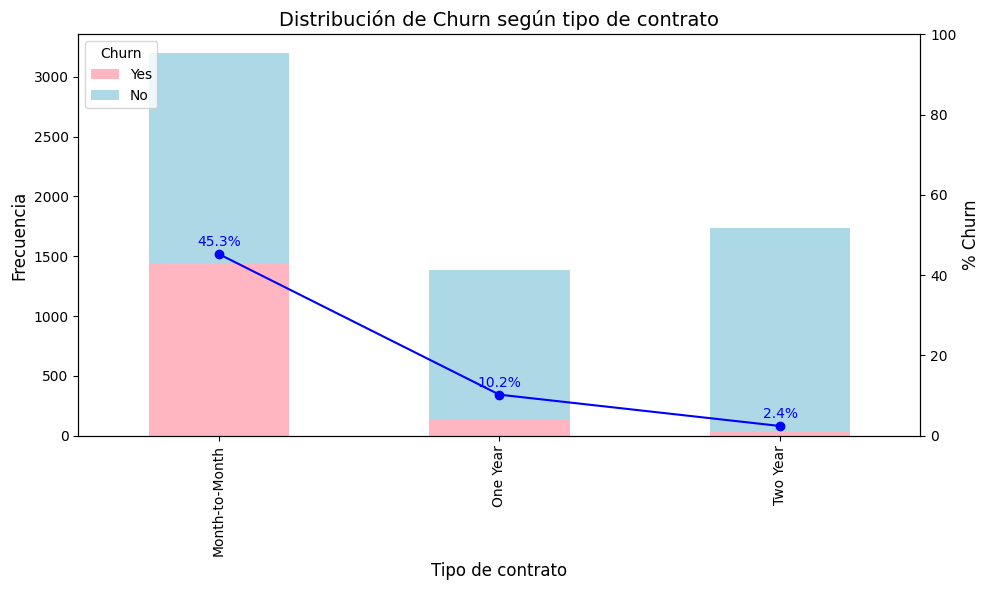

In [ ]:
import matplotlib.pyplot as plt

# Agrupar los datos por tipo de contrato y Churn Label
grouped_data = data.groupby(['Contract', 'Churn Label']).size().unstack(fill_value=0)

# Calcular porcentajes de churn ("Yes")
grouped_data['Yes_percentage'] = grouped_data['Yes'] / grouped_data.sum(axis=1) * 100

# Colores pastel
colors = ['lightpink', 'lightblue']

# Crear gráfico de barras apiladas
fig, ax1 = plt.subplots(figsize=(10, 6))
grouped_data[['Yes', 'No']].plot(kind='bar', stacked=True, color=colors, ax=ax1)

# Configurar ejes del gráfico de barras
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_xlabel('Tipo de contrato', fontsize=12)
ax1.set_title('Distribución de Churn según tipo de contrato', fontsize=14)
ax1.legend(['Yes', 'No'], title='Churn', loc='upper left')

# Crear un segundo eje Y para la línea de porcentaje
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['Yes_percentage'], color='blue', marker='o', label='% Yes')
ax2.set_ylabel('% Churn', fontsize=12)
ax2.set_ylim(0, 100)

# Añadir etiquetas del porcentaje en la línea
for i, txt in enumerate(grouped_data['Yes_percentage']):
    ax2.text(i, txt + 2, f'{txt:.1f}%', ha='center', color='blue', fontsize=10)

# Ajustar visualización
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
data['Tienecompromiso'] = data['Contract'].map({
    'Month-to-Month': 0,
    'One Year': 1,
    'Two Year': 1
})


In [ ]:
# Convertir las columnas a 1 (Yes) y 0 (No)
streaming_cols = ['Streaming TV', 'Streaming Movies', 'Streaming Music']

for col in streaming_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# Crear la columna Combo_stream: 1 si todas son 1, caso contrario 0
data['Combo_stream'] = (
    (data['Streaming TV'] == 1) &
    (data['Streaming Movies'] == 1) &
    (data['Streaming Music'] == 1)
).astype(int)


In [ ]:
columns_to_binary = [
    'Married', 'Dependents', 'Referred a Friend', 'Phone Service', 'Multiple Lines',
    'Online Security', 'Online Backup', 'Device Protection Plan',
    'Premium Tech Support', 'Unlimited Data',"Paperless Billing", "Churn Label","Internet Service"]

for col in columns_to_binary:
    data[col] = data[col].map({'Yes': 1, 'No': 0})


In [ ]:
data['Gender'] = data['Gender'].map({'Female': 1, 'Male': 0})


In [ ]:
data["Intervalos_edad"] = data["Intervalos_edad"].astype(str)
data["TenureGroup"] = data["TenureGroup"].astype(str)
data["Intervalos_edad"] = data["Intervalos_edad"].astype(str)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6315 entries, 1 to 7042
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6315 non-null   int64  
 1   Age                                6315 non-null   int64  
 2   Married                            6315 non-null   int64  
 3   Dependents                         6315 non-null   int64  
 4   Number of Dependents               6315 non-null   int64  
 5   Population                         6315 non-null   int64  
 6   Referred a Friend                  6315 non-null   int64  
 7   Number of Referrals                6315 non-null   int64  
 8   Tenure in Months                   6315 non-null   int64  
 9   Offer                              6315 non-null   object 
 10  Phone Service                      6315 non-null   int64  
 11  Avg Monthly Long Distance Charges  6315 non-null   float64
 1

## Re-sampling (if needed)

In [ ]:
# Your code here

# 5 Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
#Procedemos a dividir la data, en este caso vamos a partir 70% para el train_data, 20% para la val_data y 10% para la test data
train_data, temp_data = train_test_split(data, train_size=0.70, random_state=9, stratify=data[["Churn Label"]])


In [ ]:
len(data)

6315

In [ ]:
len(train_data)

4420

In [ ]:
len(data), len(train_data)

(6315, 4420)

In [ ]:
# Busco el porcentaje para colocar
#en este caso seria 0.2/0.3=0.66666

In [ ]:
val_data, test_data= train_test_split(temp_data, train_size=0.66666, random_state=9, stratify=temp_data[["Churn Label"]])

In [ ]:
len(data), len(train_data), len(test_data), len(val_data)

(6315, 4420, 632, 1263)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6315 entries, 1 to 7042
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6315 non-null   int64  
 1   Age                                6315 non-null   int64  
 2   Married                            6315 non-null   int64  
 3   Dependents                         6315 non-null   int64  
 4   Number of Dependents               6315 non-null   int64  
 5   Population                         6315 non-null   int64  
 6   Referred a Friend                  6315 non-null   int64  
 7   Number of Referrals                6315 non-null   int64  
 8   Tenure in Months                   6315 non-null   int64  
 9   Offer                              6315 non-null   object 
 10  Phone Service                      6315 non-null   int64  
 11  Avg Monthly Long Distance Charges  6315 non-null   float64
 1

## Encoding

In [ ]:
data

Gender  Age  Married  Dependents  Number of Dependents  Population  \
1          1   74        1           1                     1       55668   
2          0   71        0           1                     3       47534   
3          1   78        1           1                     1       27778   
4          1   80        1           1                     1       26265   
6          1   76        1           1                     2       21343   
...      ...  ...      ...         ...                   ...         ...   
7038       1   30        0           0                     0        2182   
7039       0   38        1           1                     2       18980   
7040       1   30        1           1                     2          42   
7041       1   32        1           1                     2         301   
7042       0   44        0           0                     0       28819   

      Referred a Friend  Number of Referrals  Tenure in Months     Offer  ...  \
1                     1                    1                 8   Offer E  ...   
2                     0                    0                18   Offer D  ...   
3                     1                    1                25   Offer C  ...   
4                     1                    1                37   Offer C  ...   
6                     1                    1                 1   Offer E  ...   
...                 ...                  ...               ...       ...  ...   
7038                  0                    0                72  No Offer  ...   
7039                  1                    1                24   Offer C  ...   
7040                  1                    4                72  No Offer  ...   
7041                  1                    1                11  No Offer  ...   
7042                  0                    0                66  No Offer  ...   

      Total Refunds  Total Extra Data Charges  Total Long Distance Charges  \
1              0.00                         0                       390.80   
2             45.61                         0                       203.94   
3             13.43                         0                       494.00   
4              0.00                         0                       234.21   
6              0.00                         0                        15.28   
...             ...                       ...                          ...   
7038          19.31                         0                      1639.44   
7039          48.23                         0                       865.20   
7040          45.38                         0                      2135.52   
7041          27.24                         0                         0.00   
7042           0.00                         0                      2043.36   

      Total Revenue Churn Label              Dependientes  Intervalos_edad  \
1           1024.10           1  Grupo 1 0 2 dependientes     (59.0, 80.0]   
2           1910.88           1  Grupo 3 o 4 dependientes     (59.0, 80.0]   
3           2995.07           1  Grupo 1 0 2 dependientes     (59.0, 80.0]   
4           3102.36           1  Grupo 1 0 2 dependientes     (59.0, 80.0]   
6             85.73           1  Grupo 1 0 2 dependientes     (59.0, 80.0]   
...             ...         ...                       ...              ...   
7038        3039.53           0    Grupo sin dependientes   (18.999, 32.0]   
7039        2807.47           0  Grupo 1 0 2 dependientes     (32.0, 46.0]   
7040        9453.04           0  Grupo 1 0 2 dependientes   (18.999, 32.0]   
7041         319.21           0  Grupo 1 0 2 dependientes   (18.999, 32.0]   
7042        8887.86           0    Grupo sin dependientes     (32.0, 46.0]   

      TenureGroup  Tienecompromiso  Combo_stream  
1          <1 año                0             0  
2        1-2 años                0             1  
3        2-4 años                0             0  
4        2-4 años                0        

In [ ]:
categorical_columns = train_data.select_dtypes(exclude=["number"]).columns

In [ ]:
categorical_columns

Index(['Offer', 'Internet Type', 'Contract', 'Payment Method', 'Dependientes',
       'Intervalos_edad', 'TenureGroup'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder


In [ ]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1

In [ ]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

In [ ]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [ ]:
!pip install cartopy
import cartopy

In [ ]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder

In [ ]:
from category_encoders import TargetEncoder, OrdinalEncoder, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Columnas a transformar
targetEncoderColumns = ["Offer", "Contract"]
ordinalEncoderColumns = ["Intervalos_edad", "Dependientes", "TenureGroup"]
oneHotEncoderColumns = ["Payment Method", "Internet Type"]

# 1. Variable objetivo (importante hacer esto ANTES de transformar)
y_train = train_data["Churn Label"]
y_val = val_data["Churn Label"]
y_test = test_data["Churn Label"]

# 2. OrdinalEncoder
ordinal_encoder = OrdinalEncoder(
    cols=ordinalEncoderColumns,
    mapping=[
        {
            "col": "Intervalos_edad",
            "mapping": {
                "(18.999, 32.0]": 0,
                "(32.0, 46.0]": 1,
                "(46.0, 59.0]": 2,
                "(59.0, 80.0]": 3
            }
        },
        {
            "col": "Dependientes",
            "mapping": {
                "Grupo sin dependientes": 0,
                "Grupo 1 0 2 dependientes": 1,
                "Grupo 3 o 4 dependientes": 2,
                "Más de 4 dependientes": 3
            }
        },
        {
            "col": "TenureGroup",
            "mapping": {
                "<1 año": 0,
                "1-2 años": 1,
                "2-4 años": 2,
                "4-5 años": 3,
                ">5 años": 4
            }
        }
    ]
)

train_data = ordinal_encoder.fit_transform(train_data)
val_data = ordinal_encoder.transform(val_data)
test_data = ordinal_encoder.transform(test_data)

# 3. TargetEncoder
target_encoder = TargetEncoder(cols=targetEncoderColumns)
train_data[targetEncoderColumns] = target_encoder.fit_transform(train_data[targetEncoderColumns], y_train)
val_data[targetEncoderColumns] = target_encoder.transform(val_data[targetEncoderColumns])
test_data[targetEncoderColumns] = target_encoder.transform(test_data[targetEncoderColumns])

# 4. OneHotEncoder
# Entrenamos el one hot encoder solo con train_data
onehot_encoder = OneHotEncoder(cols=oneHotEncoderColumns, use_cat_names=True)

train_data = onehot_encoder.fit_transform(train_data)
val_data = onehot_encoder.transform(val_data)
test_data = onehot_encoder.transform(test_data)


## Train Data

In [ ]:
train_data

Gender  Age  Married  Dependents  Number of Dependents  Population  \
3409       1   62        0           0                     0         850   
1097       0   76        1           0                     0         268   
224        0   79        0           0                     0       30933   
3789       1   56        1           1                     6       44652   
6716       1   33        0           0                     0         911   
...      ...  ...      ...         ...                   ...         ...   
3798       0   32        0           0                     0          91   
5835       0   42        1           1                     3       23742   
537        0   80        1           0                     0       25206   
6769       0   19        0           0                     0       30596   
4184       0   19        1           1                     3       33122   

      Referred a Friend  Number of Referrals  Tenure in Months     Offer  ...  \
3409                  0                    0                27  0.260314  ...   
1097                  1                    2                63  0.110687  ...   
224                   0                    0                 5  0.260314  ...   
3789                  1                    6                49  0.110687  ...   
6716                  0                    0                25  0.260314  ...   
...                 ...                  ...               ...       ...  ...   
3798                  0                    0                66  0.066066  ...   
5835                  0                    0                71  0.066066  ...   
537                   1                    9                50  0.260314  ...   
6769                  0                    0                26  0.230189  ...   
4184                  1                    2                15  0.260314  ...   

      Total Refunds  Total Extra Data Charges  Total Long Distance Charges  \
3409           0.00                         0                       965.79   
1097           0.00                         0                         0.00   
224            0.00                         0                        22.95   
3789           0.00                         0                       400.82   
6716          29.29                         0                        30.50   
...             ...                       ...                          ...   
3798           0.00                         0                       762.96   
5835           0.00                         0                      2629.13   
537            0.00                         0                       724.50   
6769           0.00                         0                      1296.62   
4184           0.00                         0                       697.05   

      Total Revenue  Churn Label  Dependientes  Intervalos_edad  TenureGroup  \
3409        1503.99            0             0                3            2   
1097        2298.90            0             0                3            4   
224          472.70            1             0                3            0   
3789        5014.77            0             3                2            3   
6716        1680.86            0             0                1            2   
...             ...          ...           ...              ...          ...   
3798        4228.66            0             0                0            4   
5835        7321.68            0             2                1            4   
537         5990.00            0             0                3            3   
6769        3505.37            0             0                0            2   
4184         975.90            0             2                0            1   

      Tienecompromiso  Combo_stream  
3409                1             0  
1097                1             0  
224                 0             0  
3789                0             1  
6716                0           

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4420 entries, 3409 to 4184
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             4420 non-null   int64  
 1   Age                                4420 non-null   int64  
 2   Married                            4420 non-null   int64  
 3   Dependents                         4420 non-null   int64  
 4   Number of Dependents               4420 non-null   int64  
 5   Population                         4420 non-null   int64  
 6   Referred a Friend                  4420 non-null   int64  
 7   Number of Referrals                4420 non-null   int64  
 8   Tenure in Months                   4420 non-null   int64  
 9   Offer                              4420 non-null   float64
 10  Phone Service                      4420 non-null   int64  
 11  Avg Monthly Long Distance Charges  4420 non-null   float64

In [ ]:
train_data.columns

Index(['Gender', 'Age', 'Married', 'Dependents', 'Number of Dependents',
       'Population', 'Referred a Friend', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type_No Internet', 'Internet Type_DSL',
       'Internet Type_Fiber Optic', 'Internet Type_Cable',
       'Avg Monthly GB Download', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method_Bank Withdrawal',
       'Payment Method_Credit Card', 'Payment Method_Mailed Check',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Churn Label', 'Dependientes', 'Intervalos_edad',
       'TenureGroup', 'Tienecompromiso', 'Combo_stream'],
     

**Como las clases están desbalanceadas uso SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
smote_sampler = SMOTE(sampling_strategy=0.75)

In [ ]:
X = train_data[[
    'Gender', 'Age', 'Married','Number of Dependents',
    'Population', 'Referred a Friend', 'Number of Referrals',
    'Tenure in Months', 'Offer', 'Phone Service',
    'Avg Monthly Long Distance Charges', 'Multiple Lines',
    'Internet Service', 'Internet Type_No Internet', 'Internet Type_DSL',
    'Internet Type_Fiber Optic', 'Internet Type_Cable',
    'Avg Monthly GB Download', 'Online Security', 'Online Backup',
    'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data',
    'Paperless Billing', 'Payment Method_Bank Withdrawal',
    'Payment Method_Credit Card', 'Payment Method_Mailed Check',
    'Monthly Charge', 'Total Charges', 'Total Refunds',
    'Total Extra Data Charges', 'Total Long Distance Charges',
    'Total Revenue', 'Dependientes', 'Intervalos_edad',
    'Tienecompromiso', 'Combo_stream'
]]
y = train_data["Churn Label"]

smote_resampled_data = smote_sampler.fit_resample(X=X, y=y)


In [ ]:
len(smote_resampled_data), type(smote_resampled_data)

(2, tuple)

In [ ]:
smote_resampled_features = smote_resampled_data[0]
smote_resampled_target = smote_resampled_data[1]

In [ ]:
smote_resampled_target.value_counts()

Churn Label
0    3279
1    2459
Name: count, dtype: int64

## Baseline model

## *XGBOOST*

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [ ]:
# features = ['Gender', 'Age', 'Married','Number of Dependents',
#     'Population', 'Referred a Friend', 'Number of Referrals',
#     'Tenure in Months', 'Offer', 'Phone Service',
#     'Avg Monthly Long Distance Charges', 'Multiple Lines',
#     'Internet Service', 'Internet Type_No Internet', 'Internet Type_DSL',
#     'Internet Type_Fiber Optic', 'Internet Type_Cable',
#     'Avg Monthly GB Download', 'Online Security', 'Online Backup',
#     'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data',
#     'Paperless Billing', 'Payment Method_Bank Withdrawal',
#     'Payment Method_Credit Card', 'Payment Method_Mailed Check',
#     'Monthly Charge', 'Total Charges', 'Total Refunds',
#     'Total Extra Data Charges', 'Total Long Distance Charges',
#     'Total Revenue', 'Dependientes', 'Intervalos_edad',
#     'Tienecompromiso', 'Combo_stream'
# ]




In [ ]:
# === MODELO CON SMOTE ===

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Features usados en SMOTE y que se mantendrán en el modelo


features = ['Gender', 'Age', 'Married','Number of Dependents',
    'Population', 'Referred a Friend', 'Number of Referrals',
    'Tenure in Months', 'Offer', 'Phone Service',
    'Avg Monthly Long Distance Charges', 'Multiple Lines',
    'Internet Service', 'Internet Type_No Internet', 'Internet Type_DSL',
    'Internet Type_Fiber Optic', 'Internet Type_Cable',
    'Avg Monthly GB Download', 'Online Security', 'Online Backup',
    'Device Protection Plan', 'Premium Tech Support', 'Unlimited Data',
    'Paperless Billing', 'Payment Method_Bank Withdrawal',
    'Payment Method_Credit Card', 'Payment Method_Mailed Check',
    'Monthly Charge', 'Total Charges', 'Total Refunds',
    'Total Extra Data Charges', 'Total Long Distance Charges',
    'Total Revenue', 'Dependientes',
    'Tienecompromiso', 'Combo_stream'
]




In [ ]:
# Crear el modelo (ya no es necesario scale_pos_weight porque SMOTE equilibró las clases)
model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=100,
    max_depth=20,
    max_leaves=10,
    subsample=0.6,
    colsample_bytree=0.4,
    colsample_bynode=0.9,
    scale_pos_weight=0.8,
    random_state=1,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Entrenar el modelo con los datos sobremuestreados
model.fit(smote_resampled_features[features], smote_resampled_target)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:50:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.9,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=10, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [ ]:
# Predicciones
pred_train = model.predict(smote_resampled_features[features])
pred_val = model.predict(val_data[features])

# Evaluación para entrenamiento
print("=== ENTRENAMIENTO ===")
print(classification_report(smote_resampled_target, pred_train))
print(confusion_matrix(smote_resampled_target, pred_train))

# Evaluación para validación
print("=== VALIDACIÓN ===")
print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val, pred_val))


=== ENTRENAMIENTO ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3279
           1       0.93      0.90      0.92      2459

    accuracy                           0.93      5738
   macro avg       0.93      0.93      0.93      5738
weighted avg       0.93      0.93      0.93      5738

[[3125  154]
 [ 246 2213]]
=== VALIDACIÓN ===
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       937
           1       0.71      0.65      0.68       326

    accuracy                           0.84      1263
   macro avg       0.79      0.78      0.78      1263
weighted avg       0.84      0.84      0.84      1263

[[849  88]
 [115 211]]


# 6. Train model/Tune hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

# Definir el modelo base
model = xgb.XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    scale_pos_weight=0.8,
    eval_metric="logloss",
    random_state=1
)

# Definir el espacio de búsqueda para los hiperparámetros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [6, 10, 20],
    'max_leaves': [5, 10, 20],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.4, 0.6],
    'colsample_bynode': [0.6, 0.9]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Ejecutar la búsqueda
grid_search.fit(smote_resampled_features[features], smote_resampled_target)

# Mejor modelo
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

# Predicciones con el mejor modelo
pred_train = best_model.predict(smote_resampled_features[features])
pred_val = best_model.predict(val_data[features])

# Evaluación para entrenamiento
print("\n=== ENTRENAMIENTO (TUNEADO) ===")
print(classification_report(smote_resampled_target, pred_train))
print(confusion_matrix(smote_resampled_target, pred_train))

# Evaluación para validación
print("\n=== VALIDACIÓN (TUNEADO) ===")
print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val, pred_val))


Fitting 3 folds for each of 144 candidates, totalling 432 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros:
{'colsample_bynode': 0.9, 'colsample_bytree': 0.6, 'max_depth': 6, 'max_leaves': 10, 'n_estimators': 50, 'subsample': 0.8}

=== ENTRENAMIENTO (TUNEADO) ===
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3279
           1       0.91      0.87      0.89      2459

    accuracy                           0.91      5738
   macro avg       0.91      0.90      0.91      5738
weighted avg       0.91      0.91      0.91      5738

[[3062  217]
 [ 312 2147]]

=== VALIDACIÓN (TUNEADO) ===
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       937
           1       0.73      0.66      0.69       326

    accuracy                           0.85      1263
   macro avg       0.81      0.79      0.80      1263
weighted avg       0.85      0.85      0.85      1263

[[857  80]
 [110 216]]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from scipy.stats import uniform

# Definir el modelo base
model = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=1
)

# Definir el espacio de búsqueda para los hiperparámetros (usando distribuciones aleatorias)
param_dist = {
    'n_estimators': [50, 100, 150, 200],  # número de estimadores
    'max_depth': [6, 10, 15, 20],           # profundidad máxima de los árboles
    'max_leaves': [5, 10, 15, 20, 25],      # número máximo de hojas en los árboles
    'subsample': uniform(0.6, 0.4),         # proporción de muestras para cada árbol
    'colsample_bytree': uniform(0.4, 0.6),  # proporción de características para cada árbol
    'colsample_bynode': uniform(0.6, 0.3),  # proporción de características por nodo
    'learning_rate': uniform(0.01, 0.2),    # tasa de aprendizaje
    'gamma': uniform(0, 0.3),               # regularización en los árboles
    'min_child_weight': [1, 3, 5, 10]       # peso mínimo de los nodos hijos
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,  # número de combinaciones aleatorias a probar
    scoring='roc_auc',  # puedes probar 'roc_auc' si prefieres
    cv=5,  # 5 pliegues para validación cruzada
    verbose=1,
    n_jobs=-1,
    random_state=1
)

# Ejecutar la búsqueda
random_search.fit(smote_resampled_features[features], smote_resampled_target)

# Mejor modelo
best_model = random_search.best_estimator_
print("Mejores hiperparámetros:")
print(random_search.best_params_)

# Predicciones con el mejor modelo
pred_train = best_model.predict(smote_resampled_features[features])
pred_val = best_model.predict(val_data[features])

# Evaluación para entrenamiento
print("\n=== ENTRENAMIENTO (TUNEADO) ===")
print(classification_report(smote_resampled_target, pred_train))
print(confusion_matrix(smote_resampled_target, pred_train))

# Evaluación para validación
print("\n=== VALIDACIÓN (TUNEADO) ===")
print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val, pred_val))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:52:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros:
{'colsample_bynode': np.float64(0.8070613763265435), 'colsample_bytree': np.float64(0.7886496398640086), 'gamma': np.float64(0.10618172663949058), 'learning_rate': np.float64(0.1626466105430244), 'max_depth': 6, 'max_leaves': 25, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': np.float64(0.9525367318536044)}

=== ENTRENAMIENTO (TUNEADO) ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3279
           1       0.98      0.96      0.97      2459

    accuracy                           0.97      5738
   macro avg       0.97      0.97      0.97      5738
weighted avg       0.97      0.97      0.97      5738

[[3224   55]
 [ 107 2352]]

=== VALIDACIÓN (TUNEADO) ===
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       937
           1       0.71      0.66      0.68       326

    accuracy                           0.84      1263
   macro avg       0.

# 7. Model performance evaluation

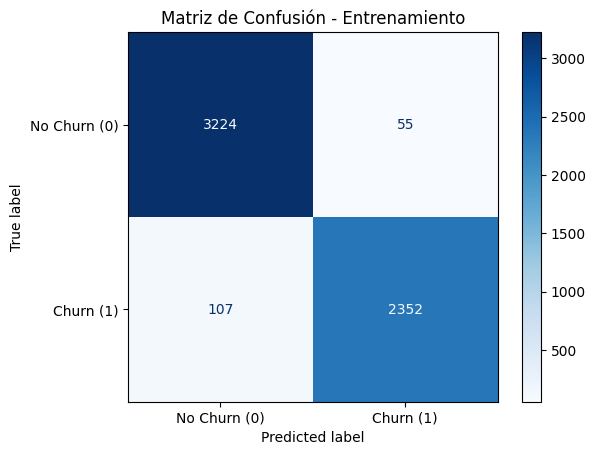

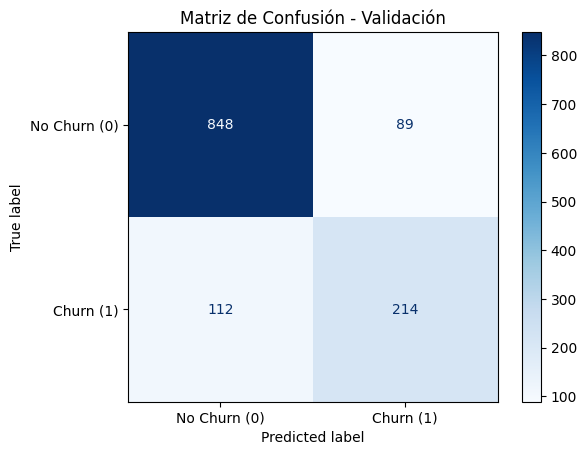

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Matriz de confusión para ENTRENAMIENTO ===
ConfusionMatrixDisplay.from_predictions(
    y_true=smote_resampled_target,  # Asegúrate de usar los valores verdaderos del entrenamiento
    y_pred=pred_train,
    display_labels=["No Churn (0)", "Churn (1)"],  # Aquí especificamos que 1 es "Churn"
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Entrenamiento")
plt.show()

# === Matriz de confusión para VALIDACIÓN ===
ConfusionMatrixDisplay.from_predictions(
    y_true=y_val,  # Asegúrate de usar los valores verdaderos de la validación
    y_pred=pred_val,
    display_labels=["No Churn (0)", "Churn (1)"],  # Aquí también especificamos que 1 es "Churn"
    cmap=plt.cm.Blues
)
plt.title("Matriz de Confusión - Validación")
plt.show()


# 8. Explainability

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [ ]:
explainer = shap.TreeExplainer(best_model)


In [ ]:
explanation = explainer(train_data[features])

In [ ]:
explanation.values.shape

(4420, 36)

In [ ]:
explanation.values[:, 1]


array([-0.01333435,  0.6145553 ,  0.9009584 , ...,  0.29585373,
       -1.3363436 , -0.9067807 ], dtype=float32)

In [ ]:
train_data[features].shape

(4420, 36)

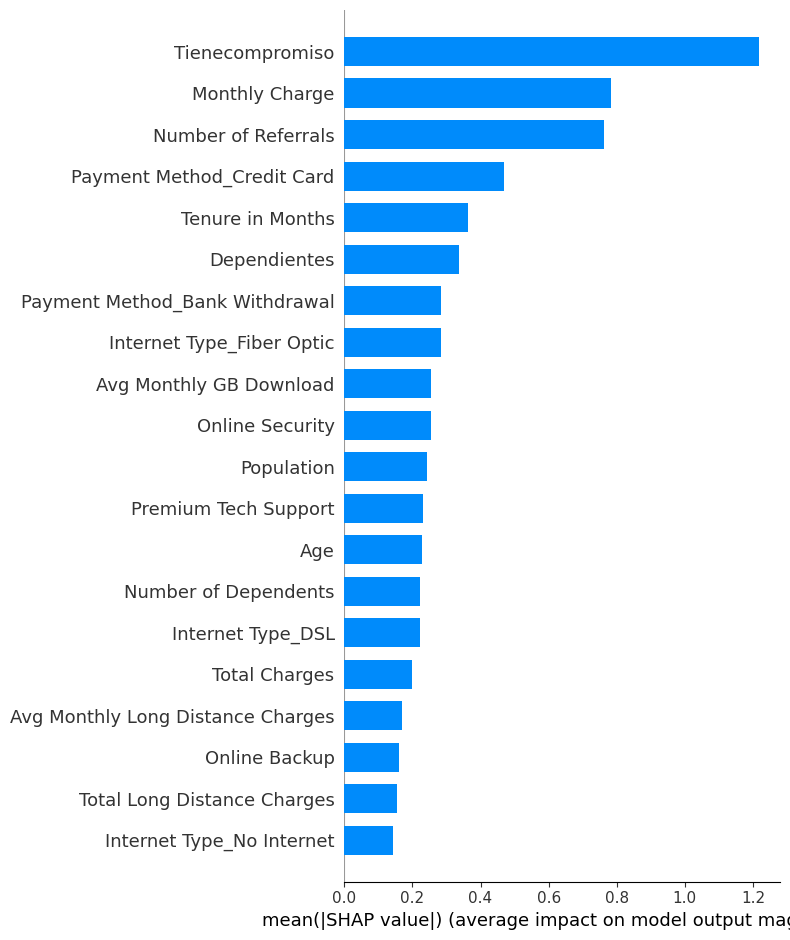

In [ ]:
import matplotlib.pyplot as plt
import shap

plt.figure(figsize=(20, 8))
shap.summary_plot(explanation.values, features=train_data[features], plot_type="bar")


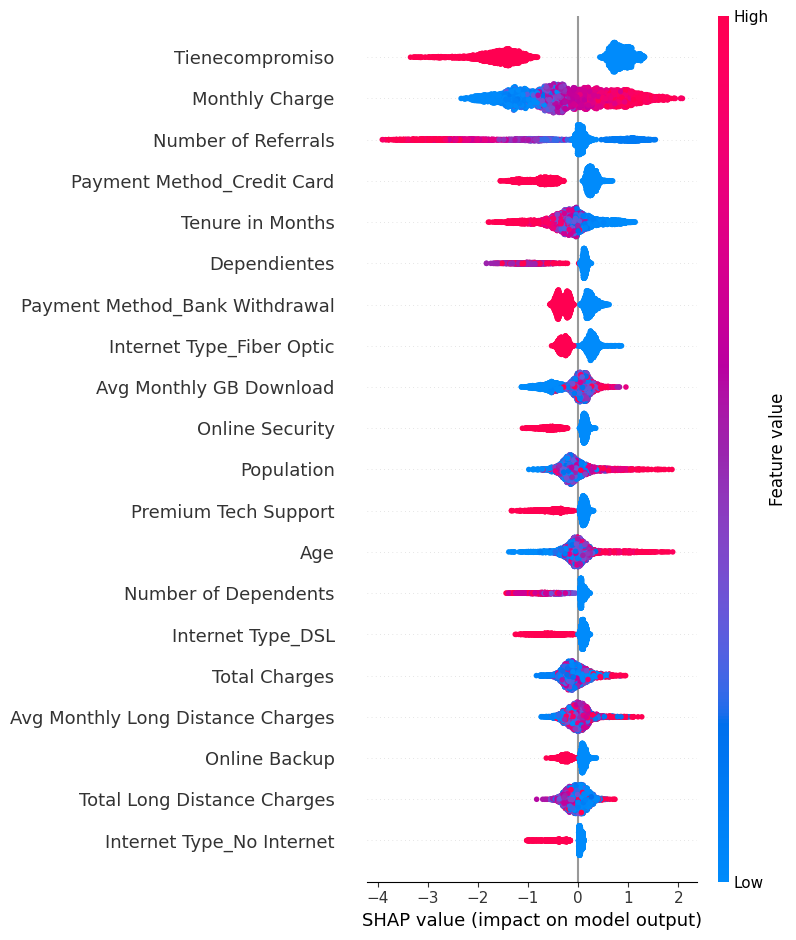

In [ ]:
plt.figure(figsize=(20,8))
shap.summary_plot(explanation.values, features=train_data[features])


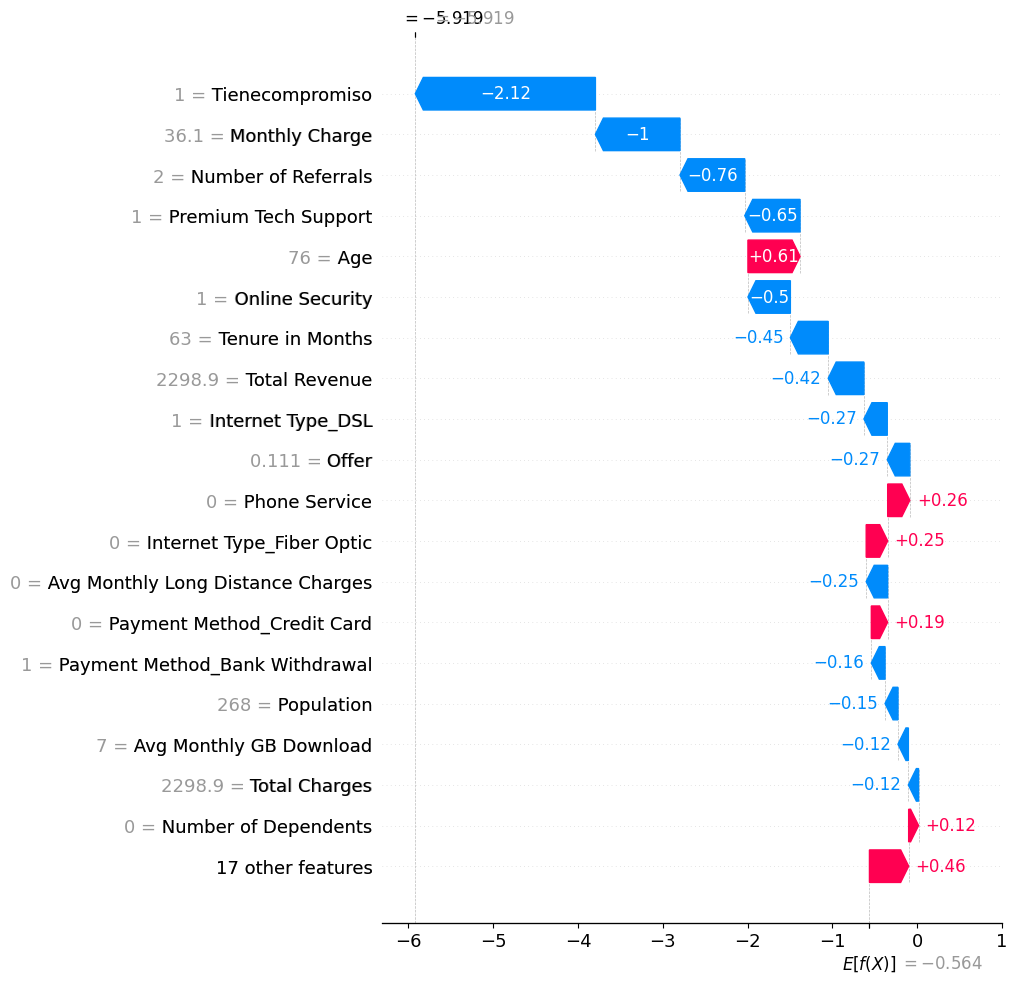

In [ ]:
shap.plots.waterfall(explanation[1], max_display=20)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones con el mejor modelo
pred_train = best_model.predict(smote_resampled_features[features])
pred_val = best_model.predict(val_data[features])
pred_test = best_model.predict(test_data[features])  # Predicciones para test_data

# Evaluación para entrenamiento
print("\n=== ENTRENAMIENTO (TUNEADO) ===")
print(classification_report(smote_resampled_target, pred_train))
print(confusion_matrix(smote_resampled_target, pred_train))

# Evaluación para validación
print("\n=== VALIDACIÓN (TUNEADO) ===")
print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val, pred_val))

# Evaluación para test
print("\n=== PRUEBA (TUNEADO) ===")  # Evaluación en test_data
print(classification_report(test_data["Churn Label"], pred_test))
print(confusion_matrix(test_data["Churn Label"], pred_test))  # Cambia 'target' por el nombre de la columna de tu variable dependiente en test_data



=== ENTRENAMIENTO (TUNEADO) ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3279
           1       0.98      0.96      0.97      2459

    accuracy                           0.97      5738
   macro avg       0.97      0.97      0.97      5738
weighted avg       0.97      0.97      0.97      5738

[[3224   55]
 [ 107 2352]]

=== VALIDACIÓN (TUNEADO) ===
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       937
           1       0.71      0.66      0.68       326

    accuracy                           0.84      1263
   macro avg       0.79      0.78      0.79      1263
weighted avg       0.84      0.84      0.84      1263

[[848  89]
 [112 214]]

=== PRUEBA (TUNEADO) ===
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       469
           1       0.73      0.67      0.70       163

    accuracy                           0.85

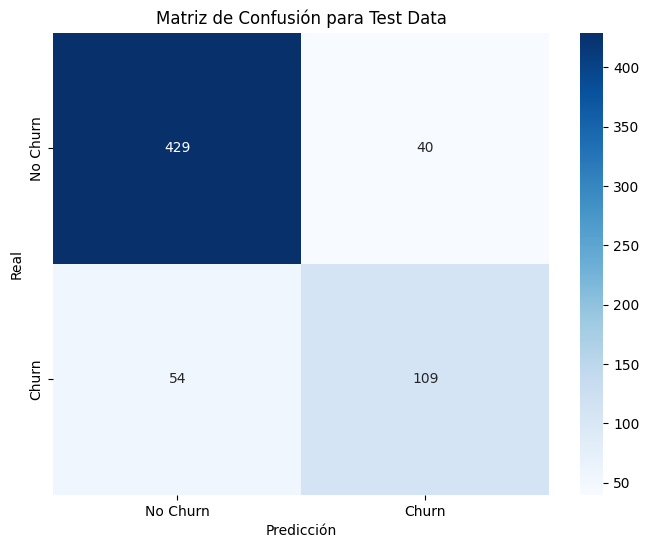

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(test_data['Churn Label'], pred_test)

# Crear la figura y el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Matriz de Confusión para Test Data")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()
